#Predicting the Presence or Absence of the Eastern Bluebird

##Introduction

Eastern Bluebird populations in the U.S. are known to be affected by factors such as habitat loss, changes in weather, and predation.  Habitat loss can be attributed to urbanization, or to intrusion of non-native birds such as House Sparrows, which are cavity nesters like bluebirds and will take over suitable nest cavities.  Eastern Bluebirds also prefer certain types of habitats.  In particular, they are often observed around edge habitats, e.g, where a tree line of a forest meets a farm field, or even a golf course.

Given data on the above factors, how well can the presence or absence of a bluebird be predicted within an area?  What are the most influential factors affecting bluebird presence or absence?  How does the presence of invasive birds rank relative to the other factors?

The following study will explore these questions by using data on bird observations and sites to model the presence/absence of the eastern bluebird.  The bird data comes from Project FeederWatch, which is a project orchestrated by the Cornell Lab of Ornithology.  With this project, the Cornell Lab collects data from thousands of locations across North America.  During each Project FeederWatch season spanning November through April, participants count the number of birds of each species they see during each observation, which takes place over a two-day period.  Within that period, participants are instructed to record the maximum number of each species observed simultaneously, which protects against counting the same bird twice.   Participants enter their data through an app.  In addition to bird counts, each observation will include:
*  Location (latitude, longitude, state)
*  Time period
*  Effort, which is a measure of the time spent by the observer over the two day period
*  Information on snow depth if any
*  Information on additional animals around such as cats
*  Description of habitat, yard, or vegetation around

Effort is a necessary measure because, as stated by Cornell Lab, “a recorded observation is a function of both the biological event (number of species actually present) and the observation process (probability that an individual, when present, will be observed).”

To begin the study, the Project FeederWatch data is prepared and then aggregated with the following supplemental data in order to capture additional information on urbanization, habitat, and weather.
*  Rural-Urban Continuum Codes and Urban-Influence Codes at the county level, sourced from the USDA.  Latitude and longitudes from the bird observation sites are mapped to the county centroids.
*  2015-2021 population estimates by county from the U.S. Census, mapped to the bird data on year, latitude, and longitude.
*  Land and water area by county from the U.S. Census, mapped to the bird data by latitude and longitude.
*  Daily minimum and maximumum temperatures, and precipitation extracted using the Applied Climate Information System (ACIS), and mapped to the bird data based on latitude, longitude, month, day, and year.


##Set up notebook

###Libraries and Settings

In [ ]:
import tensorflow
device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print("TensorFlow version:", tensorflow.__version__)

Found GPU at: /device:GPU:0
TensorFlow version: 2.8.2


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jul  2 01:26:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    42W / 300W |    727MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

8

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import math
import csv
import io
import itertools
import joblib
import ast
import json
import pickle
import datetime
from datetime import datetime, timedelta
from IPython import display
from IPython.display import clear_output

from collections import Counter
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import ensemble
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
import timeit
import time
from shapely.geometry.point import Point
from shapely.geometry import MultiPoint
from geopy.distance import great_circle

%matplotlib inline

In [ ]:
!pip install geopandas
import geopandas as gpd
import requests
import zipfile

!pip install mapclassify
import mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install umap-learn
import umap
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
pd.set_option("display.precision", 7)

###Files

In [ ]:
fdir = "/content/drive/MyDrive/Modules/Module_30_Capstone_4_Final_project/"

b2016 = "PFW_2016_2020_public.csv"   # PFW observation data 2016-2020
b2021 = "PFW_2021_public.csv"   # PFW observation data 2021
bsite = "PFW_count_site_data_public_2021.csv"   # PFW site description data
ushp = "cb_2018_us_state_20m.zip"   # U.S. shape file

###Functions

In [ ]:
# Create df of null_names, null_counts, null_proportion, and null_dtypes
def null_summary(df):
  var_null_list = df.columns[df.isna().any()]
  var_null_names = df[var_null_list].dtypes.index
  var_null_counts = df[var_null_list].isna().sum()
  var_null_proportion = df[var_null_list].isna().sum()/df[var_null_list].isna().count()
  var_null_dtypes = df[var_null_list].dtypes
  var_null_df = pd.DataFrame({'null_names' : var_null_names, 'null_counts' : var_null_counts, 'null_proportion' : var_null_proportion, 'null_dtypes' : var_null_dtypes})
  
  return var_null_df.reset_index(drop=True)

In [ ]:
# Subset a colormap into a new one
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [ ]:
# Get Top Absolute Correlations
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

In [ ]:
# Given a df and a list of columns within that df, 
# return a df summarizing the unique values of the columns
def unique_summary(df, col_list):
    dict_unq = {}
    list_len = []
    for col in col_list:
        length = df[col].unique().shape[0]
        list_len.append(length)
        max_len = max(list_len)
    for col in col_list:
        add_nan = max_len - df[col].unique().shape[0]             # Fill with NaNs to make the 
        dict_unq[col] = list(df[col].unique())+[np.nan]*add_nan   # lists the same size (a requirement for the df). 
        df_unq = pd.DataFrame(dict_unq)
    return df_unq

In [ ]:
# Plot the map with coordinates from the geo_df
def plot_map(geo_df, figsize, title):
    ax = usa_sub.plot(figsize=figsize, column='ALAND', color='lightgreen', legend=False)
    usa_sub.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=1)
    geo_df.plot(ax=ax, markersize=3, color='darkviolet', marker='o')
    ax.set(xticks=[], yticks=[])   # Removes axes
    ax.set_title(title, fontsize='large')
    plt.show()

In [ ]:
# Plot counts of checklists with and without bluebirds by state
def plot_bbstate(data, suptitle, height, aspect, ymax):

    # Draw a nested barplot
    g = sns.catplot(
        data=data, kind="bar",
        x="state", y="sub_id", hue="easblu_gr",
        ci="sd", palette={0: 'darkorange', 1: 'darkblue'}, alpha=.6, height=height, aspect=aspect,
        facet_kws={'legend_out': True}
    )
    g.despine(left=True)
    g.set_axis_labels("State", "Number of Checklists")
    g.legend.set_title("")
    g.fig.suptitle(suptitle)
    new_labels = ['Bluebird Absence', 'Bluebird Presence']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    plt.ylim(0, ymax)

    plt.show()

In [ ]:
def plot_feat_imp(method, method_title, top, X):
    
    feature_importance = method.feature_importances_

    # Make importances relative to max importance.
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[-1*top:]
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance ('+method_title+')')

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Given a scikit-learn confusion matrix (CM), make a nice plot.

    Arguments
    ---------
    cm:           Confusion matrix from sklearn.metrics.confusion_matrix

    target_names: Given classification classes, such as [0, 1, 2]
                  The class names, for example, ['high', 'medium', 'low']

    title:        The text to display at the top of the matrix

    cmap:         The gradient of the values displayed from matplotlib.pyplot.cm
                  See http://matplotlib.org/examples/color/colormaps_reference.html
                  `plt.get_cmap('jet')` or `plt.cm.Blues`

    normalize:    If `False`, plot the raw numbers
                  If `True`, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # Confusion matrix created by
                                                              # `sklearn.metrics.confusion_matrix`
                          normalize    = True,                # Show proportions
                          target_names = y_labels_vals,       # List of names of the classes
                          title        = best_estimator_name) # Title of graph

    Citation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
# Run a random forest classifier with GridSearchCV, fitting according to refit_score

def rf_grid_search(refit_score):

    rfc = ensemble.RandomForestClassifier(random_state=445)
    rfg = GridSearchCV(estimator=rfc, param_grid=params, scoring=scorers,
                       refit=refit_score, cv=cv, verbose=2, n_jobs=8)
    rfg.fit(X_train, y_train)

    return rfg

In [ ]:
# Run a gradient boosting classifier with GridSearchCV, fitting according to refit_score

def gb_grid_search(refit_score):

    gbc = ensemble.GradientBoostingClassifier(random_state=445)
    gbg = GridSearchCV(estimator=gbc, param_grid=params, scoring=scorers,
                       refit=refit_score, cv=cv, verbose=2, n_jobs=8)
    gbg.fit(X_train, y_train)

    return gbg

In [ ]:
# Run an ANN with param grid and return a df of results
def run_ann(params, X_train, y_train, X_test, y_test):

    initializer = tensorflow.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=108)

    model = Sequential()
    model.add(Dense(params['neuron_counts'][0], kernel_initializer=initializer,
                    input_shape=(X_train.shape[1],), activation=params['activ_func']))
    
    for i in np.arange(1, len(params['neuron_counts'])):
        model.add(Dense(params['neuron_counts'][i], kernel_initializer=initializer, activation=params['activ_func']))

    # Set the output layer as model.add(Dense(1, activation='sigmoid')) for binary classifier
    model.add(Dense(1, kernel_initializer=initializer, activation='sigmoid'))

    if params['optimizer_learn_rate'] == 'sgd':
        optimizer_learn_rate = params['optimizer_learn_rate']
    else:
        optimizer_learn_rate = optimizers.SGD(lr=params['optimizer_learn_rate'])

    start = timeit.default_timer()

    #Set to loss='binary_crossentropy' for binary classifier
    model.compile(optimizer=optimizer_learn_rate, loss='binary_crossentropy', metrics=[tensorflow.keras.metrics.AUC()])
    model.fit(X_train, y_train, batch_size=params['batch_size'], epochs=params['nb_epoch'], verbose=0)

    stop = timeit.default_timer()

    run_time = stop - start

    y_preds_test_prob = model.predict(X_test)
    # The model outputs probabilities.
    # For plotting the confusion matrix, change the output back to binary based on a decision threshold of 0.5
    y_preds_test = (y_preds_test_prob > 0.5)
    ann_probs = y_preds_test_prob.reshape(1,-1)[0]

    score_train = model.evaluate(X_train, y_train, verbose=0)
    score_test = model.evaluate(X_test, y_test, verbose=0)
    train_test_diff = score_train[1] - score_test[1]
    precision = precision_score(y_test, y_preds_test)
    recall = recall_score(y_test, y_preds_test)
    f1 = f1_score(y_test, y_preds_test)
    fbeta_precision = fbeta_score(y_test, y_preds_test, beta = 0.5)
    fbeta_recall = fbeta_score(y_test, y_preds_test, beta = 2.0)
    auc = roc_auc_score(y_test, ann_probs)

    cols = ['neuron_counts', 'activ_func', 'optimizer_learn_rate', 'batch_size', 'nb_epoch', 'train_accuracy', 'test_accuracy',
            'train_test_diff', 'precision', 'recall', 'ROCAUC', 'f1', 'fbeta_precision', 'fbeta_recall', 'run_time']

    results_df = pd.DataFrame(columns=cols)

    results_list = [params['neuron_counts'], params['activ_func'], params['optimizer_learn_rate'], params['batch_size'], params['nb_epoch'],
                    score_train[1], score_test[1], train_test_diff, precision, recall, auc, f1, fbeta_precision, fbeta_recall, run_time]

    for idx, val in enumerate(results_list):
        results_df.loc[0, cols[idx]] = val

    return results_df, model

##EDA

###Project FeederWatch (PFW) Observation Data: explore, clean, subset

Load the PFW data for PFW seasons 2016 through 2021.

In [ ]:
# PFW_2016_2020_public.csv
pfw_2016_2020 = pd.read_csv(fdir + b2016)

# PFW_2021_public.csv
pfw_2021 = pd.read_csv(fdir + b2021)

In [ ]:
print('pfw_2016_2020 shape: {}'.format(pfw_2016_2020.shape))
print('pfw_2021 shape: {}'.format(pfw_2021.shape))
print('\n')
print('pfw_2016_2020 columns:')
print('\n')
print(pfw_2016_2020.columns)
print('\n')
print('pfw_2021 columns:')
print('\n')
print(pfw_2021.columns)

pfw_2016_2020 shape: (9172943, 23)
pfw_2021 shape: (2897105, 22)


pfw_2016_2020 columns:


Index(['LOC_ID', 'LATITUDE', 'LONGITUDE', 'SUBNATIONAL1_CODE',
       'ENTRY_TECHNIQUE', 'SUB_ID', 'OBS_ID', 'Month', 'Day', 'Year',
       'PROJ_PERIOD_ID', 'SPECIES_CODE', 'HOW_MANY', 'PLUS_CODE', 'VALID',
       'REVIEWED', 'DAY1_AM', 'DAY1_PM', 'DAY2_AM', 'DAY2_PM',
       'EFFORT_HRS_ATLEAST', 'SNOW_DEP_ATLEAST', 'Data_Entry_Method'],
      dtype='object')


pfw_2021 columns:


Index(['loc_id', 'latitude', 'longitude', 'subnational1_code',
       'entry_technique', 'sub_id', 'obs_id', 'Month', 'Day', 'Year',
       'PROJ_PERIOD_ID', 'species_code', 'how_many', 'valid', 'reviewed',
       'day1_am', 'day1_pm', 'day2_am', 'day2_pm', 'effort_hrs_atleast',
       'snow_dep_atleast', 'Data_Entry_Method'],
      dtype='object')


Make all column names lowercase.

In [ ]:
pfw_2016_2020.columns = map(str.lower, pfw_2016_2020.columns)
pfw_2021.columns = map(str.lower, pfw_2021.columns)

The column, plus_code, exists only in the 2016-2020 data.  It will not be used for this study.  Remove it.  

In [ ]:
pfw_2016_2020 = pfw_2016_2020.drop(columns = ['plus_code'])

pfw_2016_2020.sample(4)

loc_id    latitude   longitude subnational1_code  \
2777506  L5080414  34.6883910 -82.3416380             US-SC   
8970650    L40338  37.6449400 -84.7745400             US-KY   
2362790   L105512  38.6071122 -76.6681337             US-MD   
2127875   L189337  42.8400002 -86.1999969             US-MI   

                  entry_technique     sub_id        obs_id  month  day  year  \
2777506       /GOOGLE_MAP/ZOOM:15  S51134122  OBS691753317     12   29  2018   
8970650  POSTCODE LAT/LONG LOOKUP  S33882268  OBS459751283      1   21  2017   
2362790                  topozone  S51693758  OBS698587021      1   13  2019   
2127875               delorme map  S50784812  OBS687361001     12   15  2018   

         ... how_many valid  reviewed  day1_am  day1_pm  day2_am  day2_pm  \
2777506  ...        3     1         0        1        1        1        1   
8970650  ...        1     1         0        1        1        1        1   
2362790  ...        1     1         0        1        1        1        1   
2127875  ...       21     1         0        0        1        1        1   

         effort_hrs_atleast  snow_dep_atleast       data_entry_method  
2777506               0.001               NaN           PFW Web 3.0.0  
8970650               0.001             0.000             PFW Web 2.x  
2362790               4.001            15.001  PFW Web 3.0.3-SNAPSHOT  
2127875               1.001             0.000           PFW Web 3.0.0  

[4 rows x 22 columns]

In [ ]:
pfw_2021.sample(4)

loc_id    latitude   longitude subnational1_code  \
566831      L73278  36.1794538 -92.6379633             US-AR   
1552572  L10372175  44.5508149 -72.6397133             US-VT   
2644836  L12755513  39.2680818 -84.5030054             US-OH   
555278      L72773  38.4544100 -76.4947100             US-MD   

                  entry_technique     sub_id         obs_id  month  day  year  \
566831   POSTCODE LAT/LONG LOOKUP  S79173672  OBS1050698283      1   10  2021   
1552572       /GOOGLE_MAP/ZOOM:15  S83139560  OBS1091847271      2   27  2021   
2644836       /GOOGLE_MAP/ZOOM:15  S82752806  OBS1087438561      3    2  2021   
555278   POSTCODE LAT/LONG LOOKUP  S87168668  OBS1142861351      2    1  2021   

         ... how_many valid  reviewed  day1_am  day1_pm  day2_am  day2_pm  \
566831   ...        1     1         0        1        1        1        1   
1552572  ...        1     1         0        1        1        0        0   
2644836  ...        1     1         0        1        1        1        1   
555278   ...        5     1         0        1        1        1        1   

         effort_hrs_atleast  snow_dep_atleast  data_entry_method  
566831                1.001             0.000      PFW Web 4.1.4  
1552572               4.001            15.001      PFW Web 4.1.4  
2644836               1.001             0.000      PFW Web 4.1.4  
555278                1.001             5.000      PFW Web 4.1.4  

[4 rows x 22 columns]

In [ ]:
pfw_2016_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172943 entries, 0 to 9172942
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   loc_id              object 
 1   latitude            float64
 2   longitude           float64
 3   subnational1_code   object 
 4   entry_technique     object 
 5   sub_id              object 
 6   obs_id              object 
 7   month               int64  
 8   day                 int64  
 9   year                int64  
 10  proj_period_id      object 
 11  species_code        object 
 12  how_many            int64  
 13  valid               int64  
 14  reviewed            int64  
 15  day1_am             int64  
 16  day1_pm             int64  
 17  day2_am             int64  
 18  day2_pm             int64  
 19  effort_hrs_atleast  float64
 20  snow_dep_atleast    float64
 21  data_entry_method   object 
dtypes: float64(4), int64(10), object(8)
memory usage: 1.5+ GB


In [ ]:
pfw_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2897105 entries, 0 to 2897104
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   loc_id              object 
 1   latitude            float64
 2   longitude           float64
 3   subnational1_code   object 
 4   entry_technique     object 
 5   sub_id              object 
 6   obs_id              object 
 7   month               int64  
 8   day                 int64  
 9   year                int64  
 10  proj_period_id      object 
 11  species_code        object 
 12  how_many            int64  
 13  valid               int64  
 14  reviewed            int64  
 15  day1_am             int64  
 16  day1_pm             int64  
 17  day2_am             int64  
 18  day2_pm             int64  
 19  effort_hrs_atleast  float64
 20  snow_dep_atleast    float64
 21  data_entry_method   object 
dtypes: float64(4), int64(10), object(8)
memory usage: 486.3+ MB


The datasets are now consistent and ready for concatenation.

In [ ]:
pfw = pd.concat([pfw_2016_2020, pfw_2021], ignore_index=True)

print('Shape of combined PFW data: {}'.format(pfw.shape))
print('\n')
print('Number of bird species within the data: {}'.format(pfw['species_code'].nunique()))

Shape of combined PFW data: (12070048, 22)


Number of bird species within the data: 724


Each PFW period runs from November through the following April, and is denoted by the year in which the period ends.  As a result, the data spans 7 years but only 6 periods, with the bounding years, 2015 and 2021, only partially represented in the data.  

The following list of PFW periods will be accessed throughout the notebook.

In [ ]:
periods = sorted(list(pfw['proj_period_id'].unique()))
periods

['PFW_2016', 'PFW_2017', 'PFW_2018', 'PFW_2019', 'PFW_2020', 'PFW_2021']

In [ ]:
start_year = pfw.year.min()
start_month = pfw[pfw.year == start_year].month.min()
start_day = pfw[(pfw.year == start_year) & (pfw.month == start_month)].day.min()

end_year = pfw.year.max()
end_month = pfw[pfw.year == end_year].month.max()
end_day = pfw[(pfw.year == end_year) & (pfw.month == end_month)].day.max()

print('Starting date of data: {}/{}/{}'.format(start_month, start_day, start_year))
print('\n')
print('Ending date of data: {}/{}/{}'.format(end_month, end_day, end_year))

Starting date of data: 11/1/2015


Ending date of data: 4/30/2021


Clean up NaNs.

In [ ]:
# null_summary is a function defined previously
var_null_df = null_summary(pfw)
var_null_df

null_names  null_counts  null_proportion null_dtypes
0     entry_technique       581823        0.0482039      object
1  effort_hrs_atleast        27551        0.0022826     float64
2    snow_dep_atleast      1154865        0.0956802     float64

Drop the column, entry_technique.  It will not be used in this study.

In [ ]:
pfw = pfw.drop(columns = ['entry_technique'])

Remove rows that have no record of effort.

In [ ]:
pfw = pfw.dropna(subset = ['effort_hrs_atleast'])

Zero fill the NaNs in snow_dep_atleast.

In [ ]:
pfw['snow_dep_atleast'] = pfw['snow_dep_atleast'].fillna(0)

var_null_df = null_summary(pfw)
var_null_df

Empty DataFrame
Columns: [null_names, null_counts, null_proportion, null_dtypes]
Index: []

In [ ]:
print('Updated shape of data: {}'.format(pfw.shape))

Updated shape of data: (12042497, 21)


The data has two fields, "valid" and "reviewed", based on Cornell Lab's data flagging system:
*  VALID:  Validity of each observation based on flagging system
*  REVIEWED:  Review state of each observation based on flagging system  

In [ ]:
print("Unique combinations and of 'valid' and 'reviewed', and record counts:")
print('\n')
print(pfw.groupby(['valid','reviewed']).count().reset_index()[['valid', 'reviewed', 'sub_id']])

Unique combinations and of 'valid' and 'reviewed', and record counts:


   valid  reviewed    sub_id
0      0         0     42877
1      0         1      2959
2      1         0  11921945
3      1         1     74716


Keep only records with Valid = 1; Reviewed = 0, which is the majority of the records.

Explanation from Cornell of Valid = 1; Reviewed = 0: report did not trigger the automatic flagging system and was accepted into the database without review.

In [ ]:
pfw = pfw[(pfw['valid'] == 1) & (pfw['reviewed'] == 0)]
print('Updated shape of data: {}'.format(pfw.shape))

Updated shape of data: (11921945, 21)


Combine year, month, and day into a datetime column to more easily access date info.

In [ ]:
pfw['datetime'] = pfw['year'].astype(str) + "-" + pfw['month'].astype(str) + "-" + pfw['day'].astype(str)

def dateformat(date):
    return datetime.strptime(date, '%Y-%m-%d')

pfw['datetime'] = pfw['datetime'].apply(dateformat)

In [ ]:
pfw.subnational1_code.unique()

array(['US-FL', 'CA-ON', 'US-VA', 'US-MI', 'US-NY', 'US-PA', 'US-WA',
       'US-TX', 'US-MN', 'US-CA', 'US-CO', 'US-SC', 'US-NC', 'US-AL',
       'CA-AB', 'US-AR', 'US-IL', 'US-MD', 'US-OR', 'US-NJ', 'US-LA',
       'US-CT', 'US-WV', 'US-ID', 'US-DE', 'US-MA', 'US-IN', 'US-AZ',
       'US-OH', 'US-TN', 'US-WI', 'US-NV', 'US-VT', 'US-NM', 'US-KS',
       'US-UT', 'CA-NB', 'US-MO', 'CA-BC', 'CA-QC', 'CA-NS', 'CA-SK',
       'CA-MB', 'CA-NT', 'CA-YT', 'CA-NL', 'CA-PE', 'XX-', 'NZ-OTA',
       'CA-NU', 'US-OK', 'PM-', 'US-NE', 'US-ME', 'US-WY', 'US-NH',
       'US-ND', 'US-KY', 'US-AK', 'US-IA', 'US-SD', 'US-MT', 'US-GA',
       'US-MS', 'US-RI', 'US-HI', 'US-DC', 'MX-NAY', 'MX-JAL'],
      dtype=object)

Subset records from the U.S. (excluding Mexico and Canada), since the additional data to be aggregated is for the U.S.

In [ ]:
pfw = pfw[pfw['subnational1_code'].str.split('-').str[0].isin(['US'])]
print('Updated shape of data: {}'.format(pfw.shape))

Updated shape of data: (10322661, 22)


In [ ]:
pfw.subnational1_code.unique()

array(['US-FL', 'US-VA', 'US-MI', 'US-NY', 'US-PA', 'US-WA', 'US-TX',
       'US-MN', 'US-CA', 'US-CO', 'US-SC', 'US-NC', 'US-AL', 'US-AR',
       'US-IL', 'US-MD', 'US-OR', 'US-NJ', 'US-LA', 'US-CT', 'US-WV',
       'US-ID', 'US-DE', 'US-MA', 'US-IN', 'US-AZ', 'US-OH', 'US-TN',
       'US-WI', 'US-NV', 'US-VT', 'US-NM', 'US-KS', 'US-UT', 'US-MO',
       'US-OK', 'US-NE', 'US-ME', 'US-WY', 'US-NH', 'US-ND', 'US-KY',
       'US-AK', 'US-IA', 'US-SD', 'US-MT', 'US-GA', 'US-MS', 'US-RI',
       'US-HI', 'US-DC'], dtype=object)

Rename the states, getting rid of the leading 'US-'

In [ ]:
split = pfw['subnational1_code'].str.split('-', n=1, expand=True)
pfw['state'] = split[1]
pfw = pfw.drop(columns = ['subnational1_code'])

pfw['state'].unique()

array(['FL', 'VA', 'MI', 'NY', 'PA', 'WA', 'TX', 'MN', 'CA', 'CO', 'SC',
       'NC', 'AL', 'AR', 'IL', 'MD', 'OR', 'NJ', 'LA', 'CT', 'WV', 'ID',
       'DE', 'MA', 'IN', 'AZ', 'OH', 'TN', 'WI', 'NV', 'VT', 'NM', 'KS',
       'UT', 'MO', 'OK', 'NE', 'ME', 'WY', 'NH', 'ND', 'KY', 'AK', 'IA',
       'SD', 'MT', 'GA', 'MS', 'RI', 'HI', 'DC'], dtype=object)

Using a longitude range, subset the data to states within the eastern bluebird's range.  The following longitude range is from the western tip of Texas to the eastern tip of Maine.

In [ ]:
pfw = pfw[(pfw['longitude'] > -106.645646) & (pfw['longitude'] < -66.949895)]
print('Updated shape of data: {}'.format(pfw.shape))

Updated shape of data: (8821331, 22)


In [ ]:
print("Updated list of states representing the eastern bluebird's range:")
print('\n')
print(pfw['state'].unique())

Updated list of states representing the eastern bluebird's range:


['FL' 'VA' 'MI' 'NY' 'PA' 'TX' 'MN' 'CO' 'SC' 'NC' 'AL' 'AR' 'IL' 'MD'
 'NJ' 'LA' 'CT' 'WV' 'DE' 'MA' 'IN' 'OH' 'TN' 'WI' 'VT' 'KS' 'MO' 'OK'
 'NE' 'NM' 'ME' 'NH' 'ND' 'KY' 'IA' 'SD' 'GA' 'WY' 'MS' 'MT' 'RI' 'DC']


MT, WY, CO, and NM are mostly outside the eastern bluebird's range. Remove their records from the data.

In [ ]:
rem_states = ['MT', 'WY', 'CO', 'NM']
pfw = pfw[~pfw['state'].isin(rem_states)]
print("Updated list of states representing the eastern bluebird's range:")
print('\n')
print(pfw['state'].unique())
print('\n')
print('Updated shape of data: {}'.format(pfw.shape))

Updated list of states representing the eastern bluebird's range:


['FL' 'VA' 'MI' 'NY' 'PA' 'TX' 'MN' 'SC' 'NC' 'AL' 'AR' 'IL' 'MD' 'NJ'
 'LA' 'CT' 'WV' 'DE' 'MA' 'IN' 'OH' 'TN' 'WI' 'VT' 'KS' 'MO' 'OK' 'NE'
 'ME' 'NH' 'ND' 'KY' 'IA' 'SD' 'GA' 'MS' 'RI' 'DC']


Updated shape of data: (8550033, 22)


One focus of this study will be the interaction between bluebird presence/absence and the counts of non-native birds such as house sparrows and european starlings.  Therefore, filter the data down to sites that have observed at least 1 eastern bluebird, at least one house sparrow, or at least 1 european starling.
*  Eastern Bluebird species_code = easblu
*  House Sparrow species_code = houspa
*  European Starling species_code = eursta

The column, "loc_id", contains a unique identifier for each survey site.

In [ ]:
print('Number of sites before subset: {}'.format(pfw['loc_id'].nunique()))

df_gr = pfw.groupby(['loc_id', 'species_code']).sum().reset_index()
df_gr_b = df_gr[(df_gr['species_code'] == 'easblu') | (df_gr['species_code'] == 'eursta') | (df_gr['species_code'] == 'houspa')]
locs = list(df_gr_b['loc_id'].unique())

pfwb = pfw[pfw['loc_id'].isin(locs)]

print('Number of sites after subset: {}'.format(pfwb['loc_id'].nunique()))
print('\n')
print('Updated shape of data: {}'.format(pfwb.shape))

Number of sites before subset: 22388
Number of sites after subset: 18741


Updated shape of data: (8074195, 22)


Next, investigate the total number of observations of each bird species over all seasons.  In other words, explore the number of bird species seen only a few times vs. the number of bird species seen numerous times.

In [ ]:
spcs_count = pfwb.groupby('species_code')['obs_id'].count().reset_index()
spcs_count.sort_values(by='obs_id', ascending=False)

species_code  obs_id
153       norcar  549847
80        dowwoo  493650
146       moudov  464193
78        daejun  457301
124       houfin  424739
..           ...     ...
1        agwtea1       1
13        amwpel       1
100       gilwoo       1
23        belvir       1
191       rensap       1

[261 rows x 2 columns]

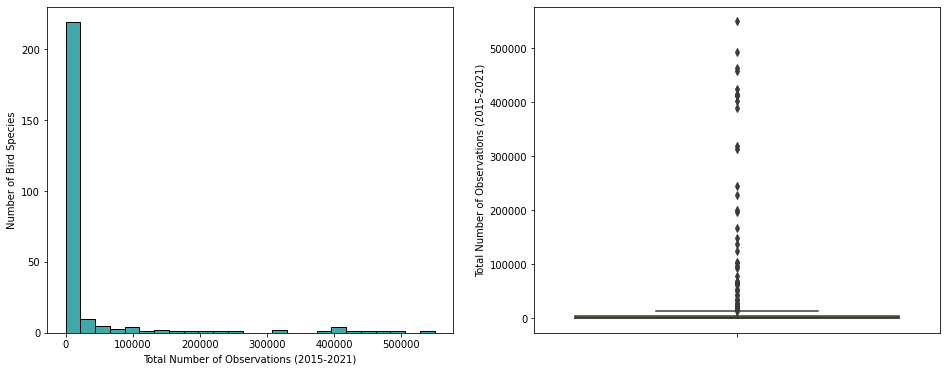

In [ ]:
plt.figure(figsize = (16,6))

plt.subplot(1, 2, 1)
sns.histplot(spcs_count['obs_id'], bins=25, color='darkcyan')
plt.xlabel("Total Number of Observations (2015-2021)")
plt.ylabel("Number of Bird Species")

plt.subplot(1, 2, 2)
sns.boxplot(y = spcs_count['obs_id'], whis = 2, color='darkgoldenrod').set(ylabel = "Total Number of Observations (2015-2021)")

plt.show()

In the above plots, the low end represents the large number of species of rarely seen birds, and the high end represents the small number of species of birds that are seen numerous times.  The latter is the focus of this study.

In [ ]:
spcs_list = pfwb['species_code'].unique().tolist()

print('Current number of bird species in the data: {}'.format(len(spcs_list)))

Current number of bird species in the data: 261


In [ ]:
# Set a floor for number of observations per bird species
obsv_min = 20000

# Get the birds that fall below the floor,
# and remove their observations from the data
drop_birds = spcs_count[spcs_count['obs_id'] < obsv_min]['species_code'].tolist()
pfwb = pfwb[~pfwb['species_code'].isin(drop_birds)]

spcs_list = pfwb['species_code'].unique().tolist()

print('Current number of bird species in the data: {}'.format(len(spcs_list)))

Current number of bird species in the data: 45


In [ ]:
total_per_ckl = pfwb.groupby('sub_id').sum()['how_many']
total_per_ckl.describe()

count    657812.0000000
mean         42.1054359
std          29.1499297
min           1.0000000
25%          22.0000000
50%          36.0000000
75%          54.0000000
max        1327.0000000
Name: how_many, dtype: float64

Just checking that all checklists have at least one bird.

After the subset of total observation count by species:

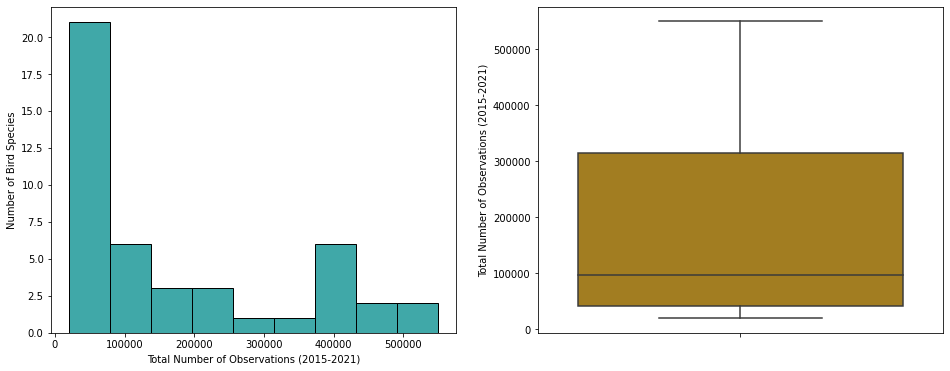

In [ ]:
spcs_count = pfwb.groupby('species_code')['obs_id'].count().reset_index()

plt.figure(figsize = (16,6))

plt.subplot(1, 2, 1)
sns.histplot(spcs_count['obs_id'], bins=9, color='darkcyan')
plt.xlabel("Total Number of Observations (2015-2021)")
plt.ylabel("Number of Bird Species")

plt.subplot(1, 2, 2)
sns.boxplot(y = spcs_count['obs_id'], whis = 2, color='darkgoldenrod').set(ylabel = "Total Number of Observations (2015-2021)")

plt.show()

Participants count the number of birds of each species they see during each observation, which takes place over a two-day period.  Within that period, participants are instructed to record the maximum number of each species observed simultaneously, which protects against counting the same bird twice.  Additionally, participants are instructed to record information on the habitat around the site.  All of the information about the observation over the two-day period is recorded on a "checklist".  The column, "sub_id", contains a unique identifier for each checklist.  Therefore, in the data, each loc_id is associated with multiple sub_id's collected throughout a November-April PFW period.

Furthermore, in its current form, the data has multiple records per checklist because each observed bird species (species_code) within a checklist is listed as a separate record labeled with a unique identifier (obs_id).  This is illustrated in the filtered dataframe below for sub_id S28051135.

In [ ]:
pfwb[pfwb.sub_id == 'S28051135']

loc_id    latitude   longitude     sub_id        obs_id  month  \
8839429  L3178670  42.2908538 -71.2535059  S28051135  OBS379926875      2   
8839430  L3178670  42.2908538 -71.2535059  S28051135  OBS379926876      2   
8839431  L3178670  42.2908538 -71.2535059  S28051135  OBS379926877      2   
8839432  L3178670  42.2908538 -71.2535059  S28051135  OBS379926878      2   
8839433  L3178670  42.2908538 -71.2535059  S28051135  OBS379926879      2   
8839434  L3178670  42.2908538 -71.2535059  S28051135  OBS379926880      2   
8839435  L3178670  42.2908538 -71.2535059  S28051135  OBS379926881      2   
8839436  L3178670  42.2908538 -71.2535059  S28051135  OBS379926882      2   
8839437  L3178670  42.2908538 -71.2535059  S28051135  OBS379926883      2   
8839438  L3178670  42.2908538 -71.2535059  S28051135  OBS379926884      2   
8839439  L3178670  42.2908538 -71.2535059  S28051135  OBS379926885      2   
8839440  L3178670  42.2908538 -71.2535059  S28051135  OBS379926886      2   
8839441  L3178670  42.2908538 -71.2535059  S28051135  OBS379926887      2   
8839442  L3178670  42.2908538 -71.2535059  S28051135  OBS379926888      2   

         day  year proj_period_id species_code  ...  reviewed  day1_am  \
8839429   28  2016       PFW_2016       coohaw  ...         0        1   
8839430   28  2016       PFW_2016       blujay  ...         0        1   
8839431   28  2016       PFW_2016       tuftit  ...         0        1   
8839432   28  2016       PFW_2016       rebwoo  ...         0        1   
8839433   28  2016       PFW_2016       dowwoo  ...         0        1   
8839434   28  2016       PFW_2016       houspa  ...         0        1   
8839435   28  2016       PFW_2016       whbnut  ...         0        1   
8839436   28  2016       PFW_2016       daejun  ...         0        1   
8839437   28  2016       PFW_2016       eursta  ...         0        1   
8839438   28  2016       PFW_2016       moudov  ...         0        1   
8839439   28  2016       PFW_2016       amegfi  ...         0        1   
8839440   28  2016       PFW_2016       houfin  ...         0        1   
8839441   28  2016       PFW_2016       norcar  ...         0        1   
8839442   28  2016       PFW_2016       amecro  ...         0        1   

         day1_pm  day2_am  day2_pm  effort_hrs_atleast  snow_dep_atleast  \
8839429        1        1        1               1.001             0.001   
8839430        1        1        1               1.001             0.001   
8839431        1        1        1               1.001             0.001   
8839432        1        1        1               1.001             0.001   
8839433        1        1        1               1.001             0.001   
8839434        1        1        1               1.001             0.001   
8839435        1        1        1               1.001             0.001   
8839436        1        1        1               1.001             0.001   
8839437        1        1        1               1.001             0.001   
8839438        1        1        1               1.001             0.001   
8839439        1        1        1               1.001             0.001   
8839440        1        1        1               1.001             0.001   
8839441        1        1        1               1.001             0.001   
8839442        1        1        1               1.001             0.001   

         data_entry_method   datetime state  
8839429        PFW Web 2.x 2016-02-28    MA  
8839430        PFW Web 2.x 2016-02-28    MA  
8839431        PFW Web 2.x 2016-02-28    MA  
8839432        PFW Web 2.x 2016-02-28    MA  
8839433        PFW Web 2.x 2016-02-28    MA  
8839434        PFW Web 2.x 2016-02-28    MA  
8839435        PFW Web 2.x 2016-02-28    MA  
8839436        PFW Web 2.x 2016-02-28    MA  
8839437        PFW Web 2.x 2016-02-28    MA  
8839438        PFW Web 2.x 2016-02-28    MA  
8839439        PFW Web 2.x 2016-02-28    MA  
8839440        PFW Web 2.x 2016-02-28    MA  
88394

Next, explore the number of unique checklists per site, per PFW period.  

In [ ]:
# Regroup by site and period, and get unique counts of other fields
df_counts = pfwb.groupby(['loc_id', 'proj_period_id']).nunique().reset_index()

print('Descriptive statistics of the number of checklists per site, per PFW period:')
print(df_counts['sub_id'].describe())

Descriptive statistics of the number of checklists per site, per PFW period:
count    47430.0000000
mean        13.8691124
std          7.5445243
min          1.0000000
25%          8.0000000
50%         15.0000000
75%         20.0000000
max         86.0000000
Name: sub_id, dtype: float64


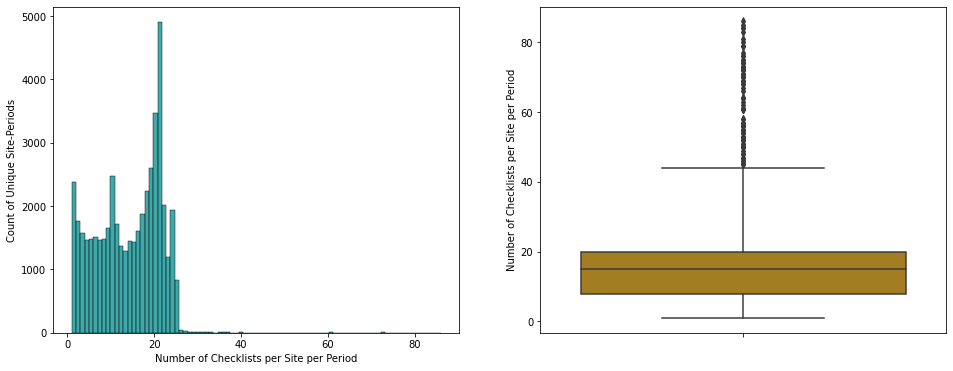

In [ ]:
plt.figure(figsize = (16,6))

plt.subplot(1, 2, 1)
sns.histplot(df_counts['sub_id'], bins=86, color='darkcyan')
plt.xlabel("Number of Checklists per Site per Period")
plt.ylabel("Count of Unique Site-Periods")

plt.subplot(1, 2, 2)
bxp = sns.boxplot(y = df_counts['sub_id'], whis = 2, color='darkgoldenrod').set(ylabel = "Number of Checklists per Site per Period")

plt.show()

Set a floor for the number of unique checklists per site, per PFW period.

In [ ]:
min_ckl = 6   # Min number of checklists per site, per PFW period

# Extract the loc_ids that do not meet the min_ckl criteria, and their corresponding PFW period
rem_locs = df_counts[df_counts['sub_id'] < min_ckl][['loc_id', 'proj_period_id']]

# Outer merge with indicator=True, then filter the records, 
# excluding any unique loc_id-proj_period_id that exists in the rem_locs df
out_mrg = pfwb.merge(rem_locs, on=['loc_id', 'proj_period_id'], how="outer", indicator=True)
pfwb = out_mrg.loc[out_mrg['_merge'] == 'left_only'].drop('_merge', axis=1)

After the subset of checklists.

In [ ]:
# Regroup by site and period, and get unique counts of other fields
df_counts = pfwb.groupby(['loc_id', 'proj_period_id']).nunique().reset_index()

print('Descriptive statistics of the number of checklists per site, per PFW period:')
print(df_counts['sub_id'].describe())

Descriptive statistics of the number of checklists per site, per PFW period:
count    38776.0000000
mean        16.3486693
std          5.9547228
min          6.0000000
25%         11.0000000
50%         18.0000000
75%         21.0000000
max         86.0000000
Name: sub_id, dtype: float64


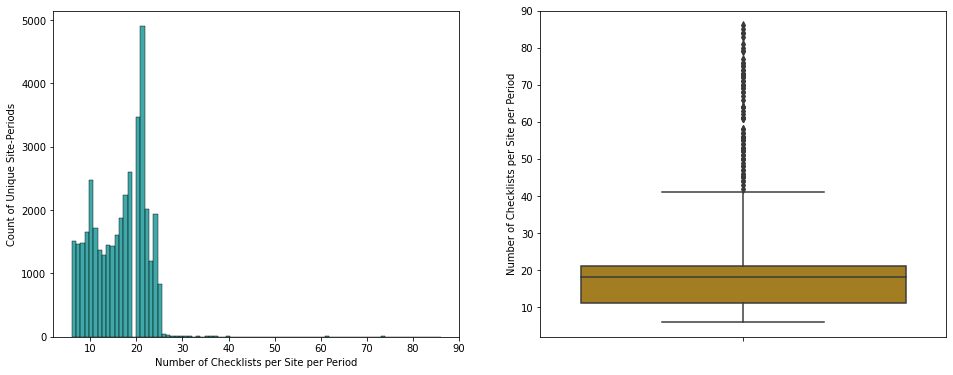

In [ ]:
plt.figure(figsize = (16,6))

plt.subplot(1, 2, 1)
sns.histplot(df_counts['sub_id'], bins=86, color='darkcyan')
plt.xlabel("Number of Checklists per Site per Period")
plt.ylabel("Count of Unique Site-Periods")

plt.subplot(1, 2, 2)
bxp = sns.boxplot(y = df_counts['sub_id'], whis = 2, color='darkgoldenrod').set(ylabel = "Number of Checklists per Site per Period")

plt.show()

In [ ]:
print('Current number of sites in the data: {}'.format(pfwb['loc_id'].nunique()))
print('\n')
print('Current number of bird species in the data: {}'.format(pfwb['species_code'].nunique()))
print('\n')
print('Current shape of the data: {}'.format(pfwb.shape))

Current number of sites in the data: 14592


Current number of bird species in the data: 45


Current shape of the data: (7515668, 22)


###Pivot the Dataframe

As described previously, the dataframe currently has multiple records per checklist because each observed bird species (species_code) within a checklist is listed as a separate record labeled with a unique identifier (obs_id).  This is illustrated again in the filtered dataframe below for sub_id S28051135.

In [ ]:
pfwb[pfwb.sub_id == 'S28051135'][['loc_id', 'sub_id', 'obs_id', 'proj_period_id', 'species_code', 'how_many']]

loc_id     sub_id        obs_id proj_period_id species_code  \
5654961  L3178670  S28051135  OBS379926875       PFW_2016       coohaw   
5654962  L3178670  S28051135  OBS379926876       PFW_2016       blujay   
5654963  L3178670  S28051135  OBS379926877       PFW_2016       tuftit   
5654964  L3178670  S28051135  OBS379926878       PFW_2016       rebwoo   
5654965  L3178670  S28051135  OBS379926879       PFW_2016       dowwoo   
5654966  L3178670  S28051135  OBS379926880       PFW_2016       houspa   
5654967  L3178670  S28051135  OBS379926881       PFW_2016       whbnut   
5654968  L3178670  S28051135  OBS379926882       PFW_2016       daejun   
5654969  L3178670  S28051135  OBS379926883       PFW_2016       eursta   
5654970  L3178670  S28051135  OBS379926884       PFW_2016       moudov   
5654971  L3178670  S28051135  OBS379926885       PFW_2016       amegfi   
5654972  L3178670  S28051135  OBS379926886       PFW_2016       houfin   
5654973  L3178670  S28051135  OBS379926887       PFW_2016       norcar   
5654974  L3178670  S28051135  OBS379926888       PFW_2016       amecro   

         how_many  
5654961         1  
5654962         2  
5654963         3  
5654964         1  
5654965         4  
5654966        10  
5654967         2  
5654968        13  
5654969         7  
5654970         9  
5654971        12  
5654972         2  
5654973         2  
5654974         3

In [ ]:
# Save this sub_id's bird observations to perform a check after the pivot
example = pfwb[pfwb.sub_id == 'S28051135']['species_code'].unique().tolist()
example

['coohaw',
 'blujay',
 'tuftit',
 'rebwoo',
 'dowwoo',
 'houspa',
 'whbnut',
 'daejun',
 'eursta',
 'moudov',
 'amegfi',
 'houfin',
 'norcar',
 'amecro']

In this study, the bird species will be features; therefore, each bird species needs its own column.  

In the next steps, the bird species will be pivoted into columns and filled with the 'how_many' values.

In [ ]:
# Create a list of all columns that will not be pivoted
no_pivot = [x for x in pfwb.columns if x not in ['species_code', 'how_many']]
no_pivot

['loc_id',
 'latitude',
 'longitude',
 'sub_id',
 'obs_id',
 'month',
 'day',
 'year',
 'proj_period_id',
 'valid',
 'reviewed',
 'day1_am',
 'day1_pm',
 'day2_am',
 'day2_pm',
 'effort_hrs_atleast',
 'snow_dep_atleast',
 'data_entry_method',
 'datetime',
 'state']

In [ ]:
# Pivot the dataframe
pivo = pfwb.pivot(index=no_pivot, columns='species_code', values='how_many').reset_index()

# Zero fill the NaNs in the bird species columns resulting from the pivot
pivo = pivo.fillna(0)

# The columns, 'obs_id' and 'data_entry_method' will be removed before proceeeding,
# because they will not be used in the study.
pivo = pivo.drop(columns=['obs_id', 'data_entry_method'])

# The column list name (above the index) will end up as 'species_code'.  Remove that label.
pivo.columns.name=''

The following filtered dataframe for sub_id S28051135 shows the new format where each bird species is a column filled with its count.

In [ ]:
pivo[pivo.sub_id == 'S28051135'][['loc_id', 'sub_id', 'proj_period_id'] + example]

loc_id     sub_id proj_period_id  coohaw  blujay  tuftit  rebwoo  \
3659504  L3178670  S28051135       PFW_2016     1.0     0.0     0.0     0.0   
3659505  L3178670  S28051135       PFW_2016     0.0     2.0     0.0     0.0   
3659506  L3178670  S28051135       PFW_2016     0.0     0.0     3.0     0.0   
3659507  L3178670  S28051135       PFW_2016     0.0     0.0     0.0     1.0   
3659508  L3178670  S28051135       PFW_2016     0.0     0.0     0.0     0.0   
3659509  L3178670  S28051135       PFW_2016     0.0     0.0     0.0     0.0   
3659510  L3178670  S28051135       PFW_2016     0.0     0.0     0.0     0.0   
3659511  L3178670  S28051135       PFW_2016     0.0     0.0     0.0     0.0   
3659512  L3178670  S28051135       PFW_2016     0.0     0.0     0.0     0.0   
3659513  L3178670  S28051135       PFW_2016     0.0     0.0     0.0     0.0   
3659514  L3178670  S28051135       PFW_2016     0.0     0.0     0.0     0.0   
3659515  L3178670  S28051135       PFW_2016     0.0     0.0     0.0     0.0   
3659516  L3178670  S28051135       PFW_2016     0.0     0.0     0.0     0.0   
3659517  L3178670  S28051135       PFW_2016     0.0     0.0     0.0     0.0   

         dowwoo  houspa  whbnut  daejun  eursta  moudov  amegfi  houfin  \
3659504     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3659505     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3659506     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3659507     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3659508     4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3659509     0.0    10.0     0.0     0.0     0.0     0.0     0.0     0.0   
3659510     0.0     0.0     2.0     0.0     0.0     0.0     0.0     0.0   
3659511     0.0     0.0     0.0    13.0     0.0     0.0     0.0     0.0   
3659512     0.0     0.0     0.0     0.0     7.0     0.0     0.0     0.0   
3659513     0.0     0.0     0.0     0.0     0.0     9.0     0.0     0.0   
3659514     0.0     0.0     0.0     0.0     0.0     0.0    12.0     0.0   
3659515     0.0     0.0     0.0     0.0     0.0     0.0     0.0     2.0   
3659516     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3659517     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

         norcar  amecro  
3659504     0.0     0.0  
3659505     0.0     0.0  
3659506     0.0     0.0  
3659507     0.0     0.0  
3659508     0.0     0.0  
3659509     0.0     0.0  
3659510     0.0     0.0  
3659511     0.0     0.0  
3659512     0.0     0.0  
3659513     0.0     0.0  
3659514     0.0     0.0  
3659515     0.0     0.0  
3659516     2.0     0.0  
3659517     0.0     3.0

In [ ]:
# List of bird species columns
spcs_list = [x for x in pivo.columns if x not in no_pivot]

# List of non-bird_species columns
other_col = list(pivo.loc[:, ~pivo.columns.isin(spcs_list)].columns)

print('Number of columns in the dataframe: {}'.format(len(pivo.columns)))
print('\n')
print('Which is composed of...')
print('\n')
print('Current number of bird species in the dataframe: {}'.format(len(spcs_list)))
print('\n')
print('and')
print('\n')
print('Number of other columns in the dataframe: {}'.format(len(other_col)))

Number of columns in the dataframe: 63


Which is composed of...


Current number of bird species in the dataframe: 45


and


Number of other columns in the dataframe: 18


As shown in the filtered dataframe above, each unique sub_id is still spread over multiple rows because each row corresponds to only one non-zero count of a bird species.

The next step is to compress the dataframe such that a unique sub_id occupies only one row, which can have non-zero counts of more than one bird species. 

In [ ]:
# Group the dataframe by all columns except for the bird species, and sum.
# The result is that each sub_id occupies only one row,
# and each non-zero bird species count within a sub_id is brought to its sub_id's row.

pivo = pivo.groupby(other_col).sum().reset_index()

The final pivoted and compressed format as seen in sub_id S28051135:

In [ ]:
pivo[pivo.sub_id == 'S28051135'][['loc_id', 'sub_id', 'proj_period_id'] + example]

loc_id     sub_id proj_period_id  coohaw  blujay  tuftit  rebwoo  \
304911  L3178670  S28051135       PFW_2016     1.0     2.0     3.0     1.0   

        dowwoo  houspa  whbnut  daejun  eursta  moudov  amegfi  houfin  \
304911     4.0    10.0     2.0    13.0     7.0     9.0    12.0     2.0   

        norcar  amecro  
304911     2.0     3.0

Explore the target variable, easblu, which is the number of eastern bluebird observations per checklist.

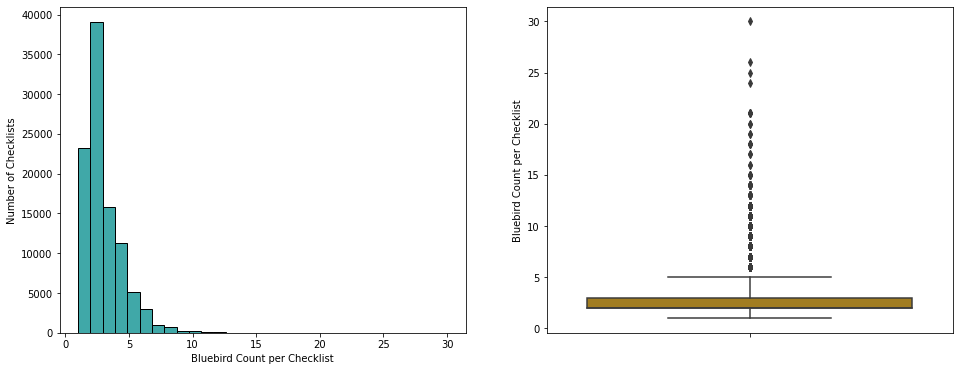

In [ ]:
plt.figure(figsize = (16,6))

plt.subplot(1, 2, 1)
sns.histplot(pivo[pivo['easblu'] > 0]['easblu'], bins=30, color='darkcyan')
plt.xlabel("Bluebird Count per Checklist")
plt.ylabel("Number of Checklists")

plt.subplot(1, 2, 2)
sns.boxplot(y = pivo[pivo['easblu'] > 0]['easblu'], whis = 2, color='darkgoldenrod').set(ylabel = "Bluebird Count per Checklist")

plt.show()

In [ ]:
pivo[pivo['easblu'] > 0]['easblu'].describe()

count    99836.0000000
mean         2.5675007
std          1.5550019
min          1.0000000
25%          2.0000000
50%          2.0000000
75%          3.0000000
max         30.0000000
Name: easblu, dtype: float64

In [ ]:
Q1 = pivo[pivo['easblu'] > 0]['easblu'].quantile(0.25)
Q3 = pivo[pivo['easblu'] > 0]['easblu'].quantile(0.75)
IQR = Q3 - Q1
Lower_Fence = Q1 - (2 * IQR)
Upper_Fence = Q3 + (2 * IQR)
print('Upper Fence: {}'.format(Upper_Fence))

Upper Fence: 5.0


The objective of this study is to model the presence/absence of the eastern bluebird.  As shown in the plots and descriptive statistics above, a bluebird is rarely observed in groups of 5 or more. Given the objective and the exploration of the bluebird data, the practical step is then to convert the bluebird target into a binary variable.

In [ ]:
# CATEGORIZING
# This method returns group numbers 
# given bird species observations per checklist 

def categorize(obs_num):
    if obs_num == 0:
        return 0
    else:
        return 1

In [ ]:
# Convert the bluebird target to a binary variable,
# where 0 indicates absence,
# and 1 indicates presence

pivo['easblu_bina'] = pivo['easblu'].apply(categorize)

print(pivo.groupby('easblu_bina')['easblu'].count())

easblu_bina
0    534100
1     99836
Name: easblu, dtype: int64


In [ ]:
zerobb = pivo.groupby('easblu_bina')['easblu'].count()[0]
onebb = pivo.groupby('easblu_bina')['easblu'].count()[1]
print('{} percent of records with no bluebird'.format(round(100*zerobb/(zerobb+onebb),1)))
print('{} percent of records with bluebird'.format(round(100*onebb/(zerobb+onebb),1)))

84.3 percent of records with no bluebird
15.7 percent of records with bluebird


The imbalance in the binary target, easblu_bina, will be improved in a later step.

In [ ]:
# List of bird species columns
spcs_list = [x for x in pivo.columns if x not in no_pivot]
drop_spcs = pivo[spcs_list].sum()[pivo[spcs_list].sum() == 0].tolist()
pivo = pivo.drop(columns = drop_spcs)
spcs_list = [x for x in pivo.columns if x not in no_pivot]

In [ ]:
print('Current number of sites in the data: {}'.format(pivo['loc_id'].nunique()))
print('\n')
print('Current number of bird species in the data: {}'.format(len(spcs_list)))
print('\n')
print('Current shape of the data: {}'.format(pivo.shape))

Current number of sites in the data: 14592


Current number of bird species in the data: 46


Current shape of the data: (633936, 64)


###U.S. Shape File: subset observation sites

Load the shape file of the U.S. and overlay the points of the PFW sites.

In [ ]:
# Shape file of the U.S.
local_path = 'tmp/'
z = zipfile.ZipFile(fdir + ushp)
z.extractall(path=local_path)   # Extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)

['cb_2018_us_state_20m.dbf', 'cb_2018_us_state_20m.prj', 'cb_2018_us_state_20m.shp', 'cb_2018_us_state_20m.shx']


In [ ]:
# Use a list comprehension to assign variable names to each of the four files,
# then read the shapefile into a geopandas dataframe.
# From here, check the number of records in the file and preview the data.

dbf, prj, shp, shx = [filename for filename in filenames]
usa = gpd.read_file(local_path + shp)
usa = usa.rename(columns={'STUSPS': 'state'})
print("Shape of the dataframe: {}".format(usa.shape))
print("Projection of dataframe: {}".format(usa.crs))
usa.sample(5)

Shape of the dataframe: (52, 10)
Projection of dataframe: epsg:4269


STATEFP   STATENS     AFFGEOID GEOID state        NAME LSAD          ALAND  \
32      32  01779793  0400000US32    32    NV      Nevada   00   284329506470   
16      41  01155107  0400000US41    41    OR      Oregon   00   248606993270   
25      02  01785533  0400000US02    02    AK      Alaska   00  1478839695958   
20      22  01629543  0400000US22    22    LA   Louisiana   00   111897594374   
12      06  01779778  0400000US06    06    CA  California   00   403503931312   

          AWATER                                           geometry  
32    2047206072  POLYGON ((-120.00480 39.31648, -120.00303 39.4...  
16    6192386935  POLYGON ((-124.55244 42.84057, -124.48094 42.9...  
25  245481577452  MULTIPOLYGON (((179.48132 51.97530, 179.58286 ...  
20   23753621895  POLYGON ((-94.04305 32.69303, -94.04303 32.797...  
12   20463871877  MULTIPOLYGON (((-118.59397 33.46720, -118.4847...

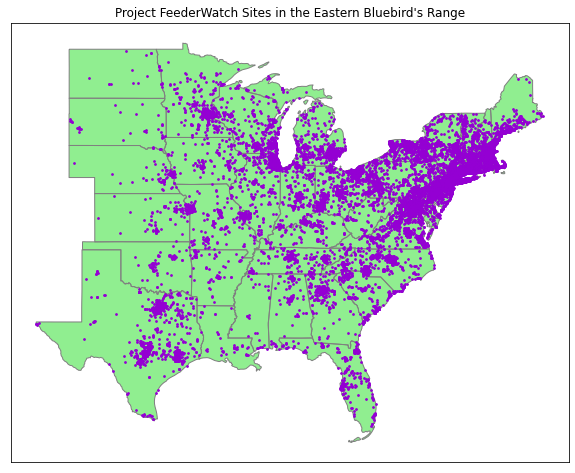

In [ ]:
pfwc = pivo.copy()

# Filter the usa shape dataframe to include only the states of the current set of PFW sites
states = pfwc['state'].unique()
usa_sub = usa[usa['state'].isin(states)]

# Create the point geometry of the PFW sites
long_lat = pfwc.groupby(['longitude', 'latitude']).count().reset_index()[['longitude', 'latitude']]
geometry = [Point(xy) for xy in zip(long_lat['longitude'], long_lat['latitude'])]
crs = {'init' : 'epsg:4326'}
geo_df = gpd.GeoDataFrame(long_lat, crs=crs, geometry=geometry)

# Plot the map with the PFW sites
plot_map(geo_df, (10,10), "Project FeederWatch Sites in the Eastern Bluebird's Range")

In [ ]:
# Convert the latitude and longitude coordinates’ columns into a two-dimensional numpy array, called coords
coords = long_lat[['latitude', 'longitude']].values

# Compute DBSCAN
# The epsilon parameter is the max distance that points can be from each other to be considered a cluster.
# The min_samples parameter is the minimum cluster size (everything else gets classified as noise).
# Set min_samples to 1 so that every data point gets assigned to either a cluster or forms its own cluster of 1. Nothing will be classified as noise.
# Use the haversine metric and ball tree algorithm to calculate great circle distances between points.
# Epsilon and coordinates get converted to radians, because scikit-learn’s haversine metric needs radian units.

kms_per_radian = 6371.0088
max_dist = 36
epsilon = max_dist / kms_per_radian
min_s = 24

db = DBSCAN(eps=epsilon, min_samples=min_s, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 40


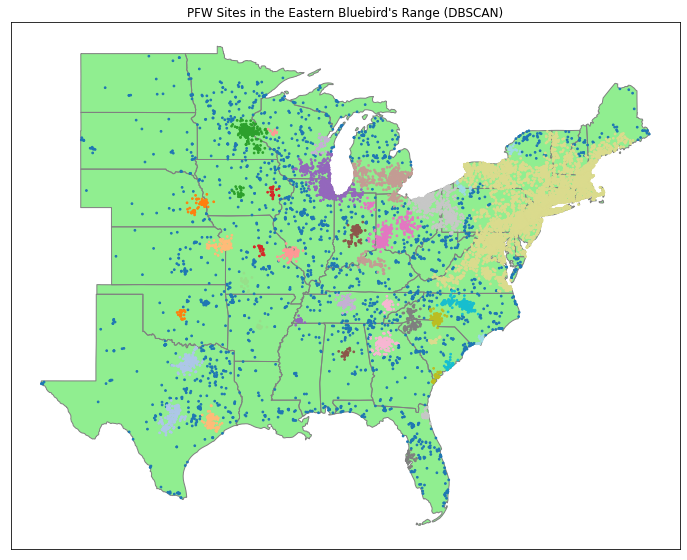

In [ ]:
# Add the cluster labels to the long_lat df
long_lat['cluster'] = pd.Series(cluster_labels)

# Create the point geometry of the PFW sites
geo_df = gpd.GeoDataFrame(long_lat, crs=crs, geometry=geometry)

# Plot the map with the PFW sites
ax = usa_sub.plot(figsize=(12,12), column='ALAND', color='lightgreen')
usa_sub.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=1)
geo_df.plot(ax=ax, markersize=3, categorical=True, column = 'cluster', vmin=cluster_labels.min(), vmax=cluster_labels.max(),
            marker='o', cmap='tab20', legend=False, legend_kwds={'loc': 'lower right', 'title': 'Cluster'})
ax.set(xticks=[], yticks=[])   # Removes axes
ax.set_title("PFW Sites in the Eastern Bluebird's Range (DBSCAN)", fontsize='large')
plt.show()

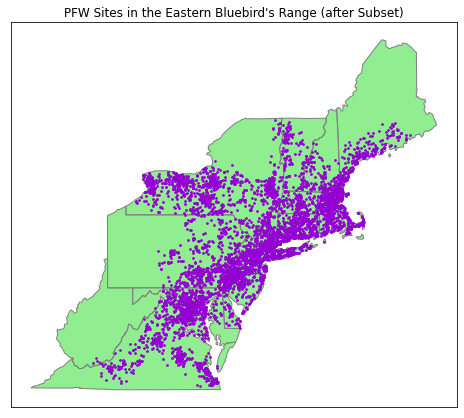

In [ ]:
# The point count of each cluster
list_labels = cluster_labels.tolist()
cluster_counts = dict(Counter(list_labels).items())

# Get the label of the largest cluster
max_cluster_size = max(cluster_counts.values())
lg_clus_idx = list(cluster_counts.values()).index(max_cluster_size)
lg_clus_label = list(cluster_counts.keys())[lg_clus_idx]

# Get the sites within the largest cluster
keep_locs = long_lat[long_lat.cluster == lg_clus_label][['longitude', 'latitude']]

# Use merge to subset the pfw dataframe by the sites within the large cluster
pfwd = pfwc.merge(keep_locs, how='right', on=['longitude', 'latitude'])

# Filter the geopandas dataframe to include 
# only the states touched by the large cluster.
usa_sub = usa[usa['state'].isin(list(pfwd.state.unique()))]

# Create the point geometry of the PFW sites
long_lat = pfwd.groupby(['longitude', 'latitude']).count().reset_index()[['longitude', 'latitude']]
geometry = [Point(xy) for xy in zip(long_lat['longitude'], long_lat['latitude'])]
geo_df = gpd.GeoDataFrame(long_lat, crs=crs, geometry=geometry)

# Plot the map with the PFW sites
plot_map(geo_df, (8,8), "PFW Sites in the Eastern Bluebird's Range (after Subset)")

In [ ]:
zerobb = pfwd.groupby("easblu_bina")["easblu"].count()[0]
onebb = pfwd.groupby("easblu_bina")["easblu"].count()[1]
print('Balance of binary target:')
print('\n')

print('{} percent with no bluebird'.format(round(100*zerobb/(zerobb+onebb),1)))
print('{} percent with bluebird'.format(round(100*onebb/(zerobb+onebb),1)))

Balance of binary target:


85.0 percent with no bluebird
15.0 percent with bluebird


Next, the balance of the target will be improved.

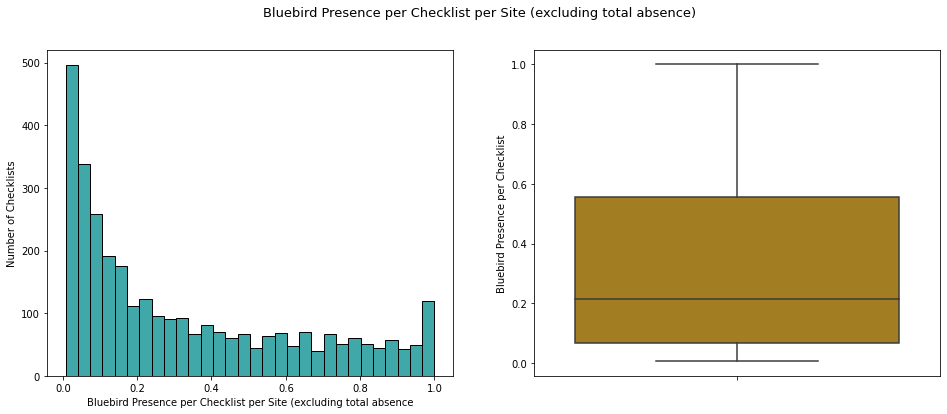

In [ ]:
sub_count = pfwd.groupby(['loc_id', 'latitude', 'longitude'])['sub_id'].count().reset_index()
blu_sum = pfwd.groupby(['loc_id', 'latitude', 'longitude'])['easblu_bina'].sum().reset_index()
blu_per_sub = sub_count.merge(blu_sum, how='inner', on=['loc_id', 'latitude', 'longitude'])
blu_per_sub['easblu_bina_per_sub_id'] = blu_per_sub['easblu_bina'] / blu_per_sub['sub_id']

plt.figure(figsize = (16,6))
plt.suptitle("Bluebird Presence per Checklist per Site (excluding total absence)", fontsize=13)

plt.subplot(1, 2, 1)
# Plot after excluding checklists with total bluebird absence 
sns.histplot(blu_per_sub[blu_per_sub.easblu_bina_per_sub_id > 0]['easblu_bina_per_sub_id'], bins=30, color='darkcyan')
plt.xlabel("Bluebird Presence per Checklist per Site (excluding total absence")
plt.ylabel("Number of Checklists")

plt.subplot(1, 2, 2)
# Plot after excluding checklists with total bluebird absence 
sns.boxplot(y = blu_per_sub[blu_per_sub.easblu_bina_per_sub_id > 0]['easblu_bina_per_sub_id'], whis = 2, color='darkgoldenrod').set(ylabel = "Bluebird Presence per Checklist")

plt.show()

In [ ]:
# Per-site descriptive statistics of:  (number of checklists with bluebird presence) / (total number of checklists)
# excluding sites with total bluebird absence
blu_per_sub[blu_per_sub.easblu_bina_per_sub_id > 0]['easblu_bina_per_sub_id'].describe()

count    3192.0000000
mean        0.3277383
std         0.3046155
min         0.0071429
25%         0.0672112
50%         0.2142857
75%         0.5555556
max         1.0000000
Name: easblu_bina_per_sub_id, dtype: float64

In [ ]:
thresh = blu_per_sub[blu_per_sub.easblu_bina_per_sub_id > 0]['easblu_bina_per_sub_id'].median()
thresh

0.21428571428571427

In [ ]:
# Create the point geometry of the PFW sites, including the easblu_bina column
long_lat = blu_per_sub.copy()
geometry = [Point(xy) for xy in zip(long_lat['longitude'], long_lat['latitude'])]
geo_df = gpd.GeoDataFrame(long_lat, crs=crs, geometry=geometry)

# CATEGORIZING
def categorize(num):
    if num <= thresh:
        return 'absence'
    else:
        return 'presence'

# Categorize bluebird observation by site:
# Total absence at the site over all PFW periods
# Or some presence at the site over all PFW periods

long_lat['easblu_bina'] = long_lat['easblu_bina_per_sub_id'].apply(categorize)

print("Balance of bluebird sites (threshold = {}% of checklists have presence)".format(100*round(thresh, 2)))
print(long_lat.groupby('easblu_bina')['longitude'].count())

Balance of bluebird sites (threshold = 21.0% of checklists have presence)
easblu_bina
absence     5383
presence    1591
Name: longitude, dtype: int64


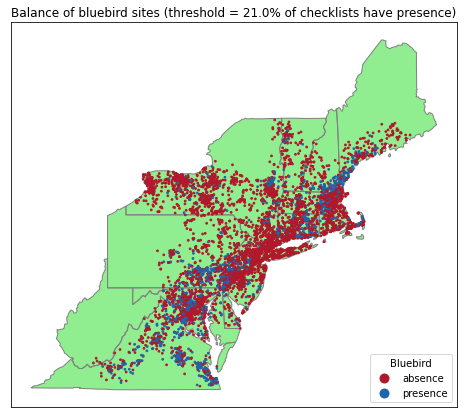

In [ ]:
# Plot the map with the PFW sites
# this time colored by the categorize bluebird observation by site

ax = usa_sub.plot(figsize=(8,8), column='ALAND', color='lightgreen')
usa_sub.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=1)
cmap = plt.get_cmap('RdBu')
cmap_tr = truncate_colormap(cmap, 0.1, 0.9)
geo_df.plot(ax=ax, markersize=3, categorical=True, column = 'easblu_bina',
            marker='o', cmap=cmap_tr, legend=True,
            legend_kwds={'loc': 'lower right', 'title': 'Bluebird'})
ax.set(xticks=[], yticks=[])   # Removes axes
ax.set_title("Balance of bluebird sites (threshold = {}% of checklists have presence)".format(100*round(thresh, 2)), fontsize='large')
plt.show()

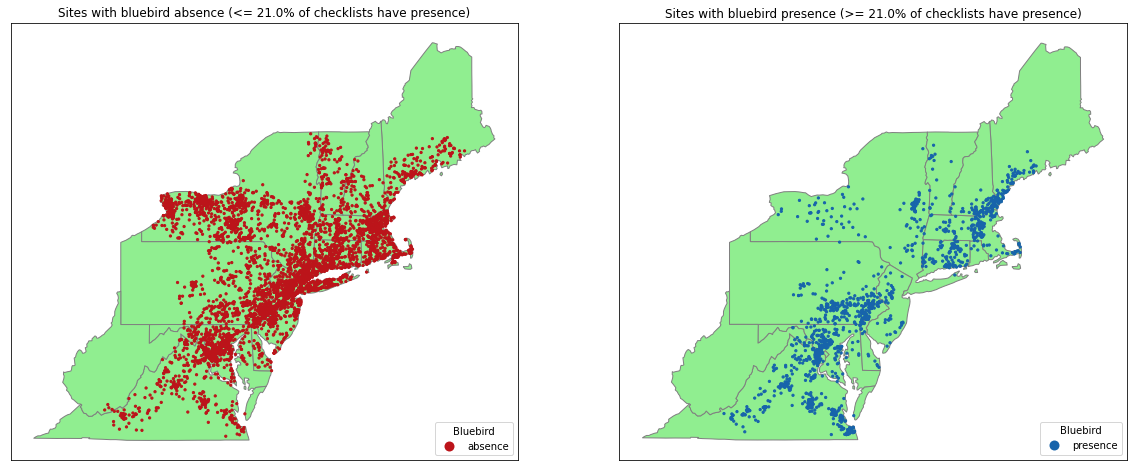

In [ ]:
long_lat_abs = long_lat[long_lat.easblu_bina == 'absence']
long_lat_pres = long_lat[long_lat.easblu_bina == 'presence']

fig, (ax1, ax2) = plt.subplots(figsize=(20,20), ncols=2, sharex=True, sharey=True)

ax1.set(xticks=[], yticks=[])   # Removes axes
ax1.set_title("Sites with bluebird absence (<= {}% of checklists have presence)".format(100*round(thresh, 2)), fontsize='large')
ax2.set(xticks=[], yticks=[])   # Removes axes
ax2.set_title("Sites with bluebird presence (>= {}% of checklists have presence)".format(100*round(thresh, 2)), fontsize='large')

usa_sub.plot(ax=ax1, column='ALAND', color='lightgreen', facecolor='none', edgecolor='gray', linewidth=1)
geometry = [Point(xy) for xy in zip(long_lat_abs['longitude'], long_lat_abs['latitude'])]
red_cmap = plt.get_cmap('Reds')
red_cmap_tr = truncate_colormap(red_cmap, 0.8, 0.9)
geo_df = gpd.GeoDataFrame(long_lat_abs, crs=crs, geometry=geometry)
geo_df.plot(ax=ax1, markersize=5, categorical=True, column = 'easblu_bina',
            marker='o', cmap=red_cmap_tr, legend=True,
            legend_kwds={'loc': 'lower right', 'title': 'Bluebird'})

usa_sub.plot(ax=ax2, column='ALAND', color='lightgreen', facecolor='none', edgecolor='gray', linewidth=1)
geometry = [Point(xy) for xy in zip(long_lat_pres['longitude'], long_lat_pres['latitude'])]
blue_cmap = plt.get_cmap('Blues')
blue_cmap_tr = truncate_colormap(blue_cmap, 0.8, 0.9)
geo_df = gpd.GeoDataFrame(long_lat_pres, crs=crs, geometry=geometry)
geo_df.plot(ax=ax2, markersize=5, categorical=True, column = 'easblu_bina',
            marker='o', cmap=blue_cmap_tr, legend=True,
            legend_kwds={'loc': 'lower right', 'title': 'Bluebird'})

plt.show()

In [ ]:
# Convert the latitude and longitude coordinates’ columns into a two-dimensional numpy array, called coords
coords = long_lat[['latitude', 'longitude']].values

# Compute DBSCAN
kms_per_radian = 6371.0088
max_dist = 9
epsilon = max_dist / kms_per_radian
min_s = 3

db = DBSCAN(eps=epsilon, min_samples=min_s, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 185


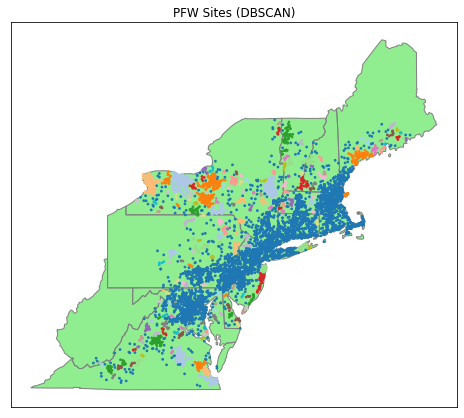

In [ ]:
# Add the cluster labels to the long_lat df
long_lat['cluster'] = pd.Series(cluster_labels)

# Create the point geometry of the PFW sites
geometry = [Point(xy) for xy in zip(long_lat['longitude'], long_lat['latitude'])]
geo_df = gpd.GeoDataFrame(long_lat, crs=crs, geometry=geometry)

# Plot the map with the PFW sites
ax = usa_sub.plot(figsize=(8,8), column='ALAND', color='lightgreen')
usa_sub.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=1)
geo_df.plot(ax=ax, markersize=3, categorical=True, column = 'cluster', vmin=cluster_labels.min(), vmax=cluster_labels.max(),
            marker='o', cmap='tab20', legend=False, legend_kwds={'loc': 'lower right', 'title': 'Cluster'})
ax.set(xticks=[], yticks=[])   # Removes axes
ax.set_title("PFW Sites (DBSCAN)", fontsize='large')
plt.show()

In [ ]:
clus_splits = long_lat.value_counts(['cluster', 'easblu_bina']).reset_index(name='count').sort_values('cluster')
listy = []
for ii in np.arange(0, clus_splits['cluster'].max()+1, 1):

    if clus_splits[(clus_splits.cluster == ii) & (clus_splits.easblu_bina == 'absence')].size == 0:
        absence = 0
    else:
        absence = clus_splits[(clus_splits.cluster == ii) & (clus_splits.easblu_bina == 'absence')]['count'].values[0]

    if clus_splits[(clus_splits.cluster == ii) & (clus_splits.easblu_bina == 'presence')].size == 0:
        presence = 0
    else:
        presence = clus_splits[(clus_splits.cluster == ii) & (clus_splits.easblu_bina == 'presence')]['count'].values[0]
    
    if (absence + presence > 20) and (100*absence/(absence + presence) > 60):
        listy.append(ii)

long_lat_most_abs = long_lat[long_lat.cluster.isin(listy)].reset_index()

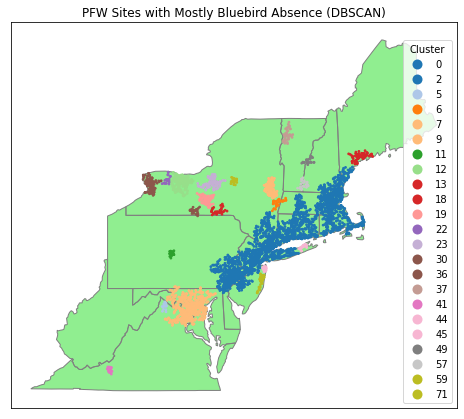

In [ ]:
# Create the point geometry of the PFW sites
geometry = [Point(xy) for xy in zip(long_lat_most_abs['longitude'], long_lat_most_abs['latitude'])]
geo_df = gpd.GeoDataFrame(long_lat_most_abs, crs=crs, geometry=geometry)

# Plot the map with the PFW sites
ax = usa_sub.plot(figsize=(8,8), column='ALAND', color='lightgreen')
usa_sub.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=1)
geo_df.plot(ax=ax, markersize=3, categorical=True, column = 'cluster', vmin=0, vmax=long_lat_most_abs['cluster'].nunique()+3,
            marker='o', cmap='tab20', legend=True, legend_kwds={'loc': 'lower right', 'title': 'Cluster'})
ax.set(xticks=[], yticks=[])   # Removes axes
ax.set_title("PFW Sites with Mostly Bluebird Absence (DBSCAN)", fontsize='large')
plt.show()

In [ ]:
# This function returns the centermost point from a cluster by taking a set of points (i.e., a cluster) 
# and returning the point within it that is nearest to some reference point (in this case, the cluster’s centroid).
# The function first calculates the centroid’s coordinates.
# Then use the min function to find the smallest member of the cluster in terms of distance to that centroid. 
# The key argument does this with a lambda function that calculates each point’s distance to the centroid in meters, via geopy’s great circle function. 
# Finally, return the coordinates of the point that was the least distance from the centroid.

def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return list(centermost_point)

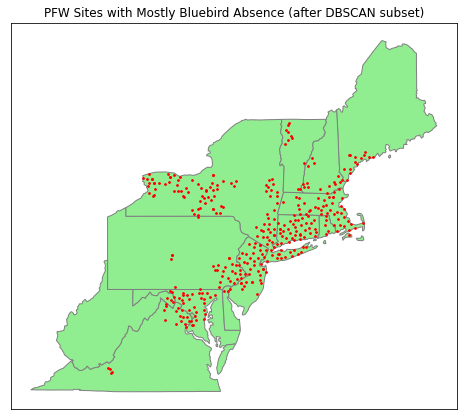

Iteration 617
DBSCAN, min_s = 3, max_dist = 13.11999999999981
Number of clusters: 2
Number of clusters with 3 to 5 points: 1
Number of sites after subset: 362


In [ ]:
long_lat_sub = long_lat_most_abs[long_lat_most_abs.easblu_bina == 'absence'].reset_index()

# Compute DBSCAN
max_dist = 0.3
max_dist_inc = 0.02
max_dist_break = 13
min_s = 3
kms_per_radian = 6371.0088

ii = 1

print("Number of sites before subset: {}".format(long_lat_sub.shape[0]))
print("\n")

while max_dist <= max_dist_break:
    epsilon = max_dist / kms_per_radian

    # Convert the latitude and longitude coordinates’ columns into a two-dimensional numpy array, called coords
    coords = long_lat_sub[['latitude', 'longitude']].values

    num_sites = long_lat_sub.shape[0]

    db = DBSCAN(eps=epsilon, min_samples=min_s, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
    long_lat_sub['cluster'] = pd.Series(cluster_labels)   # Add the cluster labels to the long_lat df
    clus_sizes = long_lat_sub.groupby('cluster')[['latitude', 'longitude']].count().reset_index()
    clus_sizes = clus_sizes[clus_sizes.cluster > -1]
    fewest_ppc = clus_sizes['latitude'].min()
    num_small_clus = clus_sizes[(clus_sizes.latitude >= fewest_ppc) & (clus_sizes.latitude <= fewest_ppc+2)].shape[0]

    while num_small_clus == 0:
        max_dist += max_dist_inc
        epsilon = max_dist / kms_per_radian
        db = DBSCAN(eps=epsilon, min_samples=min_s, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
        cluster_labels = db.labels_
        num_clusters = len(set(cluster_labels))
        clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
        long_lat_sub['cluster'] = pd.Series(cluster_labels)   # Add the cluster labels to the long_lat df
        clus_sizes = long_lat_sub.groupby('cluster')[['latitude', 'longitude']].count().reset_index()
        clus_sizes = clus_sizes[clus_sizes.cluster > -1]
        fewest_ppc = clus_sizes['latitude'].min()
        num_small_clus = clus_sizes[(clus_sizes.latitude >= fewest_ppc) & (clus_sizes.latitude <= fewest_ppc+2)].shape[0]
        
    clusters_sub = clusters[(clusters.map(len) >= fewest_ppc) & (clusters.map(len) <= fewest_ppc+2)]

    centermost_points = pd.DataFrame(item for item in clusters_sub.map(get_centermost_point))
    centermost_points.columns = ['latitude', 'longitude']

    long_lat_cmp = long_lat_sub.merge(centermost_points, on=['latitude', 'longitude'], how="right")
    long_lat_lg_clus = long_lat_sub.loc[~long_lat_sub.cluster.isin(long_lat_cmp.cluster.tolist())]
    long_lat_sub = pd.concat([long_lat_lg_clus, long_lat_cmp], ignore_index=True)

    # Create the point geometry of the PFW sites
    geometry_sub = [Point(xy) for xy in zip(long_lat_sub['longitude'], long_lat_sub['latitude'])]
    geo_df = gpd.GeoDataFrame(long_lat_sub, crs=crs, geometry=geometry_sub)

    # Plot the map with the PFW sites
    clear_output(wait=True) 
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    ax.set(xticks=[], yticks=[])   # Removes axes
    ax.set_title("PFW Sites with Mostly Bluebird Absence (after DBSCAN subset)", fontsize='large')
    usa_sub.plot(ax=ax, column='ALAND', color='lightgreen', facecolor='none', edgecolor='gray', linewidth=1)
    geo_df.plot(ax=ax, markersize=3, marker='o', color='red')
    plt.show()

    print("Iteration {}".format(ii))
    print("DBSCAN, min_s = {}, max_dist = {}".format(min_s, max_dist))
    print("Number of clusters: {}".format(num_clusters))
    print("Number of clusters with {} to {} points: {}".format(fewest_ppc, fewest_ppc+2, num_small_clus))
    print("Number of sites after subset: {}".format(long_lat_sub.shape[0]))

    if num_sites == long_lat_sub.shape[0]:
        max_dist += max_dist_inc

    ii +=1

In [ ]:
long_lat_prim = long_lat[~long_lat.cluster.isin(listy)].reset_index()
long_lat_sec_abs = long_lat_sub.copy()
long_lat_sec_pres = long_lat_most_abs[long_lat_most_abs.easblu_bina == 'presence'].reset_index()
long_lat_sub = pd.concat([long_lat_prim, long_lat_sec_abs, long_lat_sec_pres], ignore_index=True)

pfwe = pfwd.merge(long_lat_sub[['loc_id', 'latitude', 'longitude']], on=['loc_id', 'latitude', 'longitude'], how="right")

In [ ]:
zerobb = pfwe.groupby("easblu_bina")["easblu"].count()[0]
onebb = pfwe.groupby("easblu_bina")["easblu"].count()[1]
print('Balance of binary target:')
print('\n')

print('{} percent with no bluebird'.format(round(100*zerobb/(zerobb+onebb),1)))
print('{} percent with bluebird'.format(round(100*onebb/(zerobb+onebb),1)))

Balance of binary target:


70.9 percent with no bluebird
29.1 percent with bluebird


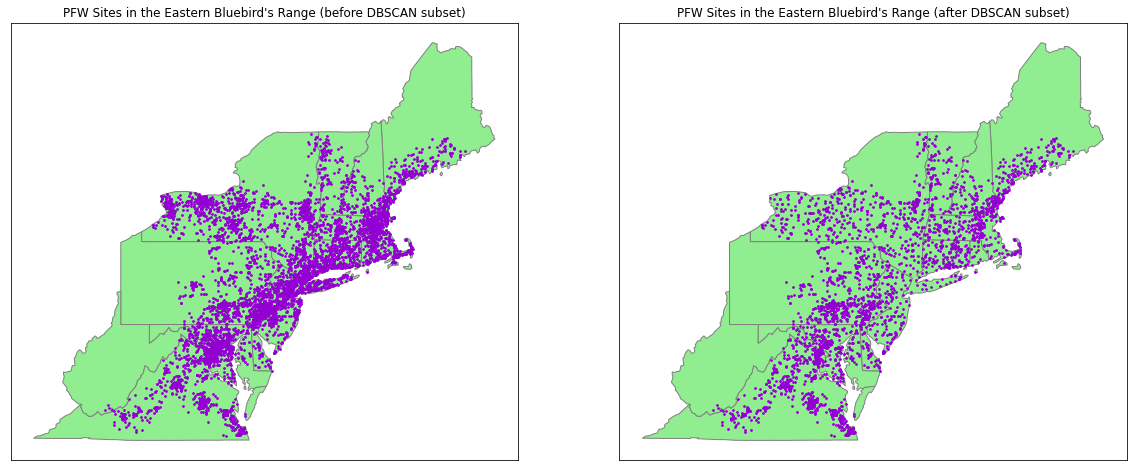

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(20,20), ncols=2, sharex=True, sharey=True)

ax1.set(xticks=[], yticks=[])   # Removes axes
ax1.set_title("PFW Sites in the Eastern Bluebird's Range (before DBSCAN subset)", fontsize='large')
ax2.set(xticks=[], yticks=[])   # Removes axes
ax2.set_title("PFW Sites in the Eastern Bluebird's Range (after DBSCAN subset)", fontsize='large')

usa_sub.plot(ax=ax1, column='ALAND', color='lightgreen', facecolor='none', edgecolor='gray', linewidth=1)
geometry = [Point(xy) for xy in zip(long_lat['longitude'], long_lat['latitude'])]
geo_df = gpd.GeoDataFrame(long_lat, crs=crs, geometry=geometry)
geo_df.plot(ax=ax1, markersize=3, color = 'darkviolet', marker='o')
usa_sub.plot(ax=ax2, column='ALAND', color='lightgreen', facecolor='none', edgecolor='gray', linewidth=1)
geometry_sub = [Point(xy) for xy in zip(long_lat_sub['longitude'], long_lat_sub['latitude'])]
geo_df = gpd.GeoDataFrame(long_lat_sub, crs=crs, geometry=geometry_sub)
geo_df.plot(ax=ax2, markersize=3, color = 'darkviolet', marker='o')

plt.show()

In [ ]:
# List of bird species columns
spcs_list = [x for x in pfwe.columns if x not in no_pivot]
drop_spcs = pfwe[spcs_list].sum()[pfwe[spcs_list].sum() == 0].tolist()
pfwe = pfwe.drop(columns = drop_spcs)
spcs_list = [x for x in pfwe.columns if x not in no_pivot]

In [ ]:
print('Current number of sites in the data: {}'.format(pfwe['loc_id'].nunique()))
print('\n')
print('Current number of bird species in the data: {}'.format(len(spcs_list)))
print('\n')
print('Current shape of the data: {}'.format(pfwe.shape))

Current number of sites in the data: 3186


Current number of bird species in the data: 46


Current shape of the data: (146530, 64)


###PFW Site Data: merge

Read in the PFW site description data, which will be merged with the PFW observation data.

In [ ]:
# pfwcount_site_data_public_2021.csv
sites = pd.read_csv(fdir + bsite)

In [ ]:
sites.sample(4)

loc_id proj_period_id  yard_type_pavement  yard_type_garden  \
241004   L81566       PFW_2001                 0.0               0.0   
57667    L19019       PFW_2006                 0.0               0.0   
79165   L229860       PFW_2011                 0.0               0.0   
88675   L242160       PFW_2017                 0.0               0.0   

        yard_type_landsca  yard_type_woods  yard_type_desert  hab_dcid_woods  \
241004                1.0              0.0               0.0             NaN   
57667                 1.0              1.0               0.0             0.0   
79165                 1.0              1.0               0.0             1.0   
88675                 0.0              1.0               0.0             1.0   

        hab_evgr_woods  hab_mixed_woods  ...  numfeeders_platfrm  \
241004             NaN              NaN  ...                 NaN   
57667              1.0              1.0  ...                 NaN   
79165              1.0              1.0  ...                 1.0   
88675              1.0              1.0  ...                 2.0   

        numfeeders_humming  numfeeders_water  numfeeders_thistle  \
241004                 NaN               NaN                 1.0   
57667                  NaN               NaN                 NaN   
79165                  2.0               NaN                 NaN   
88675                  0.0               NaN                 NaN   

        numfeeders_fruit  numfeeders_hopper  numfeeders_tube  \
241004               NaN                NaN              NaN   
57667                NaN                5.0              2.0   
79165                1.0                1.0              5.0   
88675                0.0                0.0              2.0   

        numfeeders_other  population_atleast  count_area_size_sq_m_atleast  
241004               NaN              5001.0                          1.01  
57667                1.0                 1.0                        100.01  
79165                1.0            100000.0                        100.01  
88675                0.0              5001.0                        100.01  

[4 rows x 62 columns]

In [ ]:
sites.shape

(254355, 62)

In [ ]:
# Remove the following columns,
# as they are redundant with the population and rural-urban data to be later aggregated.
srem = ['housing_density', 'population_atleast']
sites = sites.drop(columns = srem)

# Subset the site data by the loc_ids from the prepared observation dataset.
locs = list(pfwe['loc_id'].unique())
sites_b = sites[sites['loc_id'].isin(locs)]

# Then merge the PFW site description data with the PFW observation data
# on the loc_id and proj_period_id
pfwf = pfwe.merge(sites_b, how = 'left', on = ['loc_id', 'proj_period_id'])

# Make sure sub_id is the first column for ease of viewing the df
pfwf.insert(0, 'sub_id', pfwf.pop('sub_id'))

In [ ]:
pfwf.sample(4)

sub_id    loc_id    latitude   longitude  month  day  year  \
119629  S67890108  L2695870  38.7695260 -77.5986040      4   27  2020   
86921   S27691429  L1029160  41.9832411 -76.8082915      2   11  2016   
34244   S42209840  L2516665  42.6579420 -74.0361780      1   23  2018   
39197   S77662974  L3149583  39.9260989 -76.3589501     12   12  2020   

       proj_period_id  valid  reviewed  ...  numfeeders_hanging  \
119629       PFW_2020      1         0  ...                 NaN   
86921        PFW_2016      1         0  ...                 NaN   
34244        PFW_2018      1         0  ...                 NaN   
39197        PFW_2021      1         0  ...                 NaN   

        numfeeders_platfrm  numfeeders_humming  numfeeders_water  \
119629                 NaN                 NaN               NaN   
86921                  1.0                 NaN               NaN   
34244                  0.0                 0.0               NaN   
39197                  2.0                 0.0               NaN   

        numfeeders_thistle  numfeeders_fruit numfeeders_hopper  \
119629                 NaN               NaN               NaN   
86921                  NaN               NaN               1.0   
34244                  NaN               0.0               1.0   
39197                  NaN               0.0               2.0   

       numfeeders_tube  numfeeders_other  count_area_size_sq_m_atleast  
119629             NaN               NaN                           NaN  
86921              3.0               3.0                        100.01  
34244              0.0               0.0                        100.01  
39197              0.0               0.0                          1.01  

[4 rows x 122 columns]

In [ ]:
# List of non-bird_species columns
nospcs =  pd.unique(no_pivot + sites.columns.tolist()).tolist()

# List of bird species columns
spcs_list = [x for x in pfwf.columns if x not in nospcs]
drop_spcs = pfwf[spcs_list].sum()[pfwf[spcs_list].sum() == 0].tolist()
pfwf = pfwf.drop(columns = drop_spcs)
spcs_list = [x for x in pfwf.columns if x not in nospcs]

In [ ]:
print('Current number of sites in the data: {}'.format(pfwf['loc_id'].nunique()))
print('\n')
print('Current number of bird species in the data: {}'.format(len(spcs_list)))
print('\n')
print('Current shape of the data: {}'.format(pfwf.shape))

Current number of sites in the data: 3186


Current number of bird species in the data: 46


Current shape of the data: (146530, 122)


###PFW Site Data: explore, prep

All site data is unique to the loc_id; therefore, a loc_id's site data will be repeated across a loc_id's checklists.

First, check for NaNs in the site data.

In [ ]:
null_summary(pfwf)[:6]

null_names  null_counts  null_proportion null_dtypes
0  yard_type_pavement        25033        0.1708387     float64
1    yard_type_garden        25033        0.1708387     float64
2   yard_type_landsca        24832        0.1694670     float64
3     yard_type_woods        24987        0.1705248     float64
4    yard_type_desert        25033        0.1708387     float64
5      hab_dcid_woods        24797        0.1692281     float64

Have a look at the descriptive statistics of the yard types.

In [ ]:
yard_col = pfwf.filter(regex='yard').columns
pfwf[yard_col].describe()

yard_type_pavement  yard_type_garden  yard_type_landsca  \
count      121497.0000000    121497.0000000     121698.0000000   
mean            0.0008478         0.0177371          0.8921018   
std             0.0291041         0.1319947          0.3102531   
min             0.0000000         0.0000000          0.0000000   
25%             0.0000000         0.0000000          1.0000000   
50%             0.0000000         0.0000000          1.0000000   
75%             0.0000000         0.0000000          1.0000000   
max             1.0000000         1.0000000          1.0000000   

       yard_type_woods  yard_type_desert  
count   121543.0000000    121497.0000000  
mean         0.7580116         0.0003210  
std          0.4282891         0.0179135  
min          0.0000000         0.0000000  
25%          1.0000000         0.0000000  
50%          1.0000000         0.0000000  
75%          1.0000000         0.0000000  
max          1.0000000         1.0000000

The function, unique_summary, has been defined at the beginning of the notebook.  Given a dataframe and a list of columns within that dataframe, the function will return a dataframe summarizing the unique values of the columns.

Get the unique values of the yard types.

In [ ]:
unique_summary(pfwf, yard_col)

yard_type_pavement  yard_type_garden  yard_type_landsca  yard_type_woods  \
0                 0.0               0.0                1.0              1.0   
1                 NaN               NaN                0.0              0.0   
2                 1.0               1.0                NaN              NaN   

   yard_type_desert  
0               0.0  
1               NaN  
2               1.0

In [ ]:
# Count the unique (i.e., by loc_id) instances of each yard type in the data.
# Since site data is unique to the loc_id (i.e., a loc_id's site data will be repeated across a loc_id's checklists),
# the .agg('first') will just take the first row in the loc_id group, which is the same as all other rows in its group.

pfwf[['loc_id'] + list(yard_col)].groupby('loc_id').agg('first')[yard_col].sum()

yard_type_pavement       5.0
yard_type_garden        67.0
yard_type_landsca     2562.0
yard_type_woods       2122.0
yard_type_desert         1.0
dtype: float64

The yard variables are all binary (0 = absent, 1 = present).  Zero fill the NaNs.  Then remove the columns, yard_type_desert and yard_type_pavement, as they have entries for a negligible number of sites.

In [ ]:
pfwf[yard_col] = pfwf[yard_col].fillna(0)
pfwf = pfwf.drop(columns = ['yard_type_desert', 'yard_type_pavement'])

null_summary(pfwf)[:6]

null_names  null_counts  null_proportion null_dtypes
0   hab_dcid_woods        24797        0.1692281     float64
1   hab_evgr_woods        24942        0.1702177     float64
2  hab_mixed_woods        24577        0.1677267     float64
3      hab_orchard        24964        0.1703678     float64
4         hab_park        55356        0.3777793     float64
5  hab_water_fresh        24641        0.1681635     float64

Move on to the habitat types.

In [ ]:
hab_col = pfwf.filter(regex='hab_').columns
pfwf[hab_col].describe()

hab_dcid_woods  hab_evgr_woods  hab_mixed_woods     hab_orchard  \
count  121733.0000000  121588.0000000   121953.0000000  121566.0000000   
mean        0.5446017       0.1894430        0.8098366       0.0977576   
std         0.4980088       0.3918618        0.3924316       0.2969878   
min         0.0000000       0.0000000        0.0000000       0.0000000   
25%         0.0000000       0.0000000        1.0000000       0.0000000   
50%         1.0000000       0.0000000        1.0000000       0.0000000   
75%         1.0000000       0.0000000        1.0000000       0.0000000   
max         1.0000000       1.0000000        1.0000000       1.0000000   

            hab_park  hab_water_fresh  hab_water_salt  hab_residential  \
count  91174.0000000   121889.0000000   121537.000000   122024.0000000   
mean       0.2371729        0.6460140        0.049162        0.9121648   
std        0.4253515        0.4782068        0.216207        0.2830562   
min        0.0000000        0.0000000        0.000000        0.0000000   
25%        0.0000000        0.0000000        0.000000        1.0000000   
50%        0.0000000        1.0000000        0.000000        1.0000000   
75%        0.0000000        1.0000000        0.000000        1.0000000   
max        1.0000000        1.0000000        1.000000        1.0000000   

       hab_industrial  hab_agricultural  hab_desert_scrub  hab_young_woods  \
count  121618.0000000    121809.0000000    121497.0000000   121762.0000000   
mean        0.1525268         0.4358381         0.0011852        0.3845863   
std         0.3595322         0.4958682         0.0344067        0.4864994   
min         0.0000000         0.0000000         0.0000000        0.0000000   
25%         0.0000000         0.0000000         0.0000000        0.0000000   
50%         0.0000000         0.0000000         0.0000000        0.0000000   
75%         0.0000000         1.0000000         0.0000000        1.0000000   
max         1.0000000         1.0000000         1.0000000        1.0000000   

            hab_swamp       hab_marsh  
count  101530.0000000  121568.0000000  
mean        0.3760957       0.2137980  
std         0.4844069       0.4099876  
min         0.0000000       0.0000000  
25%         0.0000000       0.0000000  
50%         0.0000000       0.0000000  
75%         1.0000000       0.0000000  
max         1.0000000       1.0000000

In [ ]:
unique_summary(pfwf, hab_col)

hab_dcid_woods  hab_evgr_woods  hab_mixed_woods  hab_orchard  hab_park  \
0             0.0             0.0              1.0          0.0       1.0   
1             1.0             1.0              0.0          1.0       0.0   
2             NaN             NaN              NaN          NaN       NaN   

   hab_water_fresh  hab_water_salt  hab_residential  hab_industrial  \
0              1.0             0.0              1.0             0.0   
1              0.0             NaN              NaN             1.0   
2              NaN             1.0              0.0             NaN   

   hab_agricultural  hab_desert_scrub  hab_young_woods  hab_swamp  hab_marsh  
0               0.0               0.0              1.0        0.0        0.0  
1               1.0               NaN              0.0        1.0        1.0  
2               NaN               1.0              NaN        NaN        NaN

In [ ]:
pfwf[['loc_id'] + list(hab_col)].groupby('loc_id').agg('first')[hab_col].sum()

hab_dcid_woods      1521.0
hab_evgr_woods       539.0
hab_mixed_woods     2318.0
hab_orchard          282.0
hab_park             611.0
hab_water_fresh     1785.0
hab_water_salt       147.0
hab_residential     2667.0
hab_industrial       423.0
hab_agricultural    1184.0
hab_desert_scrub       7.0
hab_young_woods     1015.0
hab_swamp            894.0
hab_marsh            569.0
dtype: float64

The habitat variables are all binary (0 = absent, 1 = present).  Zero fill the NaNs. Then remove the column, hab_desert_scrub, as it has entries for a negligible number of sites.

In [ ]:
pfwf[hab_col] = pfwf[hab_col].fillna(0)
pfwf = pfwf.drop(columns = 'hab_desert_scrub')

null_summary(pfwf)[:6]

null_names  null_counts  null_proportion null_dtypes
0  evgr_trees_atleast        25185        0.1718761     float64
1  evgr_shrbs_atleast        25506        0.1740667     float64
2  dcid_trees_atleast        25023        0.1707705     float64
3  dcid_shrbs_atleast        25475        0.1738552     float64
4   fru_trees_atleast        25647        0.1750290     float64
5       cacti_atleast        26450        0.1805091     float64

Move on to the types of nearby trees.

In [ ]:
tree_col = pfwf.filter(regex='trees|shrbs|cacti').columns
pfwf[tree_col].describe()

evgr_trees_atleast  evgr_shrbs_atleast  dcid_trees_atleast  \
count      121345.0000000      121024.0000000      121507.0000000   
mean            4.2504924           3.7467940           7.1354737   
std             3.9347678           3.7948176           4.1016849   
min             0.0000000           0.0000000           0.0000000   
25%             1.0000000           1.0000000           4.0000000   
50%             4.0000000           4.0000000          11.0000000   
75%             4.0000000           4.0000000          11.0000000   
max            11.0000000          11.0000000          11.0000000   

       dcid_shrbs_atleast  fru_trees_atleast   cacti_atleast  
count      121055.0000000     120883.0000000  120080.0000000  
mean            5.8820454          2.5604427       0.0366173  
std             4.1795739          3.0980849       0.3654614  
min             0.0000000          0.0000000       0.0000000  
25%             4.0000000          1.0000000       0.0000000  
50%             4.0000000          1.0000000       0.0000000  
75%            11.0000000          4.0000000       0.0000000  
max            11.0000000         11.0000000      11.0000000

In [ ]:
unique_summary(pfwf, tree_col)

evgr_trees_atleast  evgr_shrbs_atleast  dcid_trees_atleast  \
0                11.0                 4.0                11.0   
1                 4.0                11.0                 1.0   
2                 1.0                 0.0                 4.0   
3                 0.0                 1.0                 NaN   
4                 NaN                 NaN                 0.0   

   dcid_shrbs_atleast  fru_trees_atleast  cacti_atleast  
0                11.0               11.0            0.0  
1                 4.0                4.0            NaN  
2                 1.0                0.0            4.0  
3                 NaN                1.0            1.0  
4                 0.0                NaN           11.0

These fields are ordinal categorical variables and represent the minimum number of trees or shrubs of various types around the site (categories: 0, 1-3, 4-10, >10).  Fill the NaNs with the mode.

In [ ]:
for col in tree_col:
    pfwf[col] = pfwf[col].fillna(pfwf[col].mode()[0])

null_summary(pfwf)[:6]

null_names  null_counts  null_proportion null_dtypes
0  brsh_piles_atleast        25618        0.1748311     float64
1  water_srcs_atleast        25792        0.1760186     float64
2  bird_baths_atleast        25291        0.1725995     float64
3      nearby_feeders        25343        0.1729543     float64
4           squirrels        24761        0.1689825     float64
5                cats        25375        0.1731727     float64

Move on to brush piles, water sources, and bird baths.

In [ ]:
brsh_col = pfwf.filter(regex='brsh_|water_sr|bird_bath').columns
pfwf[brsh_col].describe()

brsh_piles_atleast  water_srcs_atleast  bird_baths_atleast
count      120912.0000000      120738.0000000      121239.0000000
mean            1.2040658           0.3805099           0.8647300
std             1.5935897           0.6031755           0.7517861
min             0.0000000           0.0000000           0.0000000
25%             0.0000000           0.0000000           1.0000000
50%             1.0000000           0.0000000           1.0000000
75%             1.0000000           1.0000000           1.0000000
max            11.0000000          11.0000000          11.0000000

In [ ]:
unique_summary(pfwf, brsh_col)

brsh_piles_atleast  water_srcs_atleast  bird_baths_atleast
0                 0.0                 0.0                 1.0
1                 1.0                 1.0                 0.0
2                11.0                 NaN                 NaN
3                 NaN                 4.0                 4.0
4                 4.0                11.0                11.0

These fields are ordinal categorical and represent the minimum number of brush piles, water sources, and bird baths around the site (categories: 0, 1-3, 4-10, >10).  Fill the NaNs with the mode.

In [ ]:
for col in brsh_col:
    pfwf[col] = pfwf[col].fillna(pfwf[col].mode()[0])

null_summary(pfwf)[:6]

null_names  null_counts  null_proportion null_dtypes
0  nearby_feeders        25343        0.1729543     float64
1       squirrels        24761        0.1689825     float64
2            cats        25375        0.1731727     float64
3            dogs        25421        0.1734867     float64
4          humans        25019        0.1707432     float64
5    fed_yr_round        65985        0.4503173     float64

Move on to nearby feeders, squirrels, cats, dogs, and humans.

In [ ]:
nearby_col = pfwf.filter(regex='nearby_f|squir|cats|dogs|humans').columns
pfwf[nearby_col].describe()

nearby_feeders       squirrels            cats            dogs  \
count  121187.0000000  121769.0000000  121155.0000000  121109.0000000   
mean        0.4129486       0.8995475       0.3995873       0.4138586   
std         0.4923658       0.3006036       0.4898155       0.4925258   
min         0.0000000       0.0000000       0.0000000       0.0000000   
25%         0.0000000       1.0000000       0.0000000       0.0000000   
50%         0.0000000       1.0000000       0.0000000       0.0000000   
75%         1.0000000       1.0000000       1.0000000       1.0000000   
max         1.0000000       1.0000000       1.0000000       1.0000000   

               humans  
count  121511.0000000  
mean        0.7992527  
std         0.4005610  
min         0.0000000  
25%         1.0000000  
50%         1.0000000  
75%         1.0000000  
max         1.0000000

In [ ]:
unique_summary(pfwf, nearby_col)

nearby_feeders  squirrels  cats  dogs  humans
0             0.0        1.0   1.0   0.0     1.0
1             1.0        0.0   0.0   1.0     NaN
2             NaN        NaN   NaN   NaN     0.0

These fields represent:  
*  Present or absence of feeders (others than those maintained by the participant) within 90 m of the count site (0 = feeders absent, 1 = feeders present).
*  Do squirrels take food from feeders at least 3 times per week? Are cats, dogs, or humans active within 30 m of the feeders for at least 30 minutes 3 days per week (0 = no, 1 = yes)?

Zero fill the NaNs.

In [ ]:
pfwf[nearby_col] = pfwf[nearby_col].fillna(0)

null_summary(pfwf)[:6]

null_names  null_counts  null_proportion null_dtypes
0  fed_yr_round        65985        0.4503173     float64
1    fed_in_jan        25880        0.1766191     float64
2    fed_in_feb        25973        0.1772538     float64
3    fed_in_mar        25964        0.1771924     float64
4    fed_in_apr        26663        0.1819627     float64
5    fed_in_may        28930        0.1974340     float64

According to Cornell, the fed_yr_round field has not been consistently applied throughout the history of the project.  Remove the column for fed_yr_round.  Instead, the monthly fields will be used.  The monthly fields are binary (0 = no, 1 = yes) and represent the consistency of feeding -- the following question is asked for each month, "I provided food in my count site at least once per week."  Zero fill the NaNs of the monthly fields.

In [ ]:
pfwf = pfwf.drop(columns = 'fed_yr_round')

fed_col = pfwf.filter(regex='fed_in_').columns
pfwf[fed_col].describe()

fed_in_jan      fed_in_feb      fed_in_mar      fed_in_apr  \
count  120650.0000000  120557.0000000  120566.0000000  119867.0000000   
mean        0.9878326       0.9856251       0.9857257       0.9568188   
std         0.1096334       0.1190312       0.1186200       0.2032656   
min         0.0000000       0.0000000       0.0000000       0.0000000   
25%         1.0000000       1.0000000       1.0000000       1.0000000   
50%         1.0000000       1.0000000       1.0000000       1.0000000   
75%         1.0000000       1.0000000       1.0000000       1.0000000   
max         1.0000000       1.0000000       1.0000000       1.0000000   

           fed_in_may      fed_in_jun      fed_in_jul      fed_in_aug  \
count  117600.0000000  116636.0000000  116089.0000000  116161.0000000   
mean        0.8856973       0.8379403       0.8085434       0.8068543   
std         0.3181799       0.3685072       0.3934492       0.3947680   
min         0.0000000       0.0000000       0.0000000       0.0000000   
25%         1.0000000       1.0000000       1.0000000       1.0000000   
50%         1.0000000       1.0000000       1.0000000       1.0000000   
75%         1.0000000       1.0000000       1.0000000       1.0000000   
max         1.0000000       1.0000000       1.0000000       1.0000000   

           fed_in_sep      fed_in_oct      fed_in_nov      fed_in_dec  
count  116986.0000000  118516.0000000  121075.0000000  120826.0000000  
mean        0.8419554       0.9073290       0.9862482       0.9865675  
std         0.3647843       0.2899721       0.1164595       0.1151183  
min         0.0000000       0.0000000       0.0000000       0.0000000  
25%         1.0000000       1.0000000       1.0000000       1.0000000  
50%         1.0000000       1.0000000       1.0000000       1.0000000  
75%         1.0000000       1.0000000       1.0000000       1.0000000  
max         1.0000000       1.0000000       1.0000000       1.0000000

In [ ]:
unique_summary(pfwf, fed_col)

fed_in_jan  fed_in_feb  fed_in_mar  fed_in_apr  fed_in_may  fed_in_jun  \
0         1.0         1.0         1.0         1.0         1.0         1.0   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         0.0         0.0         0.0         0.0         0.0         0.0   

   fed_in_jul  fed_in_aug  fed_in_sep  fed_in_oct  fed_in_nov  fed_in_dec  
0         1.0         1.0         1.0         1.0         1.0         1.0  
1         NaN         NaN         NaN         NaN         NaN         NaN  
2         0.0         0.0         0.0         0.0         0.0         0.0

In [ ]:
pfwf[fed_col] = pfwf[fed_col].fillna(0)

null_summary(pfwf)[:12]

null_names  null_counts  null_proportion null_dtypes
0                numfeeders_suet        25406        0.1733843     float64
1              numfeeders_ground        28319        0.1932642     float64
2             numfeeders_hanging       146530        1.0000000     float64
3             numfeeders_platfrm        29129        0.1987921     float64
4             numfeeders_humming        31257        0.2133147     float64
5               numfeeders_water       146530        1.0000000     float64
6             numfeeders_thistle       146530        1.0000000     float64
7               numfeeders_fruit        31827        0.2172047     float64
8              numfeeders_hopper        26781        0.1827680     float64
9                numfeeders_tube        26142        0.1784072     float64
10              numfeeders_other        31334        0.2138402     float64
11  count_area_size_sq_m_atleast        24775        0.1690780     float64

The fields, numfeeders_hanging, numfeeders_water, and numfeeders_thistle, are 100% null.  Remove them.

In [ ]:
pfwf = pfwf.drop(columns = ['numfeeders_hanging', 'numfeeders_water', 'numfeeders_thistle'])

nfeed_col = pfwf.filter(regex='numfeeders_').columns
pfwf[nfeed_col].describe()

numfeeders_suet  numfeeders_ground  numfeeders_platfrm  \
count   121124.0000000     118211.0000000      117401.0000000   
mean         1.8148839          1.0928509           0.7337416   
std          1.2795723          1.0988873           0.9925018   
min          0.0000000          0.0000000           0.0000000   
25%          1.0000000          0.0000000           0.0000000   
50%          2.0000000          1.0000000           1.0000000   
75%          2.0000000          2.0000000           1.0000000   
max         34.0000000         22.0000000          22.0000000   

       numfeeders_humming  numfeeders_fruit  numfeeders_hopper  \
count      115273.0000000    114703.0000000     119749.0000000   
mean            0.3913319         0.1111392          1.2322775   
std             0.8475624         0.8359605          1.3969191   
min             0.0000000         0.0000000          0.0000000   
25%             0.0000000         0.0000000          0.0000000   
50%             0.0000000         0.0000000          1.0000000   
75%             0.0000000         0.0000000          2.0000000   
max             8.0000000        82.0000000         16.0000000   

       numfeeders_tube  numfeeders_other  
count   120388.0000000    115196.0000000  
mean         2.1708476         0.5185076  
std          1.8215058         0.9742888  
min          0.0000000         0.0000000  
25%          1.0000000         0.0000000  
50%          2.0000000         0.0000000  
75%          3.0000000         1.0000000  
max         41.0000000        14.0000000

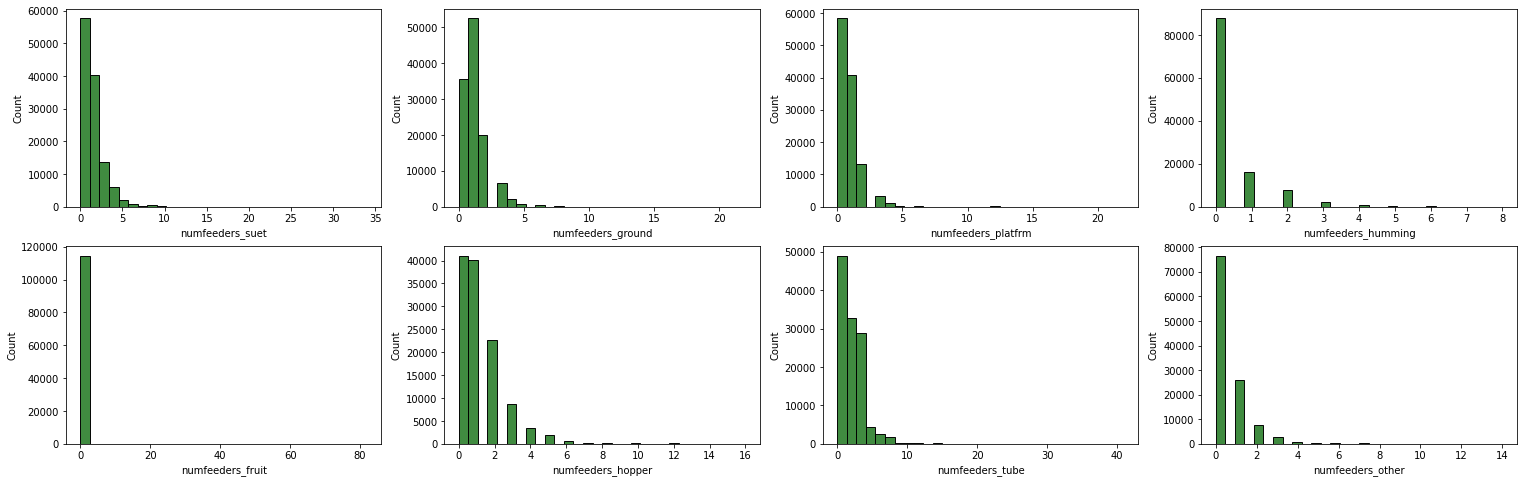

In [ ]:
plt.figure(figsize=(26,8))
plt.tight_layout

for idx, col in enumerate(nfeed_col):
  plt.subplot(2, 4, idx+1)
  sns.histplot(data=pfwf, bins=30, x=col, color='darkgreen')

plt.show()

These other feeder counts are continuous variables.  In this case, it's reasonable to think that a NaN indicates the absence of the feeder type.  Zero fill the NaNs.

In [ ]:
pfwf[nfeed_col] = pfwf[nfeed_col].fillna(0)

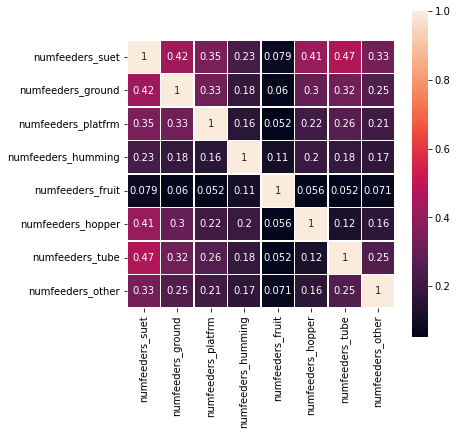

In [ ]:
plt.figure(figsize=(6, 6))

sns.heatmap(pfwf[nfeed_col].corr(), square=True, annot=True, linewidth = 0.5)

plt.show()

The heat map shows some moderate correlations between feeder types.

In [ ]:
null_summary(pfwf)

null_names  null_counts  null_proportion null_dtypes
0  count_area_size_sq_m_atleast        24775         0.169078     float64

In [ ]:
area_col = 'count_area_size_sq_m_atleast'
pfwf[area_col].describe()

count    121755.0000000
mean        142.4611601
std         140.5819565
min           0.0100000
25%           1.0100000
50%         100.0100000
75%         375.0100000
max         375.0100000
Name: count_area_size_sq_m_atleast, dtype: float64

In [ ]:
pfwf[area_col].unique().tolist()

[375.01, 1.01, 100.01, nan, 0.01]

The area field is the estimated area of the survey site.  It is also an ordinal categorical variable.
*  0.01:  < 1 square meter
*  1.01:  1 to 100 square meters
*  100.01:  100 - 375 square meters
*  375.01:  > 375 square meters

Fill the area NaNs with the mode. 

In [ ]:
pfwf[area_col] = pfwf[area_col].fillna(pfwf[area_col].mode()[0])

null_summary(pfwf)

Empty DataFrame
Columns: [null_names, null_counts, null_proportion, null_dtypes]
Index: []

No more NaNs remain.

In [ ]:
# List of non-bird_species columns
nospcs =  pd.unique(no_pivot + sites.columns.tolist()).tolist()

In [ ]:
# List of bird species columns
spcs_list = [x for x in pfwf.columns if x not in nospcs]
drop_spcs = pfwf[spcs_list].sum()[pfwf[spcs_list].sum() == 0].tolist()
pfwf = pfwf.drop(columns = drop_spcs)
spcs_list = [x for x in pfwf.columns if x not in nospcs]

In [ ]:
print('Current number of sites in the data: {}'.format(pfwf['loc_id'].nunique()))
print('\n')
print('Current number of bird species in the data: {}'.format(len(spcs_list)))
print('\n')
print('Current shape of the data: {}'.format(pfwf.shape))

Current number of sites in the data: 3186


Current number of bird species in the data: 46


Current shape of the data: (146530, 115)


###Aggregation with Population, Rural-Urban, and Weather Data

In [ ]:
# Write the latitudes and longitudes of the sites to a csv 
# for mapping to population, rural-urban, and weather data
locs = pfwf.groupby(['latitude', 'longitude']).count().reset_index()[['latitude', 'longitude']]

locs.to_csv(fdir + "weather_data/" + 'locs.csv')

In [ ]:
# Write the prepped data to a csv
pfwf.to_csv(fdir + "weather_data/" + 'pfw_prepped.csv')

The PFW data has been aggregated with population, rural-urban, and weather data in another notebook.  Read in that aggregated dataset here.

In [ ]:
bird = pd.read_csv(fdir + "aggregated_data.csv")
bird = bird.drop(columns = 'Unnamed: 0')

bird.iloc[:3, -9:].head()

count_area_size_sq_m_atleast  ruc_2013  uic_2013  pop_est  land_area  \
0                        375.01         4         5  53336.0    1283.26   
1                        375.01         4         5  53336.0    1283.26   
2                        375.01         4         5  53336.0    1283.26   

   water_area  tmin  tmax  pcpn  
0       96.89    23    37  0.26  
1       96.89    29    38  0.87  
2       96.89    32    47  0.00

As shown above, the newly aggregated features include:
*  From the USDA, Rural-Urban Continuum Codes (ruc_2013) and Urban-Influence Codes (uic_2013) at the county level.
*  2015-2021 population estimates by county (pop_est) from the U.S. Census.
*  Land and water area by county (land_area, water_area), from the U.S. Census.
*  Daily minimum and maximumum temperatures, and precipitation (tmin, tmax, pcpn) extracted using the Applied Climate Information System (ACIS).

For all county data, the data was aggregated by mapping the latitudes and longitudes from the bird observation sites to the county centroids.

Additionally, the 2015-2021 population estimates by county were mapped to the PFW data by year.

The ACIS data is gridded daily weather data.  The PFW sites were mapped to the nearest grid points, as well as merged on month, day, and year, in order to extract the local daily Tmin, Tmax, and precipitation.   

Instead of individual features for land area and population at the county level, a better metric for this study is population density.  Create a feature for population density by dividing population by land area. Then drop the columns, pop_est_2020 and land_area.

In [ ]:
bird['pop_dens'] = bird['pop_est'] / bird['land_area']

bird = bird.drop(columns = ['pop_est', 'land_area'])

bird.iloc[:3, -9:].head()

numfeeders_other  count_area_size_sq_m_atleast  ruc_2013  uic_2013  \
0               0.0                        375.01         4         5   
1               0.0                        375.01         4         5   
2               0.0                        375.01         4         5   

   water_area  tmin  tmax  pcpn    pop_dens  
0       96.89    23    37  0.26  41.5628945  
1       96.89    29    38  0.87  41.5628945  
2       96.89    32    47  0.00  41.5628945

In [ ]:
# In a list, keep track of the columns added for the population, rural-urban, and weather data
popwthr = ['ruc_2013', 'uic_2013', 'water_area', 'tmin', 'tmax', 'pcpn', 'pop_dens']

In [ ]:
# List of non-bird_species columns
nospcs =  pd.unique(no_pivot + sites.columns.tolist() + popwthr).tolist()

In [ ]:
# List of bird species columns
spcs_list = [x for x in bird.columns if x not in nospcs]
drop_spcs = bird[spcs_list].sum()[bird[spcs_list].sum() == 0].tolist()
bird = bird.drop(columns = drop_spcs)
spcs_list = [x for x in bird.columns if x not in nospcs]

In [ ]:
print('Current number of sites in the data: {}'.format(bird['loc_id'].nunique()))
print('\n')
print('Current number of bird species in the data: {}'.format(len(spcs_list)))
print('\n')
print('Current shape of the data: {}'.format(bird.shape))

Current number of sites in the data: 3186


Current number of bird species in the data: 46


Current shape of the data: (146530, 122)


In [ ]:
null_summary(bird)

Empty DataFrame
Columns: [null_names, null_counts, null_proportion, null_dtypes]
Index: []

###Further Data Exploration

Explore total bird counts per checklist (sub_id).

In [ ]:
total_per_ckl = bird.groupby('sub_id').sum()[spcs_list].sum(axis=1)

total_per_ckl.describe()

count    146530.0000000
mean         44.6447280
std          29.0343941
min           1.0000000
25%          25.0000000
50%          38.0000000
75%          57.0000000
max         725.0000000
dtype: float64

All checklists have at least 1 bird.

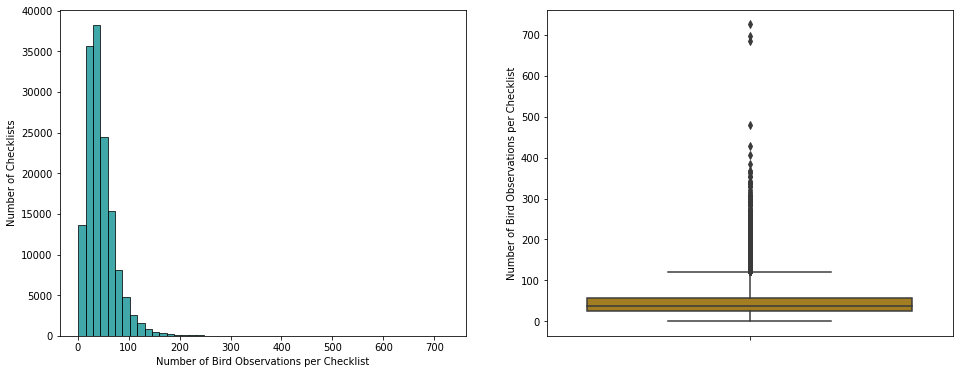

In [ ]:
plt.figure(figsize = (16,6))

plt.subplot(1, 2, 1)
sns.histplot(total_per_ckl, bins=50, color='darkcyan')
plt.xlabel("Number of Bird Observations per Checklist")
plt.ylabel("Number of Checklists")

plt.subplot(1, 2, 2)
sns.boxplot(y = total_per_ckl, whis = 2, color='darkgoldenrod').set(ylabel = "Number of Bird Observations per Checklist")

plt.show()

In [ ]:
Q1 = total_per_ckl.quantile(0.25)
Q3 = total_per_ckl.quantile(0.75)
IQR = Q3 - Q1
Lower_Fence = Q1 - (2 * IQR)
Upper_Fence = Q3 + (2 * IQR)
print('Upper Fence: {}'.format(Upper_Fence))

Upper Fence: 121.0


Per checklist, consider any bird count over 121 to be an outlier.

In [ ]:
# Remove checklists that have more than 121 bird observations
rem_sub_id = list(total_per_ckl[total_per_ckl > Upper_Fence].index)

bird = bird[~bird['sub_id'].isin(rem_sub_id)]

After the subset by bird count per checklist:

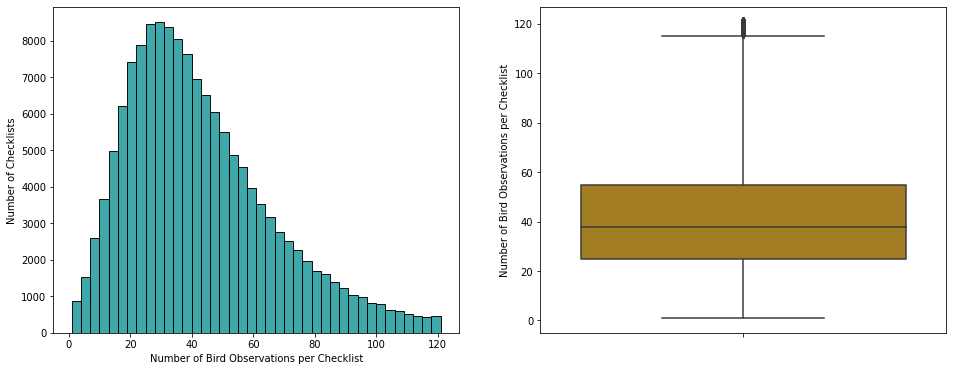

In [ ]:
new_total_per_ckl = bird.groupby('sub_id').sum()[spcs_list].sum(axis=1)

plt.figure(figsize = (16,6))

plt.subplot(1, 2, 1)
sns.histplot(new_total_per_ckl, bins=40, color='darkcyan')
plt.xlabel("Number of Bird Observations per Checklist")
plt.ylabel("Number of Checklists")

plt.subplot(1, 2, 2)
sns.boxplot(y = new_total_per_ckl, whis = 2, color='darkgoldenrod').set(ylabel = "Number of Bird Observations per Checklist")

plt.show()

In [ ]:
# List of non-bird_species columns
nospcs =  pd.unique(no_pivot + sites.columns.tolist() + popwthr).tolist()

In [ ]:
# List of bird species columns
spcs_list = [x for x in bird.columns if x not in nospcs]
drop_spcs = bird[spcs_list].sum()[bird[spcs_list].sum() == 0].tolist()
bird = bird.drop(columns = drop_spcs)
spcs_list = [x for x in bird.columns if x not in nospcs]

In [ ]:
print('Current number of sites in the data: {}'.format(bird['loc_id'].nunique()))
print('\n')
print('Current number of bird species in the data: {}'.format(len(spcs_list)))
print('\n')
print('Current shape of the data: {}'.format(bird.shape))

Current number of sites in the data: 3186


Current number of bird species in the data: 46


Current shape of the data: (143368, 122)


In [ ]:
zerobb = bird.groupby("easblu_bina")["easblu"].count()[0]
onebb = bird.groupby("easblu_bina")["easblu"].count()[1]
print('{} percent with no bluebird'.format(round(100*zerobb/(zerobb+onebb),1)))
print('{} percent with bluebird'.format(round(100*onebb/(zerobb+onebb),1)))

71.2 percent with no bluebird
28.8 percent with bluebird


Correlations of other bird species with the target, easblu_gr:

In [ ]:
bcorr = bird[spcs_list].corr()['easblu_bina'].sort_values(key=pd.Series.abs, ascending=False)
bcorr

easblu_bina    1.0000000
easblu         0.8103202
carwre         0.2446404
rebwoo         0.1906053
bkcchi        -0.1850507
norfli         0.1772782
yerwar         0.1671040
carchi         0.1519587
pinwar         0.1384014
houfin         0.1307043
dowwoo         0.1156404
normoc         0.1132205
brnthr         0.0978109
pilwoo         0.0940725
chispa         0.0939316
blujay        -0.0894691
whtspa         0.0884685
amerob         0.0882651
houspa        -0.0874466
yebsap         0.0804511
ruckin         0.0770269
eastow         0.0752750
amtspa        -0.0739883
sonspa         0.0719917
brncre         0.0695352
norcar         0.0677605
amegfi         0.0627700
eursta         0.0615059
amecro         0.0612577
pinsis         0.0601435
whbnut         0.0600902
bnhnut         0.0583226
coohaw         0.0556215
rewbla         0.0506375
y00033         0.0501553
moudov        -0.0484863
tuftit         0.0428056
bnhcow         0.0362266
wiltur        -0.0328641
comgra         0.0228611


In [ ]:
# Remove any bird species that has lower than min_corr correlation with the target
min_corr = 0.01

remcorr = list(bcorr[np.abs(bcorr) < min_corr].index)
bird = bird.loc[:, ~bird.columns.isin(remcorr)]

In [ ]:
# Get a list of variables that will not be used in the model
excl_vars = ['loc_id', 'state', 'sub_id', 'proj_period_id', 'valid', 'reviewed', 'datetime', 'easblu']

# Create a df of independent variables
X = bird.loc[:, ~bird.columns.isin(excl_vars + ['easblu_gr'])]

# Then look into the correlations among independent variables.
# The function, get_top_abs_correlations, has been defined at 
# the beginning of the notebook.  
# It returns correlations between all pairs of variables in the df.
get_top_abs_correlations(X)

fed_in_jan  fed_in_feb    0.9889973
fed_in_jul  fed_in_aug    0.9756583
fed_in_feb  fed_in_mar    0.9741245
fed_in_jan  fed_in_mar    0.9718978
            fed_in_dec    0.9465794
                            ...    
purfin      dogs          0.0000369
day         pilwoo        0.0000346
houspa      fed_in_aug    0.0000224
bkcchi      fed_in_dec    0.0000196
humans      pcpn          0.0000191
Length: 6105, dtype: float64

Due to high correlations, reintroduce fed_yr_round as a binary variable based on the monthly variables.

First, sum the monthly feed values across the columns (axis=1).  

In [ ]:
fed_col = list(fed_col)
bird['fed_yr_round'] = bird[fed_col].sum(axis=1)

Then, if the sum equals 12, set fed_yr_round to 1, else set it to 0.

In [ ]:
# CATEGORIZING
def categorize(fed_num):
    if fed_num == 12:
        return 1
    else:
        return 0

In [ ]:
bird['fed_yr_round'] = bird['fed_yr_round'].apply(categorize)
print(bird.groupby("fed_yr_round")["sub_id"].count())

fed_yr_round
0    55063
1    88305
Name: sub_id, dtype: int64


In [ ]:
bird[fed_col+['fed_yr_round']].sample(4)

fed_in_jan  fed_in_feb  fed_in_mar  fed_in_apr  fed_in_may  \
78290          1.0         1.0         1.0         1.0         1.0   
110123         1.0         1.0         1.0         1.0         1.0   
706            1.0         1.0         1.0         1.0         1.0   
66564          1.0         1.0         1.0         1.0         1.0   

        fed_in_jun  fed_in_jul  fed_in_aug  fed_in_sep  fed_in_oct  \
78290          1.0         1.0         1.0         1.0         1.0   
110123         1.0         1.0         1.0         1.0         1.0   
706            1.0         1.0         1.0         1.0         1.0   
66564          1.0         1.0         1.0         1.0         1.0   

        fed_in_nov  fed_in_dec  fed_yr_round  
78290          1.0         1.0             1  
110123         1.0         1.0             1  
706            1.0         1.0             1  
66564          1.0         1.0             1

Drop the monthly feed variables.

In [ ]:
bird = bird.drop(columns = fed_col)

Recheck the correlations.

In [ ]:
X = bird.loc[:, ~bird.columns.isin(excl_vars + ['easblu_gr'])]
get_top_abs_correlations(X)

ruc_2013           uic_2013           0.9130441
tmin               tmax               0.8219532
latitude           longitude          0.7258336
yard_type_landsca  hab_residential    0.6510675
hab_residential    squirrels          0.6398516
                                        ...    
brnthr             tuftit             0.0000577
hab_industrial     tmin               0.0000393
purfin             dogs               0.0000369
day                pilwoo             0.0000346
humans             pcpn               0.0000191
Length: 4950, dtype: float64

The rural-urban continuum codes (ruc_2013) and the urban-influence codes (uic_2013) are very similar metrics in defining rural vs. urban counties.  They are showing high correlation with each other.  Drop uic_2013.

In [ ]:
bird = bird.drop(columns = 'uic_2013')

The next section will look into the temporal distribution of the data.

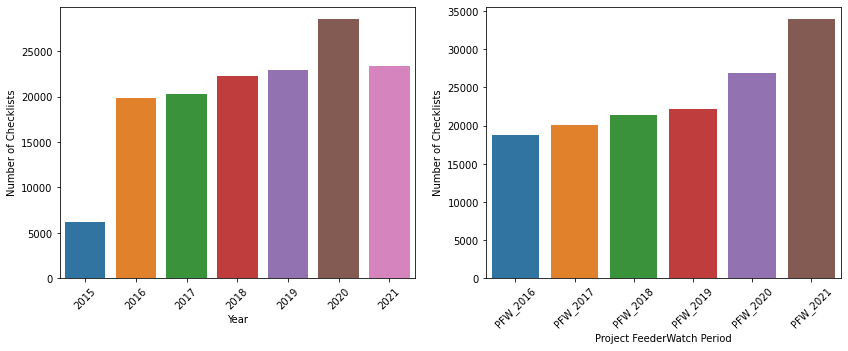

Months of Project FeederWatch: [11, 12, 1, 2, 3, 4]


In [ ]:
plt.figure(figsize = (14,5))

gbyear = bird.groupby('year').count()['sub_id']
gbseas = bird.groupby('proj_period_id').count()['sub_id']

plt.subplot(1, 2, 1)
sns.barplot(gbyear.index, gbyear)
plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Number of Checklists")

plt.subplot(1, 2, 2)
sns.barplot(gbseas.index, gbseas)
plt.xticks(rotation=45)
plt.xlabel("Project FeederWatch Period")
plt.ylabel("Number of Checklists")

plt.show()

print("Months of Project FeederWatch: {}".format(list(bird['month'].unique())))

The above bar plots show the difference between the actual year and the Project FeederWatch period. Each Project FeederWatch period runs from November through the following April, and is denoted by the year in which the period ends.  As a result, the data spans 7 years but only 6 periods, with the bounding years, 2015 and 2021, only partially represented in the data.  The number of checklists is therefore more uniform across periods than it is across years.  

For this reason, the project period will be the primary unit of time for modeling, and the following features will be created:
*  The month, day, and year variables will not be used in the model.  Instead, they will be replaced with a variable that represents the number of days from the start of each period, which is Nov. 1st.
*  The proj_period_id field will be categorized into a new variable to be included in the model.   

Create a column for day_in_period and populate it based on the start date of Nov. 1st for each period.

In [ ]:
bird['datetime'] = bird['datetime'].astype('datetime64')

In [ ]:
df_list = []

for per in periods:

    # Set the period start date to Nov. 1st for each period
    start = datetime.strptime(str(int(per[-4:])-1)+'-11-01', '%Y-%m-%d')

    # The df filtered on one period
    df = bird[bird['proj_period_id'] == per]
    
    # day_in_period = number of days from the period start
    df['day_in_period'] = df['datetime'] - start
    df_list.append(df)

bird = pd.concat(df_list, ignore_index=True)
bird['day_in_period'] = pd.to_numeric(bird['day_in_period'].dt.days, downcast='integer')
bird['day_in_period'] = bird['day_in_period'] + 1

Next, categorize the project periods into a numeric variable by stripping off the last two digits in proj_period_id.

In [ ]:
# CATEGORIZING
def categorize(period):
    return int(period[-2:])

In [ ]:
bird['proj_period'] = bird['proj_period_id'].apply(categorize)

The result:

In [ ]:
bird[['datetime', 'day_in_period', 'proj_period_id', 'proj_period']].sample(4)

datetime  day_in_period proj_period_id  proj_period
51844  2018-01-23             84       PFW_2018           18
18863  2017-01-09             70       PFW_2017           17
57229  2017-12-27             57       PFW_2018           18
103218 2020-03-15            136       PFW_2020           20

Break each PFW period into smaller periods equivalent to about a week.

In [ ]:
(datetime.strptime('2016-04-30', '%Y-%m-%d') - datetime.strptime('2015-11-01', '%Y-%m-%d'))

datetime.timedelta(days=181)

In [ ]:
(datetime.strptime('2016-04-30', '%Y-%m-%d') - datetime.strptime('2015-11-01', '%Y-%m-%d')) % pd.Timedelta('6 days')

Timedelta('1 days 00:00:00')

For each PFW period, the 181 days will be split into 6-day periods.  The number 6 is chosen because 181 % 6 = 1 (the extra day will be added to the last period). 

In [ ]:
# For each PFW period, the 6-day ranges will be stored in a list (dt_ranges).
# Then that list will be accessed with .loc to assign a 6-day period number to each record.

bird['six_day_period'] = np.nan

for ii in np.arange(0, 6):
    firstDate = datetime.strptime(str(2015+ii)+"-11-01", "%Y-%m-%d")
    lastDate = datetime.strptime(str(2016+ii)+"-04-30", "%Y-%m-%d")
    numberOfDays = 6
    startdate = firstDate
    startdatelist = []
    enddatelist = []
    dt_ranges = []

    while startdate <= lastDate:
        enddate = startdate + timedelta(days=numberOfDays - 1)
        startdatelist.append(startdate.strftime("%Y-%m-%d 00:00:00"))

        if (lastDate - enddate) < timedelta(days=numberOfDays): 
            enddatelist.append(lastDate.strftime("%Y-%m-%d 23:59:59"))
            enddate = lastDate

        else:
            enddatelist.append(enddate.strftime("%Y-%m-%d 23:59:59"))

        startdate = enddate + timedelta(days=1)

    for a, b in zip(startdatelist, enddatelist):
        dt_ranges.append([a, b])

    for idx, rangey in enumerate(dt_ranges):
        cond = (bird.datetime >= rangey[0]) & (bird.datetime <= rangey[1])
        bird.loc[cond, 'six_day_period'] = idx+1

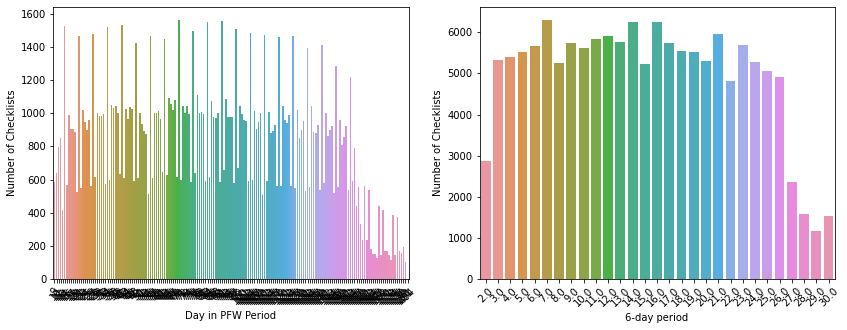

In [ ]:
plt.figure(figsize = (14,5))

gbday = bird.groupby('day_in_period').count()['sub_id']
gbperiod = bird.groupby('six_day_period').count()['sub_id']

plt.subplot(1, 2, 1)
sns.barplot(gbday.index, gbday)
plt.xticks(rotation=45)
plt.xlabel("Day in PFW Period")
plt.ylabel("Number of Checklists")

plt.subplot(1, 2, 2)
sns.barplot(gbperiod.index, gbperiod)
plt.xticks(rotation=45)
plt.xlabel("6-day period")
plt.ylabel("Number of Checklists")

plt.show()

As shown in the barplots above, the number of checklists recorded throughout the days of the week exhibits a cyclic pattern, most likely due to more observations being recorded on certain days such as weekends.  For modeling, the 6-day period is a better time variable since it elimintaes the weekly cycling.

At this point, save the prepped dataset to a csv.

In [ ]:
bird.to_csv(fdir + "intermediate_prepped_data.csv")

In [ ]:
# List of variables that will not be used in the model
excl_vars = ['loc_id', 'state', 'sub_id', 'proj_period_id', 'proj_period', 'valid',
             'reviewed', 'easblu', 'year', 'month', 'day', 'datetime', 'day_in_period']

In [ ]:
# List of non-bird_species columns
nospcs =  pd.unique(no_pivot + sites.columns.tolist() + popwthr + ['fed_yr_round', 'datetime', 'day_in_period', 'proj_period', 'six_day_period']).tolist()

In [ ]:
# List of bird species columns
spcs_list = [x for x in bird.columns if x not in nospcs]
drop_spcs = bird[spcs_list].sum()[bird[spcs_list].sum() == 0].tolist()
bird = bird.drop(columns = drop_spcs)
spcs_list = [x for x in bird.columns if x not in nospcs]

In [ ]:
print('Current number of sites in the data: {}'.format(bird['loc_id'].nunique()))
print('\n')
print('Current number of bird species in the data: {}'.format(len(spcs_list)))
print('\n')
print('Current shape of the data: {}'.format(bird.shape))

Current number of sites in the data: 3186


Current number of bird species in the data: 43


Current shape of the data: (143368, 110)


##Classification Modeling

###Split into Training and Test Sets

Get ready for modeling.

In [ ]:
pfdata = pd.read_csv(fdir + "intermediate_prepped_data.csv")
pfdata = pfdata.drop(columns = 'Unnamed: 0')

Set the dependent and independent variables, and split the data into training and test sets.

In [ ]:
# List of variables that will not be used in the model
excl_vars = ['loc_id', 'state', 'sub_id', 'proj_period_id','proj_period', 'valid',
             'reviewed', 'easblu', 'year', 'month', 'day', 'datetime', 'day_in_period']

y = pfdata['easblu_bina']
X = pfdata.loc[:, ~pfdata.columns.isin(excl_vars + ['easblu_bina'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 461)

X.shape

(143368, 96)

stratify=y results in consistent class distribution between training and test sets:

In [ ]:
y_train[y_train == 1].shape[0] / y_train[y_train == 0].shape[0]

0.4045653824487497

In [ ]:
y_test[y_test == 1].shape[0] / y_test[y_test == 0].shape[0]

0.4045554739162381

Reviewing correlations again.

In [ ]:
corr_feat = get_top_abs_correlations(X)
corr_feat[:12]

tmin               tmax               0.8219532
latitude           longitude          0.7258336
yard_type_landsca  hab_residential    0.6510675
hab_residential    squirrels          0.6398516
latitude           bkcchi             0.6198621
yard_type_landsca  squirrels          0.6013931
hab_residential    humans             0.5299281
day1_pm            day2_pm            0.5204463
yard_type_landsca  humans             0.5159666
hab_mixed_woods    squirrels          0.5156778
squirrels          humans             0.5053710
latitude           carchi             0.4968788
dtype: float64

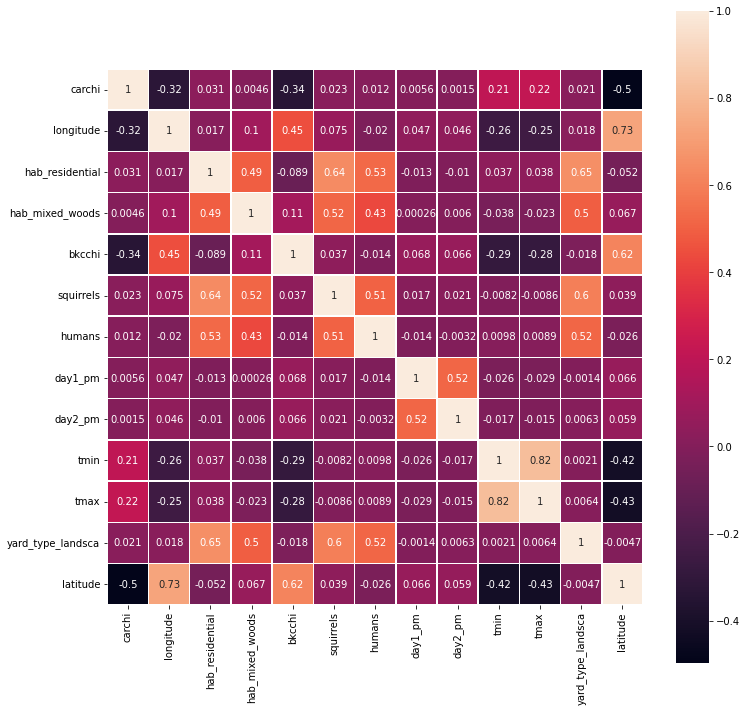

In [ ]:
top_corr_feat = list(set(list(corr_feat[:12].index.get_level_values(0)) + list(corr_feat[:12].index.get_level_values(1))))

plt.figure(figsize=(12, 12))

sns.heatmap(pfdata[top_corr_feat].corr(), square=True, annot=True, linewidth = 0.5)

plt.show()

In [ ]:
corr_targ = pfdata.loc[:, ~pfdata.columns.isin(excl_vars)].corr()['easblu_bina'].sort_values(key=pd.Series.abs, ascending=False)
round(corr_targ[:14], 3)

easblu_bina       1.000
ruc_2013         -0.271
carwre            0.245
latitude         -0.218
rebwoo            0.191
bkcchi           -0.185
norfli            0.177
yerwar            0.167
carchi            0.152
six_day_period    0.151
tmax              0.141
pinwar            0.138
houfin            0.131
tmin              0.126
Name: easblu_bina, dtype: float64

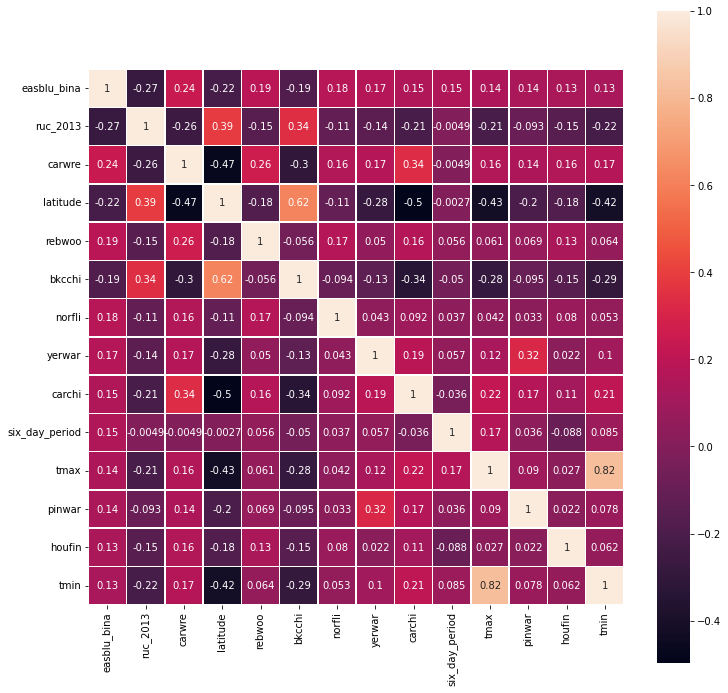

In [ ]:
plt.figure(figsize=(12, 12))

sns.heatmap(pfdata[list(corr_targ[:14].index)].corr(), square=True, annot=True, linewidth = 0.5)

plt.show()

In [ ]:
pfdata[['easblu_bina', 'houspa', 'pop_dens', 'ruc_2013']].corr()

easblu_bina     houspa   pop_dens   ruc_2013
easblu_bina    1.0000000 -0.0874466  0.1231971 -0.2713341
houspa        -0.0874466  1.0000000  0.2345316 -0.0312803
pop_dens       0.1231971  0.2345316  1.0000000 -0.2908617
ruc_2013      -0.2713341 -0.0312803 -0.2908617  1.0000000

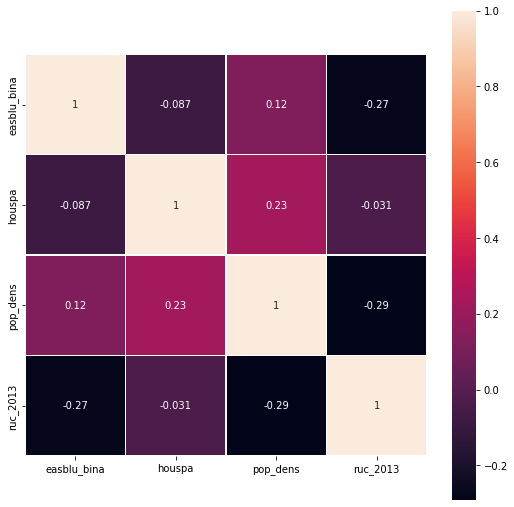

In [ ]:
plt.figure(figsize=(9, 9))

sns.heatmap(pfdata[['easblu_bina', 'houspa', 'pop_dens', 'ruc_2013']].corr(), square=True, annot=True, linewidth = 0.5)

plt.show()

###Initial Random Forest: feature importance, further feature selection

An initial random forest classifier will be run in order to investigate feature importance.

In [ ]:
start_time = time.clock()

rfc = ensemble.RandomForestClassifier(n_estimators=900, min_samples_leaf=1, min_samples_split=2, random_state=445, n_jobs=8)
rfc.fit(X_train, y_train)

cv_scores = cross_val_score(rfc, X_train, y_train, cv=4)
print('Accuracy scores for the folds: ', cv_scores)
print('Mean cross-validation score: {:.3f}'.format(np.mean(cv_scores)))
print('\n')

run_time = time.clock() - start_time
print('Run time: {:.3f}'.format(run_time))

Accuracy scores for the folds:  [0.86255842 0.85844319 0.86039131 0.85878701]
Mean cross-validation score: 0.860


Run time: 477.139


The consistent CV scores show that the model is very generalizable across test sets.

Feature importance:

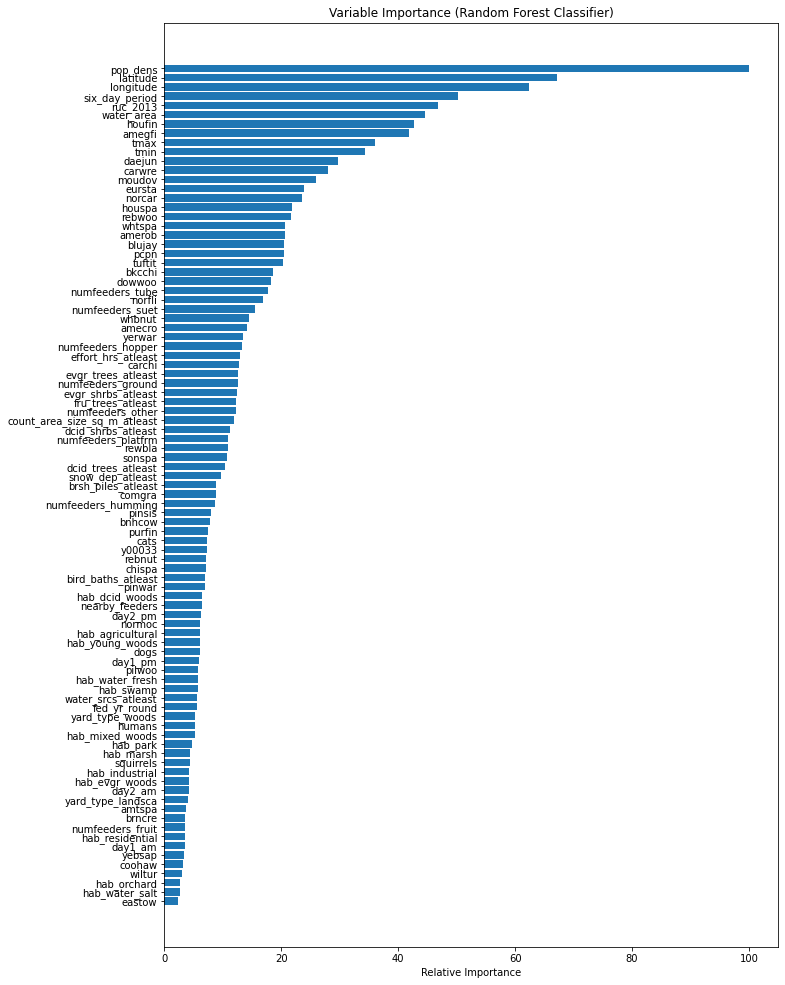

In [ ]:
plt.figure(figsize = (11,17))

plot_feat_imp(rfc, 'Random Forest Classifier', X.shape[1], X)

plt.show()

Remove variables with low feature importance.

In [ ]:
feat_importances = pd.Series(rfc.feature_importances_, index=X.columns)
lowfeat = feat_importances[feat_importances < 0.0092].index.tolist()
pfdata = pfdata.drop(columns = lowfeat)

In [ ]:
# List of non-bird_species columns
nospcs =  pd.unique(no_pivot + sites.columns.tolist() + popwthr + ['fed_yr_round', 'datetime', 'day_in_period', 'proj_period', 'six_day_period']).tolist()

In [ ]:
# List of bird species columns
spcs_list = [x for x in pfdata.columns if x not in nospcs]
drop_spcs = pfdata[spcs_list].sum()[pfdata[spcs_list].sum() == 0].tolist()
pfdata = pfdata.drop(columns = drop_spcs)
spcs_list = [x for x in pfdata.columns if x not in nospcs]

Resplit into training and test set.

In [ ]:
y = pfdata['easblu_bina']
X = pfdata.loc[:, ~pfdata.columns.isin(excl_vars + ['easblu_bina'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 461)

X.shape

(143368, 33)

In [ ]:
start_time = time.clock()

rfc = ensemble.RandomForestClassifier(n_estimators=900, min_samples_leaf=1, min_samples_split=2, random_state=445, n_jobs=8)
rfc.fit(X_train, y_train)

cv_scores = cross_val_score(rfc, X_train, y_train, cv=4)
print('Accuracy scores for the folds: ', cv_scores)
print('Mean cross-validation score: {:.3f}'.format(np.mean(cv_scores)))
print('\n')

run_time = time.clock() - start_time
print('Run time: {:.3f}'.format(run_time))

Accuracy scores for the folds:  [0.85059636 0.847074   0.84734768 0.84487148]
Mean cross-validation score: 0.847


Run time: 381.744


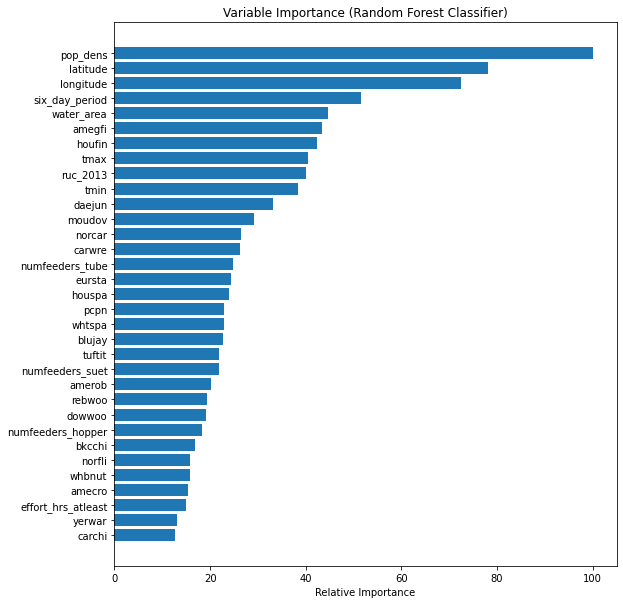

In [ ]:
plt.figure(figsize = (9,10))

plot_feat_imp(rfc, 'Random Forest Classifier', X.shape[1], X)

plt.show()

To simplify the model further, combine all numfeeders features with a sum.  Then drop the original features.

In [ ]:
pfdata['numfeeders']= pfdata[list(pfdata.filter(regex='numfeeders_'))].sum(axis=1)
pfdata = pfdata.drop(columns = list(pfdata.filter(regex='numfeeders_')))

Save the final prepped dataset to a csv.

In [ ]:
pfdata.to_csv(fdir + "final_prepped_data.csv")

In [ ]:
pfdata = pd.read_csv(fdir + "final_prepped_data.csv")
pfdata = pfdata.drop(columns = 'Unnamed: 0')

In [ ]:
y = pfdata['easblu_bina']
X = pfdata.loc[:, ~pfdata.columns.isin(excl_vars + ['easblu_bina'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 461)

X.shape

(143368, 31)

In [ ]:
start_time = time.clock()

rfc = ensemble.RandomForestClassifier(n_estimators=900, min_samples_leaf=1, min_samples_split=2, random_state=445, n_jobs=8)
rfc.fit(X_train, y_train)

cv_scores = cross_val_score(rfc, X_train, y_train, cv=4)
print('Accuracy scores for the folds: ', cv_scores)
print('Mean cross-validation score: {:.3f}'.format(np.mean(cv_scores)))
print('\n')

run_time = time.clock() - start_time
print('Run time: {:.3f}'.format(run_time))

Accuracy scores for the folds:  [0.84822487 0.84386552 0.84570851 0.84323231]
Mean cross-validation score: 0.845


Run time: 388.354


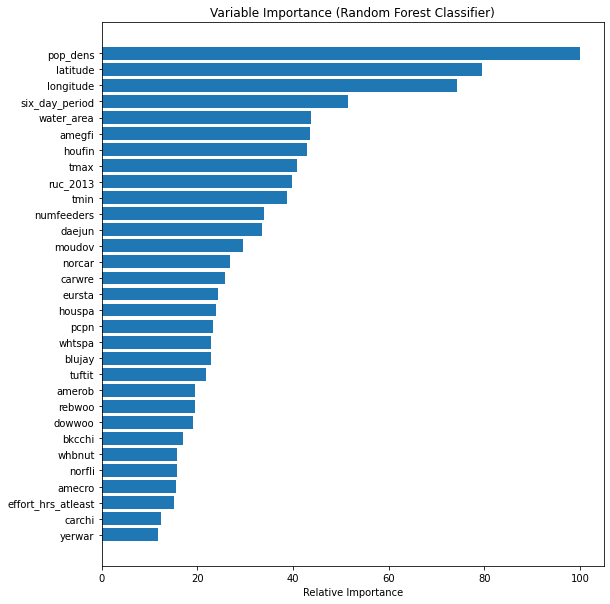

In [ ]:
plt.figure(figsize = (9,10))

plot_feat_imp(rfc, 'Random Forest Classifier', X.shape[1], X)

plt.show()

###Random Forest Classifier with Grid Search

An attempt will now be made to improve the performance of the random forest classifier by tuning the hyperparameters using grid search.

In [ ]:
pfdata = pd.read_csv(fdir + "final_prepped_data.csv")
pfdata = pfdata.drop(columns = 'Unnamed: 0')

In [ ]:
# List of variables that will not be used in the model
excl_vars = ['loc_id', 'state', 'sub_id', 'proj_period_id', 'proj_period', 'valid',
             'reviewed', 'easblu', 'year', 'month', 'day', 'datetime', 'day_in_period']

y = pfdata['easblu_bina']
X = pfdata.loc[:, ~pfdata.columns.isin(excl_vars + ['easblu_bina'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 461)

X.shape

(143368, 31)

In [ ]:
# Number of trees (def=100)
n_estimators = [300, 600, 900]

# Min number of samples required to split a node (def=2)
min_samples_split = [2, 3, 4]

# Min number of samples required at each leaf node (def=1)
min_samples_leaf = [1, 2]

# Number of folds
cv = 4

In [ ]:
params = {'n_estimators' : n_estimators,
          'min_samples_split' : min_samples_split,
          'min_samples_leaf' : min_samples_leaf}

scorers = {'precision_score': make_scorer(precision_score),
           'recall_score': make_scorer(recall_score),
           'accuracy_score': make_scorer(accuracy_score)}

In [ ]:
rfg = rf_grid_search(refit_score='accuracy_score')

Fitting 4 folds for each of 18 candidates, totalling 72 fits


In [ ]:
# Save the model
joblib.dump(rfg, fdir + "models/rf_grid_search.joblib")
print("Model saved")

Model saved


In [ ]:
# Load the model
rfg = joblib.load(fdir + "models/rf_grid_search.joblib")
print("Model loaded")

Model loaded


In [ ]:
print('Best parameters: {}'.format(rfg.best_params_))
print('\n')

# For the best set of parameters, get the scores on the folds
cv_scores = [rfg.cv_results_['split'+str(ii)+'_test_accuracy_score'][rfg.best_index_] for ii in np.arange(0, cv)]
print('Accuracy scores for the best set of folds: {}'.format(list(np.around(np.array(cv_scores),3))))
print('Mean cross-validation score for the best set of folds: {:.3f}'.format(rfg.best_score_))

Best parameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 900}


Accuracy scores for the best set of folds: [0.848, 0.844, 0.846, 0.843]
Mean cross-validation score for the best set of folds: 0.845


Grid search chose the same parameters that were used in the last random forest classifier.

In [ ]:
rf_results = pd.DataFrame(rfg.cv_results_).sort_values(by='rank_test_accuracy_score')

As shown in the results below, the model accuracy is nearly unchanged going from 300 trees to 900 trees.  Increasing the number of trees any further would not do much, except increase the run time.

In [ ]:
cols = list(rf_results.filter(regex='param_')) + list(rf_results.filter(regex='mean_test_accuracy')) \
        + list(rf_results.filter(regex='rank_test_accuracy')) + ['mean_fit_time', 'std_test_accuracy_score']
results_acc = rf_results.loc[:, rf_results.columns.isin(cols)]
results_acc.head(10)

mean_fit_time param_min_samples_leaf param_min_samples_split  \
2     232.7891163                      1                       2   
5     226.7110623                      1                       3   
3      79.4970228                      1                       3   
4     156.6421189                      1                       3   
0      75.3871846                      1                       2   
1     150.6560912                      1                       2   
8     239.5844314                      1                       4   
7     156.4541481                      1                       4   
6      79.0157295                      1                       4   
11    233.8274255                      2                       2   

   param_n_estimators  mean_test_accuracy_score  std_test_accuracy_score  \
2                 900                 0.8452578                0.0019396   
5                 900                 0.8450747                0.0017477   
3                 300                 0.8450573                0.0011877   
4                 600                 0.8450311                0.0020076   
0                 300                 0.8450050                0.0015121   
1                 600                 0.8449178                0.0021131   
8                 900                 0.8440110                0.0016964   
7                 600                 0.8438977                0.0017831   
6                 300                 0.8438105                0.0024210   
11                900                 0.8422934                0.0017749   

    rank_test_accuracy_score  
2                          1  
5                          2  
3                          3  
4                          4  
0                          5  
1                          6  
8                          7  
7                          8  
6                          9  
11                        10

Precision score vs. parameters:

In [ ]:
cols = list(rf_results.filter(regex='param_')) + list(rf_results.filter(regex='mean_test_precision')) \
        + list(rf_results.filter(regex='rank_test_precision')) + ['mean_fit_time', 'std_test_precision_score']
results_prec = rf_results.loc[:, rf_results.columns.isin(cols)]
results_prec.head(10)

mean_fit_time param_min_samples_leaf param_min_samples_split  \
2     232.7891163                      1                       2   
5     226.7110623                      1                       3   
3      79.4970228                      1                       3   
4     156.6421189                      1                       3   
0      75.3871846                      1                       2   
1     150.6560912                      1                       2   
8     239.5844314                      1                       4   
7     156.4541481                      1                       4   
6      79.0157295                      1                       4   
11    233.8274255                      2                       2   

   param_n_estimators  mean_test_precision_score  std_test_precision_score  \
2                 900                  0.7939680                 0.0024967   
5                 900                  0.7942557                 0.0024322   
3                 300                  0.7930695                 0.0010881   
4                 600                  0.7943227                 0.0025075   
0                 300                  0.7936773                 0.0020925   
1                 600                  0.7934774                 0.0028597   
8                 900                  0.7933278                 0.0011355   
7                 600                  0.7934289                 0.0017238   
6                 300                  0.7921110                 0.0025335   
11                900                  0.7922497                 0.0027758   

    rank_test_precision_score  
2                           3  
5                           2  
3                           8  
4                           1  
0                           4  
1                           5  
8                           7  
7                           6  
6                          12  
11                          9

Recall score vs. parameters:

In [ ]:
cols = list(rf_results.filter(regex='param_')) + list(rf_results.filter(regex='mean_test_recall')) \
        + list(rf_results.filter(regex='rank_test_recall')) + ['mean_fit_time', 'std_test_recall_score']
results_rec = rf_results.loc[:, rf_results.columns.isin(cols)]
results_rec.head(10)

mean_fit_time param_min_samples_leaf param_min_samples_split  \
2     232.7891163                      1                       2   
5     226.7110623                      1                       3   
3      79.4970228                      1                       3   
4     156.6421189                      1                       3   
0      75.3871846                      1                       2   
1     150.6560912                      1                       2   
8     239.5844314                      1                       4   
7     156.4541481                      1                       4   
6      79.0157295                      1                       4   
11    233.8274255                      2                       2   

   param_n_estimators  mean_test_recall_score  std_test_recall_score  \
2                 900               0.6249243              0.0064964   
5                 900               0.6236833              0.0055135   
3                 300               0.6251968              0.0045227   
4                 600               0.6233806              0.0062250   
0                 300               0.6241373              0.0054253   
1                 600               0.6239860              0.0070469   
8                 900               0.6199298              0.0065355   
7                 600               0.6192638              0.0066127   
6                 300               0.6205957              0.0081648   
11                900               0.6133006              0.0063462   

    rank_test_recall_score  
2                        2  
5                        5  
3                        1  
4                        6  
0                        3  
1                        4  
8                        8  
7                        9  
6                        7  
11                      16

In [ ]:
y_preds_test = rfg.predict(X_test)

In [ ]:
# Get the test set results
accuracy = accuracy_score(y_test, y_preds_test)
precision = precision_score(y_test, y_preds_test)
recall = recall_score(y_test, y_preds_test)
f1 = f1_score(y_test, y_preds_test)
fbeta_precision = fbeta_score(y_test, y_preds_test, beta = 0.5)
fbeta_recall = fbeta_score(y_test, y_preds_test, beta = 2.0)

print('Test set results:')
print('Accuracy score: {:.3f}'.format(accuracy))
print('Precision score: {:.3f}'.format(precision))
print('Recall score: {:.3f}'.format(recall))
print('F1 score: {:.3f}'.format(f1))
print('Fbeta score favoring precision: {:.3f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.3f}'.format(fbeta_recall))
print('\n')

Test set results:
Accuracy score: 0.852
Precision score: 0.799
Recall score: 0.649
F1 score: 0.716
Fbeta score favoring precision: 0.763
FBeta score favoring recall: 0.674




Print a classification report.

In [ ]:
report = classification_report(y_test, y_preds_test, target_names=['Positive', 'Negative'])
print(report)

              precision    recall  f1-score   support

    Positive       0.87      0.93      0.90     20415
    Negative       0.80      0.65      0.72      8259

    accuracy                           0.85     28674
   macro avg       0.83      0.79      0.81     28674
weighted avg       0.85      0.85      0.85     28674



Plot a confusion matrix.

In [ ]:
X_test.shape

(28674, 31)

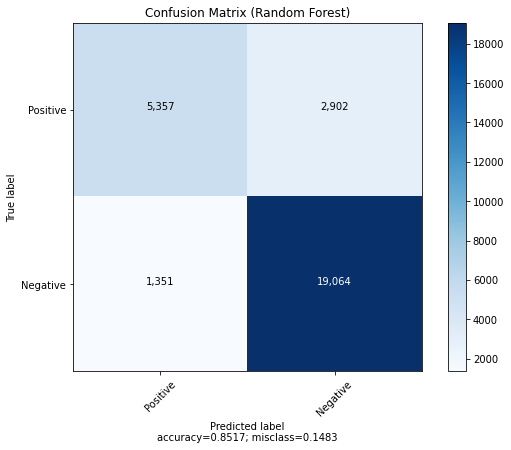

In [ ]:
confusion = confusion_matrix(y_test, y_preds_test, labels=[1, 0])
plot_confusion_matrix(cm=confusion, target_names = ['Positive', 'Negative'], title = "Confusion Matrix (Random Forest)", normalize=False)

The recall score is low due to the relatively high number of false negatives.

Plot the ROC curve and AUC.  Calculate AUC.

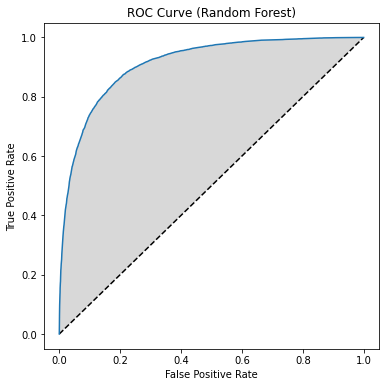

In [ ]:
rfg_probs = rfg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, rfg_probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.fill(fpr, tpr, 'grey', alpha=0.3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.show()

In [ ]:
auc = roc_auc_score(y_test, rfg_probs)
print("ROCAUC: {:.3f}".format(auc))

ROCAUC: 0.912


###Gradient Boosting Classifier with Grid Search

Next, evaluate a gradient boosting classifier, tuning the hyperparameters with grid search.

In [ ]:
pfdata = pd.read_csv(fdir + "final_prepped_data.csv")
pfdata = pfdata.drop(columns = 'Unnamed: 0')

In [ ]:
# List of variables that will not be used in the model
excl_vars = ['loc_id', 'state', 'sub_id', 'proj_period_id', 'proj_period', 'valid',
             'reviewed', 'easblu', 'year', 'month', 'day', 'datetime', 'day_in_period']

y = pfdata['easblu_bina']
X = pfdata.loc[:, ~pfdata.columns.isin(excl_vars + ['easblu_bina'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 461)

X.shape

(143368, 31)

In [ ]:
# Note that for the numeric parameters, wider ranges were first tested,
# before narrowing in on the following ranges

# Loss function to be optimized (def=deviance)
loss = ['deviance']

# Shrinking the contribution of each tree by learning_rate (def=0.1)
learning_rate = [0.1, 0.2]

# Number of boosting stages to perform (def=100)
n_estimators = [900]

# Fraction of samples to be used for fitting the individual base learners (def=1)
subsample = [0.7, 0.8, 0.9]

# Minimum number of samples required to split an internal node (def=2)
min_samples_split = [3, 4, 5]

# Maximum depth of the individual regression estimators (def=3)
max_depth = [10, 11, 12]

# Number of folds
cv = 4

In [ ]:
params = {'loss' : loss,
          'learning_rate' : learning_rate,
          'n_estimators' : n_estimators,
          'subsample' : subsample,
          'min_samples_split' : min_samples_split,
          'max_depth' : max_depth}

scorers = {'precision_score': make_scorer(precision_score),
           'recall_score': make_scorer(recall_score),
           'accuracy_score': make_scorer(accuracy_score)}

In [ ]:
gbg = gb_grid_search(refit_score='accuracy_score')

Fitting 4 folds for each of 54 candidates, totalling 216 fits


In [ ]:
# Save the model
joblib.dump(gbg, fdir + "models/gb_grid_search.joblib")
print("Model saved")

Model saved


In [ ]:
# Load the model
gbg = joblib.load(fdir + "models/gb_grid_search.joblib")
print("Model loaded")

Model loaded


In [ ]:
print('Best parameters: {}'.format(gbg.best_params_))
print('\n')

# For the best set of parameters, get the scores on the folds
cv_scores = [gbg.cv_results_['split'+str(ii)+'_test_accuracy_score'][gbg.best_index_] for ii in np.arange(0, cv)]
print('Accuracy scores for the best set of folds: {}'.format(list(np.around(np.array(cv_scores),3))))
print('Mean cross-validation score for the best set of folds: {:.3f}'.format(gbg.best_score_))

Best parameters: {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 11, 'min_samples_split': 4, 'n_estimators': 900, 'subsample': 0.8}


Accuracy scores for the best set of folds: [0.868, 0.864, 0.864, 0.864]
Mean cross-validation score for the best set of folds: 0.865


This is an improvement over the random forest classifier.

In [ ]:
gb_results = pd.DataFrame(gbg.cv_results_).sort_values(by='rank_test_accuracy_score')

Accuracy score vs. parameters:

In [ ]:
cols = list(gb_results.filter(regex='param_')) + list(gb_results.filter(regex='mean_test_accuracy')) \
        + list(gb_results.filter(regex='rank_test_accuracy')) + ['mean_fit_time', 'std_test_accuracy_score']
results_acc = gb_results.loc[:, gb_results.columns.isin(cols)]
results_acc.head(10)

mean_fit_time param_learning_rate param_loss param_max_depth  \
13   1050.5607036                 0.1   deviance              11   
25   1168.8999117                 0.1   deviance              12   
11   1170.6438355                 0.1   deviance              11   
14   1157.1956729                 0.1   deviance              11   
53   1230.0776141                 0.2   deviance              12   
2    1032.8125477                 0.1   deviance              10   
41   1139.8552831                 0.2   deviance              11   
16   1038.0362921                 0.1   deviance              11   
8    1017.2082400                 0.1   deviance              10   
23   1304.4783087                 0.1   deviance              12   

   param_min_samples_split param_n_estimators param_subsample  \
13                       4                900             0.8   
25                       5                900             0.8   
11                       3                900             0.9   
14                       4                900             0.9   
53                       5                900             0.9   
2                        3                900             0.9   
41                       4                900             0.9   
16                       5                900             0.8   
8                        5                900             0.9   
23                       4                900             0.9   

    mean_test_accuracy_score  std_test_accuracy_score  \
13                 0.8648578                0.0019786   
25                 0.8648403                0.0016579   
11                 0.8647444                0.0017644   
14                 0.8646660                0.0015666   
53                 0.8645090                0.0015892   
2                  0.8644567                0.0018225   
41                 0.8643434                0.0026504   
16                 0.8642998                0.0004631   
8                  0.8642126                0.0021689   
23                 0.8642039                0.0016646   

    rank_test_accuracy_score  
13                         1  
25                         2  
11                         3  
14                         4  
53                         5  
2                          6  
41                         7  
16                         8  
8                          9  
23                        10

Precision score vs. parameters:

In [ ]:
cols = list(gb_results.filter(regex='param_')) + list(gb_results.filter(regex='mean_test_precision')) \
        + list(gb_results.filter(regex='rank_test_precision')) + ['mean_fit_time', 'std_test_precision_score']
results_prec = gb_results.loc[:, gb_results.columns.isin(cols)]
results_prec.head(10)

mean_fit_time param_learning_rate param_loss param_max_depth  \
13   1050.5607036                 0.1   deviance              11   
25   1168.8999117                 0.1   deviance              12   
11   1170.6438355                 0.1   deviance              11   
14   1157.1956729                 0.1   deviance              11   
53   1230.0776141                 0.2   deviance              12   
2    1032.8125477                 0.1   deviance              10   
41   1139.8552831                 0.2   deviance              11   
16   1038.0362921                 0.1   deviance              11   
8    1017.2082400                 0.1   deviance              10   
23   1304.4783087                 0.1   deviance              12   

   param_min_samples_split param_n_estimators param_subsample  \
13                       4                900             0.8   
25                       5                900             0.8   
11                       3                900             0.9   
14                       4                900             0.9   
53                       5                900             0.9   
2                        3                900             0.9   
41                       4                900             0.9   
16                       5                900             0.8   
8                        5                900             0.9   
23                       4                900             0.9   

    mean_test_precision_score  std_test_precision_score  \
13                  0.8007677                 0.0034545   
25                  0.8035133                 0.0036386   
11                  0.8013080                 0.0037985   
14                  0.8008461                 0.0028369   
53                  0.8010920                 0.0027299   
2                   0.7985864                 0.0030309   
41                  0.7987385                 0.0046929   
16                  0.7986142                 0.0019765   
8                   0.7964590                 0.0046373   
23                  0.8024441                 0.0035677   

    rank_test_precision_score  
13                         13  
25                          1  
11                          8  
14                         12  
53                          9  
2                          25  
41                         23  
16                         24  
8                          32  
23                          3

Recall score vs. parameters:

In [ ]:
cols = list(gb_results.filter(regex='param_')) + list(gb_results.filter(regex='mean_test_recall')) \
        + list(gb_results.filter(regex='rank_test_recall')) + ['mean_fit_time', 'std_test_recall_score']
results_rec = gb_results.loc[:, gb_results.columns.isin(cols)]
results_rec.head(10)

mean_fit_time param_learning_rate param_loss param_max_depth  \
13   1050.5607036                 0.1   deviance              11   
25   1168.8999117                 0.1   deviance              12   
11   1170.6438355                 0.1   deviance              11   
14   1157.1956729                 0.1   deviance              11   
53   1230.0776141                 0.2   deviance              12   
2    1032.8125477                 0.1   deviance              10   
41   1139.8552831                 0.2   deviance              11   
16   1038.0362921                 0.1   deviance              11   
8    1017.2082400                 0.1   deviance              10   
23   1304.4783087                 0.1   deviance              12   

   param_min_samples_split param_n_estimators param_subsample  \
13                       4                900             0.8   
25                       5                900             0.8   
11                       3                900             0.9   
14                       4                900             0.9   
53                       5                900             0.9   
2                        3                900             0.9   
41                       4                900             0.9   
16                       5                900             0.8   
8                        5                900             0.9   
23                       4                900             0.9   

    mean_test_recall_score  std_test_recall_score  rank_test_recall_score  
13               0.7066231              0.0050113                      17  
25               0.7025669              0.0040886                      36  
11               0.7053215              0.0038531                      26  
14               0.7056242              0.0039914                      25  
53               0.7045344              0.0036819                      28  
2                0.7079852              0.0051806                      11  
41               0.7072285              0.0061148                      14  
16               0.7072285              0.0020315                      14  
8                0.7100436              0.0042837                       4  
23               0.7011745              0.0032568                      42

In [ ]:
y_preds_test = gbg.predict(X_test)

In [ ]:
# Get the test set results
accuracy = accuracy_score(y_test, y_preds_test)
precision = precision_score(y_test, y_preds_test)
recall = recall_score(y_test, y_preds_test)
f1 = f1_score(y_test, y_preds_test)
fbeta_precision = fbeta_score(y_test, y_preds_test, beta = 0.5)
fbeta_recall = fbeta_score(y_test, y_preds_test, beta = 2.0)

print('Test set results:')
print('Accuracy score: {:.3f}'.format(accuracy))
print('Precision score: {:.3f}'.format(precision))
print('Recall score: {:.3f}'.format(recall))
print('F1 score: {:.3f}'.format(f1))
print('Fbeta score favoring precision: {:.3f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.3f}'.format(fbeta_recall))
print('\n')

Test set results:
Accuracy score: 0.870
Precision score: 0.805
Recall score: 0.724
F1 score: 0.763
Fbeta score favoring precision: 0.788
FBeta score favoring recall: 0.739




Print a classification report.

In [ ]:
report = classification_report(y_test, y_preds_test, target_names=['Positive', 'Negative'])
print(report)

              precision    recall  f1-score   support

    Positive       0.89      0.93      0.91     20415
    Negative       0.81      0.72      0.76      8259

    accuracy                           0.87     28674
   macro avg       0.85      0.83      0.84     28674
weighted avg       0.87      0.87      0.87     28674



Plot a confusion matrix.

In [ ]:
X_test.shape

(28674, 31)

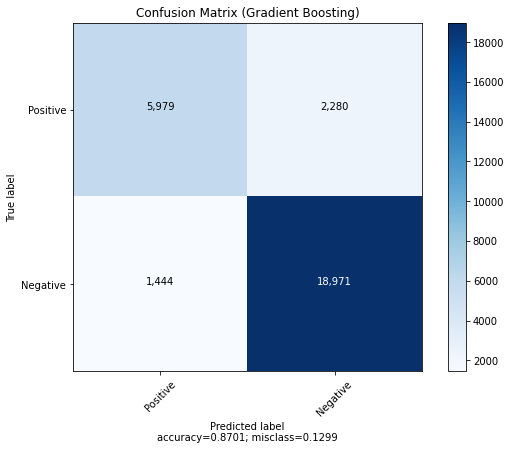

In [ ]:
confusion = confusion_matrix(y_test, y_preds_test, labels=[1, 0])
plot_confusion_matrix(cm=confusion, target_names = ['Positive', 'Negative'], title = "Confusion Matrix (Gradient Boosting)", normalize=False)

Overall, this gradient boosting classifier is a higher performer than the random forest.  Accuracy and recall scores have increased at the small cost of a slight decrease in precision score. 

Plot the ROC curve and AUC.  Calculate AUC.

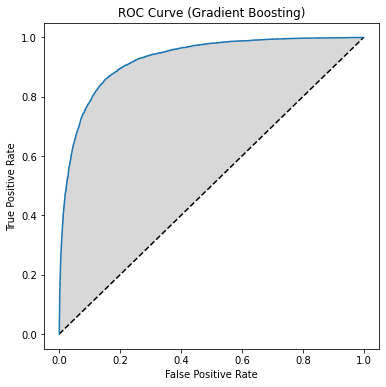

In [ ]:
gbg_probs = gbg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, gbg_probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.fill(fpr, tpr, 'grey', alpha=0.3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Gradient Boosting)")
plt.show()

In [ ]:
auc = roc_auc_score(y_test, gbg_probs)
print("ROCAUC: {:.3f}".format(auc))

ROCAUC: 0.927


###ANN

Finally, evaluate an artificial neural network (ANN).

In [ ]:
pfdata = pd.read_csv(fdir + "final_prepped_data.csv")
pfdata = pfdata.drop(columns = 'Unnamed: 0')

In [ ]:
# List of variables that will not be used in the model
excl_vars = ['loc_id', 'state', 'sub_id', 'proj_period_id', 'proj_period', 'valid',
             'reviewed', 'easblu', 'year', 'month', 'day', 'datetime', 'day_in_period']

y = pfdata['easblu_bina']
X = pfdata.loc[:, ~pfdata.columns.isin(excl_vars + ['easblu_bina'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 461)

X.shape

(143368, 31)

In [ ]:
# Standardize for ANN
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.fit_transform(X_test)

In [ ]:
# Function to create a list of numbers
# where list[n] = list[n - 1] / 2

def halves(init, length):
    
    init = init
    length = length
    listy = list(np.arange(1, length+1, 1))
    for idx, val in enumerate(listy):
        if idx == 0:
            listy[idx] = init
        else:
            listy[idx] = listy[idx-1] // 2

    return listy

The following sections tune an ANN model based on activation function, neuron and layer count, batch size, and learning rate. 

In [ ]:
vary = 'activ_func'
var_list = ['relu', 'tanh', 'sigmoid']

params = {'neuron_counts' : halves(512, 5),
          vary : var_list,
          'optimizer_learn_rate' : 0.016,
          'batch_size' : 300,
          'nb_epoch' : 20}

df_list = []
params_2 = params.copy()

for val in params[vary]:
    params_2[vary] = val
    df, model = run_ann(params_2, X_train_st, y_train, X_test_st, y_test)
    df_list.append(df)

In [ ]:
results_df_01 = pd.concat(df_list, ignore_index=True).sort_values('ROCAUC', ascending=False, ignore_index=True)
results_df_01

neuron_counts activ_func optimizer_learn_rate batch_size  \
0  [512, 256, 128, 64, 32]       relu                0.016        300   
1  [512, 256, 128, 64, 32]       tanh                0.016        300   
2  [512, 256, 128, 64, 32]    sigmoid                0.016        300   

  nb_epoch train_accuracy test_accuracy train_test_diff  precision     recall  \
0       20      0.8348407     0.8295984       0.0052422  0.6657056  0.5311781   
1       20      0.8035481     0.8014448       0.0021033  0.6478154  0.4452113   
2       20            0.5           0.5             0.0        0.0        0.0   

      ROCAUC         f1 fbeta_precision fbeta_recall    run_time  
0  0.8296259  0.5908815       0.6336116    0.5535507  26.2772684  
1  0.8014304  0.5277359       0.5937732    0.4749173  27.9240623  
2  0.3889899        0.0             0.0          0.0  26.1327071

In [ ]:
# Choose
activ_func = results_df_01['activ_func'][0]

In [ ]:
vary = 'batch_size'
var_list = [5, 15, 45, 135]

params = {'neuron_counts' : halves(512, 5),
          'activ_func' : activ_func,
          'optimizer_learn_rate' : 0.016,
          vary : var_list,
          'nb_epoch' : 20}

df_list = []
params_2 = params.copy()

for val in params[vary]:
    params_2[vary] = val
    df, model = run_ann(params_2, X_train_st, y_train, X_test_st, y_test)
    df_list.append(df)

In [ ]:
results_df_02 = pd.concat(df_list, ignore_index=True).sort_values('ROCAUC', ascending=False, ignore_index=True)
results_df_02

neuron_counts activ_func optimizer_learn_rate batch_size  \
0  [512, 256, 128, 64, 32]       relu                0.016         15   
1  [512, 256, 128, 64, 32]       relu                0.016          5   
2  [512, 256, 128, 64, 32]       relu                0.016         45   
3  [512, 256, 128, 64, 32]       relu                0.016        135   

  nb_epoch train_accuracy test_accuracy train_test_diff  precision     recall  \
0       20      0.9423382     0.8636354       0.0787028  0.6981264  0.6045526   
1       20       0.951706     0.8582804       0.0934256  0.6784062  0.6390604   
2       20      0.9053301      0.852277       0.0530531  0.6613128  0.6331275   
3       20       0.862769     0.8438484       0.0189206  0.6279772  0.6544376   

      ROCAUC         f1 fbeta_precision fbeta_recall      run_time  
0  0.8637728  0.6479787       0.6771639    0.6212053   431.3813004  
1  0.8587451  0.6581458       0.6701541    0.6465602  1337.4489861  
2  0.8523392  0.6469133       0.6554767    0.6385707    157.521369  
3  0.8438613  0.6409344       0.6330967    0.6489686    54.6742752

Here, the batch size of 250 results in a higher train and test accuracy, but the batch size of 300 will be chosen due to its lesser tendency to overfit (train vs. test).

In [ ]:
# Choose
batch_size = results_df_02['batch_size'][0]

In [ ]:
vary = 'optimizer_learn_rate'
var_list = [0.024, 0.034, 0.044, 0.054]

params = {'neuron_counts' : halves(512, 5),
          'activ_func' : activ_func,
          vary : var_list,
          'batch_size' : batch_size,
          'nb_epoch' : 20}

df_list = []
params_2 = params.copy()

for val in params[vary]:
    params_2[vary] = val
    df, model = run_ann(params_2, X_train_st, y_train, X_test_st, y_test)
    df_list.append(df)

In [ ]:
results_df_03 = pd.concat(df_list, ignore_index=True).sort_values('ROCAUC', ascending=False, ignore_index=True)
results_df_03

neuron_counts activ_func optimizer_learn_rate batch_size  \
0  [512, 256, 128, 64, 32]       relu                0.034         15   
1  [512, 256, 128, 64, 32]       relu                0.054         15   
2  [512, 256, 128, 64, 32]       relu                0.044         15   
3  [512, 256, 128, 64, 32]       relu                0.024         15   

  nb_epoch train_accuracy test_accuracy train_test_diff  precision     recall  \
0       20       0.949452     0.8613086       0.0881434  0.6823961  0.6303427   
1       20      0.9501031     0.8606967       0.0894064   0.700773   0.603705   
2       20      0.9487901     0.8583559       0.0904342  0.6909946  0.6224725   
3       20      0.9413874     0.8549376       0.0864497  0.6574677  0.6721153   

      ROCAUC         f1 fbeta_precision fbeta_recall     run_time  
0  0.8617123  0.6553374       0.6713088    0.6401082   399.548371  
1  0.8615507  0.6486276       0.6789401    0.6209061  393.3915103  
2  0.8586802  0.6549462       0.6761093    0.6350677  396.0578774  
3  0.8551398  0.6647108       0.6603459    0.6691338  402.5478404

As before, the slightly less accurate case is chosen here (optimizer_learn_rate = 0.01) due to its lesser tendency to overfit.

In [ ]:
# Choose
optimizer_learn_rate = results_df_03['optimizer_learn_rate'][0]

In [ ]:
vary = 'neuron_counts'
var_list = [halves(512, 6), halves(512, 5), halves(512, 4),
            halves(256, 5), halves(256, 4)]

params = {vary : var_list,
          'activ_func' : activ_func,
          'optimizer_learn_rate' : optimizer_learn_rate,
          'batch_size' : batch_size,
          'nb_epoch' : 20}

df_list = []
params_2 = params.copy()

for val in params[vary]:
    params_2[vary] = val
    df, model = run_ann(params_2, X_train_st, y_train, X_test_st, y_test)
    df_list.append(df)

In [ ]:
results_df_04 = pd.concat(df_list, ignore_index=True).sort_values('f1', ascending=False, ignore_index=True)
results_df_04

neuron_counts activ_func optimizer_learn_rate batch_size  \
0  [512, 256, 128, 64, 32, 16]       relu                0.034         15   
1      [512, 256, 128, 64, 32]       relu                0.034         15   
2          [512, 256, 128, 64]       relu                0.034         15   
3       [256, 128, 64, 32, 16]       relu                0.034         15   
4           [256, 128, 64, 32]       relu                0.034         15   

  nb_epoch train_accuracy test_accuracy train_test_diff  precision     recall  \
0       20       0.945846     0.8587234       0.0871226  0.6613337  0.6556484   
1       20      0.9493138     0.8582957       0.0910181  0.7021518   0.600557   
2       20      0.9480365     0.8536786       0.0943578  0.6721398  0.6195665   
3       20      0.9199506     0.8664519       0.0534987  0.7252781  0.5683497   
4       20      0.9193305     0.8615017       0.0578288  0.7336059  0.5214917   

      ROCAUC         f1 fbeta_precision fbeta_recall     run_time  
0  0.8589362  0.6584787       0.6601887    0.6567776  417.7220484  
1   0.858553  0.6473928       0.6791729    0.6184539  431.0549838  
2   0.853917  0.6447833       0.6609233    0.6294128  425.0813429  
3   0.866578  0.6372955       0.6873225    0.5940569  430.8799946  
4  0.8616412  0.6096249       0.6784173    0.5534994  421.1206217

As before, the slightly less accurate case is chosen here (neuron_counts = [512, 256, 128, 64]) due to its lesser tendency to overfit.

In [ ]:
# Choose
neuron_counts = results_df_04['neuron_counts'][0]

In [ ]:
params = {'neuron_counts' : neuron_counts,
          'activ_func' : activ_func,
          'optimizer_learn_rate' : optimizer_learn_rate,
          'batch_size' : batch_size,
          'nb_epoch' : 20}

In [ ]:
results_df, model = run_ann(params, X_train_st, y_train, X_test_st, y_test)
results_df

neuron_counts activ_func optimizer_learn_rate batch_size  \
0  [512, 256, 128, 64, 32, 16]       relu                0.034         15   

  nb_epoch train_accuracy test_accuracy train_test_diff  precision     recall  \
0       20       0.947315     0.8527244       0.0945906  0.6887859  0.6120596   

    ROCAUC       f1 fbeta_precision fbeta_recall     run_time  
0  0.85283  0.64816       0.6719394    0.6260062  463.4325974

In [ ]:
y_preds_test_prob = model.predict(X_test_st)
# The model outputs probabilities.
# For plotting the confusion matrix, change the output back to binary based on a decision threshold of 0.5
y_preds_test = (y_preds_test_prob > 0.5)

Write the ANN results to a csv.

In [ ]:
ann_results = results_df_04.sort_values('train_accuracy', ascending=False, ignore_index=True)

ann_results.to_csv(fdir + "models/ann_results.csv")

Plot the ROC curve and AUC.  Calculate AUC.

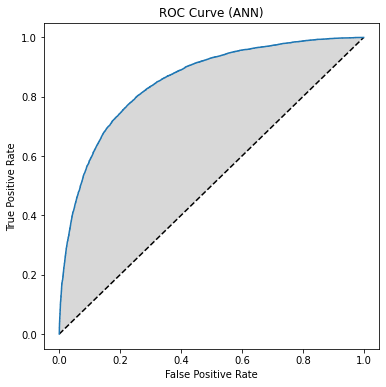

In [ ]:
ann_probs = y_preds_test_prob.reshape(1,-1)[0]
fpr, tpr, thresholds = roc_curve(y_test, ann_probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.fill(fpr, tpr, 'grey', alpha=0.3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (ANN)")
plt.show()

In [ ]:
auc = roc_auc_score(y_test, ann_probs)
print("ROCAUC: {:.3f}".format(auc))

ROCAUC: 0.853


###Comparison of Classification Models

In [ ]:
ann_results = pd.read_csv(fdir + "models/ann_results.csv")
ann_results = ann_results.drop(columns = 'Unnamed: 0')

ANN:

In [ ]:
ann_results.loc[:, ~ann_results.columns.isin(['fbeta_precision', 'fbeta_recall'])]

neuron_counts activ_func  optimizer_learn_rate  batch_size  \
0  [512, 256, 128, 64, 32, 16]       relu                  0.01         300   
1      [512, 256, 128, 64, 32]       relu                  0.01         300   
2          [512, 256, 128, 64]       relu                  0.01         300   
3       [256, 128, 64, 32, 16]       relu                  0.01         300   
4           [256, 128, 64, 32]       relu                  0.01         300   

   nb_epoch  train_accuracy  test_accuracy  train_test_diff  precision  \
0        20       0.8108801      0.8022528        0.0086273  0.6715757   
1        20       0.8084468      0.8009132        0.0075337  0.7197279   
2        20       0.8036486      0.7988080        0.0048406  0.6943110   
3        20       0.8005181      0.7970309        0.0034872  0.7148135   
4        20       0.7998073      0.7970309        0.0027763  0.6964918   

      recall         f1    run_time  
0  0.5222988  0.5876048  27.9053444  
1  0.4289479  0.5375333  26.3835886  
2  0.4539834  0.5489980  25.5156961  
3  0.4118184  0.5225723  26.2656974  
4  0.4386783  0.5383085  25.3625691

Random Forest:

In [ ]:
# Load the random forest model
rfg = joblib.load(fdir + "models/rf_grid_search.joblib")
# Get key results
print('Random forest best parameters: {}'.format(rfg.best_params_))
rf_results = pd.DataFrame(rfg.cv_results_).sort_values(by='rank_test_accuracy_score')
rf_results[['mean_fit_time', 'mean_test_accuracy_score', 'std_test_accuracy_score', 'mean_test_precision_score', 'mean_test_recall_score']].head(1)

Random forest best parameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 900}


mean_fit_time  mean_test_accuracy_score  std_test_accuracy_score  \
2    305.6885343                 0.8523759                0.0012065   

   mean_test_precision_score  mean_test_recall_score  
2                  0.8446809               0.5546742

Gradient Boosting:

In [ ]:
# Load the gradient boosting model
gbg = joblib.load(fdir + "models/gb_grid_search.joblib")
# Get key results
print('Gradient boosting best parameters: {}'.format(gbg.best_params_))
gb_results = pd.DataFrame(gbg.cv_results_).sort_values(by='rank_test_accuracy_score')
gb_results[['mean_fit_time', 'mean_test_accuracy_score', 'std_test_accuracy_score', 'mean_test_precision_score', 'mean_test_recall_score']].head(1)

Gradient boosting best parameters: {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 11, 'min_samples_split': 3, 'n_estimators': 900, 'subsample': 0.9}


mean_fit_time  mean_test_accuracy_score  std_test_accuracy_score  \
4   1579.5142376                 0.8750684                0.0003974   

   mean_test_precision_score  mean_test_recall_score  
4                  0.8280463               0.6775043

*  The ANN with the highest accuracy performs worse than the random forest and gradient boosting models.  Moreover, it shows a tendency to overfit (train vs. test).
*  The other ANN models, having different neuron and layer counts, are more generalizable, but their overall accuracy is still poorer than the random forest and gradient boosting models.
*  Both the random forest and the gradient boosting models are very generalizable as seen by their low std_test_accuracy_score, which is the standard deviation of the accuracy scores over the folds from cross-validation.
*  The gradient boosting model has the highest accuracy score and the highest recall score, while its precision score is comparable to the random forest.  Therefore, the gradient boosting model is chosen as the best model to move forward.

Compare the ROCAUC of the models.

In [ ]:
rfg_probs = rfg.predict_proba(X_test)[:, 1]
gbg_probs = gbg.predict_proba(X_test)[:, 1]
ann_probs = y_preds_test_prob.reshape(1,-1)[0]

rfg_auc = roc_auc_score(y_test, rfg_probs)
gbg_auc = roc_auc_score(y_test, gbg_probs)
ann_auc = roc_auc_score(y_test, ann_probs)

print("ROCAUC (Random Forest): {:.3f}".format(rfg_auc))
print("ROCAUC (Gradient Boosting): {:.3f}".format(gbg_auc))
print("ROCAUC (ANN): {:.3f}".format(ann_auc))

ROCAUC (Random Forest): 0.906
ROCAUC (Gradient Boosting): 0.921
ROCAUC (ANN): 0.781


The gradient boosting model has the highest ROCAUC.

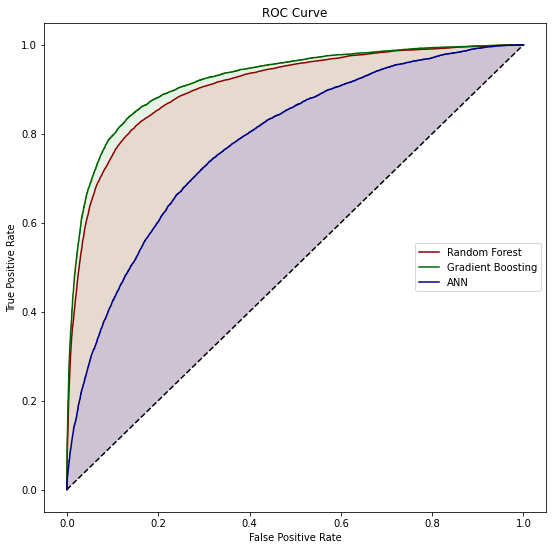

In [ ]:
fpr_rfg, tpr_rfg, thresholds = roc_curve(y_test, rfg_probs)
fpr_gbg, tpr_gbg, thresholds = roc_curve(y_test, gbg_probs)
fpr_ann, tpr_ann, thresholds = roc_curve(y_test, ann_probs)

fig = plt.figure(figsize = (9, 9))
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr_rfg, tpr_rfg, color='darkred', label="Random Forest")
plt.fill(fpr_rfg, tpr_rfg, 'red', alpha=0.1)

plt.plot(fpr_gbg, tpr_gbg, color='darkgreen', label="Gradient Boosting")
plt.fill(fpr_gbg, tpr_gbg, 'green', alpha=0.1)

plt.plot(fpr_ann, tpr_ann, color = 'darkblue', label="ANN")
plt.fill(fpr_ann, tpr_ann, 'blue', alpha=0.1)

plt.legend(loc="center right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

##Unsupervised Learning

###Prepare for Unsupervised Learning

Unsupervised learning will now be used to further explore the question:  What are the most influential factors affecting bluebird presence or absence, and what are the magnitudes of these factors that lead to a shift between presence and absence?  Specifically, the objective here is to investigate local variables by first stripping away variables such as latitude, longitude, and time.  In other words, what is characteristic about a site that influences the presence or absence of eastern bluebirds?

In [ ]:
# Load the data
pfdata = pd.read_csv(fdir + "final_prepped_data.csv")
pfdata = pfdata.drop(columns = 'Unnamed: 0')

In [ ]:
# Load the gradient boosting model
gbg = joblib.load(fdir + "models/gb_grid_search.joblib")
print("Model loaded")

Model loaded


Have another look at feature importance from the GBM.

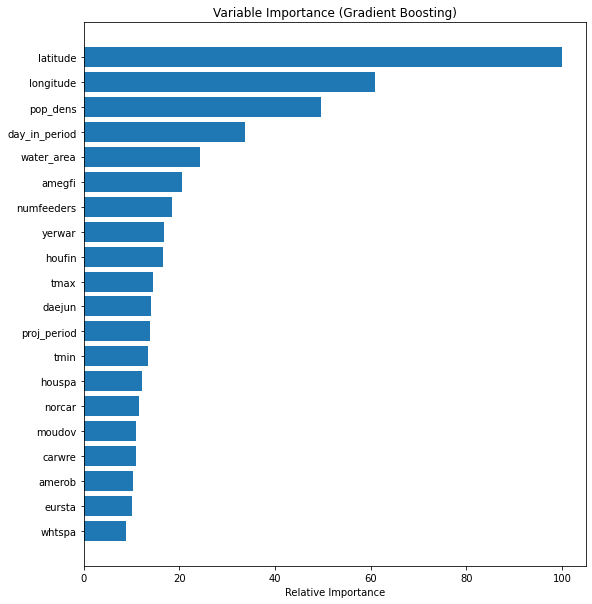

In [ ]:
# List of variables that will not be used in the model
excl_vars = ['loc_id', 'state', 'sub_id', 'proj_period_id', 'proj_period', 'valid',
             'reviewed', 'easblu', 'year', 'month', 'day', 'datetime', 'day_in_period']

X = pfdata.loc[:, ~pfdata.columns.isin(excl_vars + ['easblu_gr'])]

plt.figure(figsize = (9,10))

plot_feat_imp(gbg.best_estimator_, 'Gradient Boosting', 20, X)

plt.show()

Take the top features plus the target, easblu_gr, since the target will not be used as the ground truth here, and exclude latitude, longitude, proj_period, and day_in_period.

In [ ]:
get_top = 14
feature_importance = gbg.best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-1*get_top:]
top_feat = X.columns[sorted_idx].tolist()
top_feat = [e for e in top_feat if e not in ('latitude', 'longitude', 'proj_period', 'day_in_period')]
unsup_feat = top_feat + ['easblu_gr']
unsup_feat

['houspa',
 'tmin',
 'daejun',
 'tmax',
 'houfin',
 'yerwar',
 'numfeeders',
 'amegfi',
 'water_area',
 'pop_dens',
 'easblu_gr']

For the unsupervised learning task, latitude, longitude, proj_period, and day_in_period are not included as variables.  However, safeguards must be taken to protect against bias that is related to location and time, since this task is focused on variables local to a site.

For location, the safeguard against bias is to subset the sites to a smaller latitude / longitude box, where the locations have a more uniform spatial distribution, and have a mix of rural and urban sites.

Below is the map of sites that were included in the gradient boosting model.

See that there is a relatively uniform distribution of sites in the lower half of New York and the northern part of Pennsylvania.

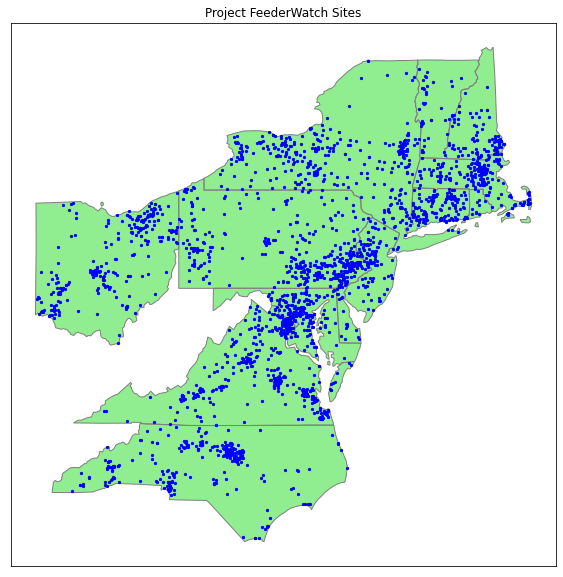

In [ ]:
long_lat = pfdata.groupby(['longitude', 'latitude']).count().reset_index()[['longitude', 'latitude']]
geometry = [Point(xy) for xy in zip(long_lat['longitude'], long_lat['latitude'])]
geo_df = gpd.GeoDataFrame(long_lat, crs=crs, geometry=geometry)

plot_map(geo_df, (10,10), "Project FeederWatch Sites")

Subset the patch of sites in the lower half of New York and the northern part of Pennsylvania:

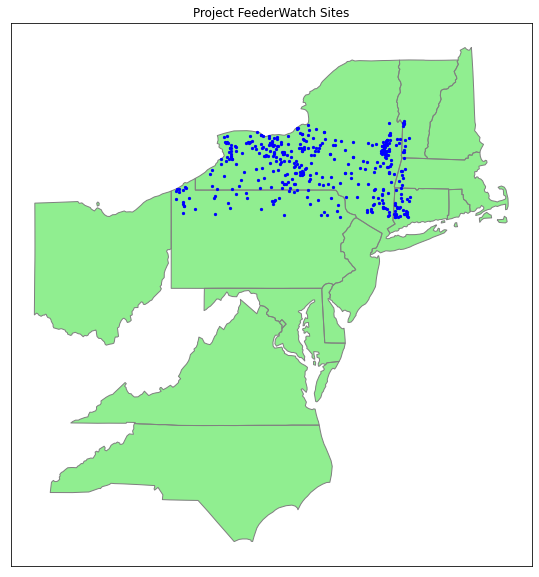

In [ ]:
min_lat = 41.36
max_lat = 43.65
min_lon = -80.52
max_lon = -73.00

cond_pos = (pfdata.latitude > min_lat) & (pfdata.latitude < max_lat) & \
            (pfdata.longitude > min_lon) & (pfdata.longitude < max_lon)

pfdata_sub = pfdata[cond_pos].reset_index()

long_lat_sub = pfdata_sub.groupby(['longitude', 'latitude']).count().reset_index()[['longitude', 'latitude']]
geometry_sub = [Point(xy) for xy in zip(long_lat_sub['longitude'], long_lat_sub['latitude'])]
geo_df_sub = gpd.GeoDataFrame(long_lat_sub, crs=crs, geometry=geometry_sub)

plot_map(geo_df_sub, (10,10), "Project FeederWatch Sites")

For time, the safeguard against bias is to select a range of time within a single project period where the proportion of checklists with a bluebird observation is fairly consistent. 

In [ ]:
pfdata_sub.groupby('proj_period_id')['index'].count()

proj_period_id
PFW_2016    4092
PFW_2017    4558
PFW_2018    4839
PFW_2019    4855
PFW_2020    5932
PFW_2021    5732
Name: index, dtype: int64

As shown in the bar plot below, PFW_2021 is chosen because weeks 10 through 16 have a fairly consistent proportion of checklists with a bluebird observation.

In [ ]:
period = periods[5]

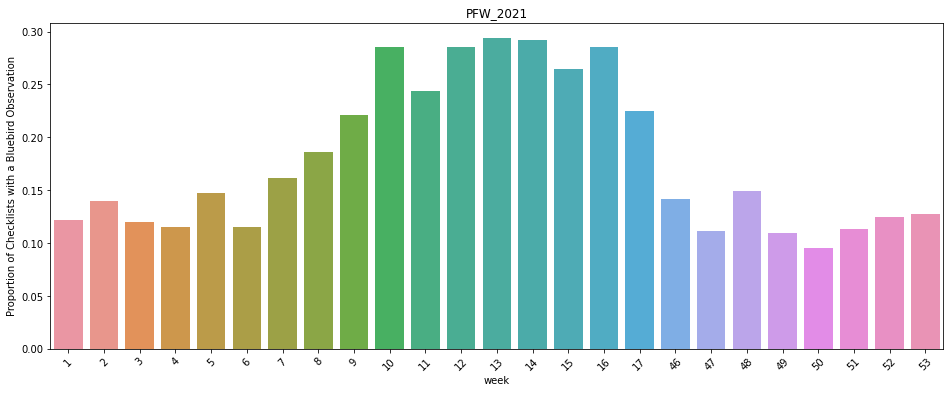

In [ ]:
# Get the number of bluebird observations per week in the chosen period
bb_per_week = pfdata_sub[pfdata_sub['proj_period_id'] == period].groupby('week')['easblu_gr'].sum()

# Get the number of checklists per week in the chosen period
ckl_per_week = pfdata_sub[pfdata_sub['proj_period_id'] == period].groupby('week')['sub_id'].count()

# Get the proportion of checklists, per week, that have a bluebird observation
bb_ckl_week = bb_per_week / ckl_per_week

plt.figure(figsize = (16,6))

sns.barplot(bb_ckl_week.index, bb_ckl_week)
plt.title(period)
plt.xticks(rotation=45)
plt.ylabel("Proportion of Checklists with a Bluebird Observation")

plt.show()

In [ ]:
# Subset from min_week to max_week

min_week = 10
max_week = 16

cond_time = (pfdata.week >= min_week) & (pfdata.week <= max_week)

pfdata_unsup = pfdata[(pfdata.proj_period_id == period) & cond_pos & cond_time].reset_index()
X_unsup = pfdata_unsup[unsup_feat]

X_unsup.sum(axis = 0)

houspa          2707.0000000
tmin           41948.0000000
daejun          5515.0000000
tmax           75009.0000000
houfin          2473.0000000
yerwar             2.0000000
numfeeders      7211.0000000
amegfi          5867.0000000
water_area    319466.8100000
pop_dens      155198.1987988
easblu_gr        397.0000000
dtype: float64

The bird yerwar has only two observations in this filtered dataset.  Remove the yerwar column.

In [ ]:
X_unsup = X_unsup.drop(columns = ['yerwar'])
unsup_feat.remove('yerwar')
unsup_feat

['houspa',
 'tmin',
 'daejun',
 'tmax',
 'houfin',
 'numfeeders',
 'amegfi',
 'water_area',
 'pop_dens',
 'easblu_gr']

In [ ]:
# Reorder 
unsup_feat = ['tmin',
              'tmax',
              'water_area',
              'pop_dens',
              'numfeeders',
              'houfin',
              'amegfi',
              'daejun',
              'houspa',
              'easblu_gr']

Standardize the features.

In [ ]:
scaler = StandardScaler()
X_unsup_std = scaler.fit_transform(X_unsup)

###UMAP

Start tuning the parameters for UMAP to view the dataset in two-dimensional space.

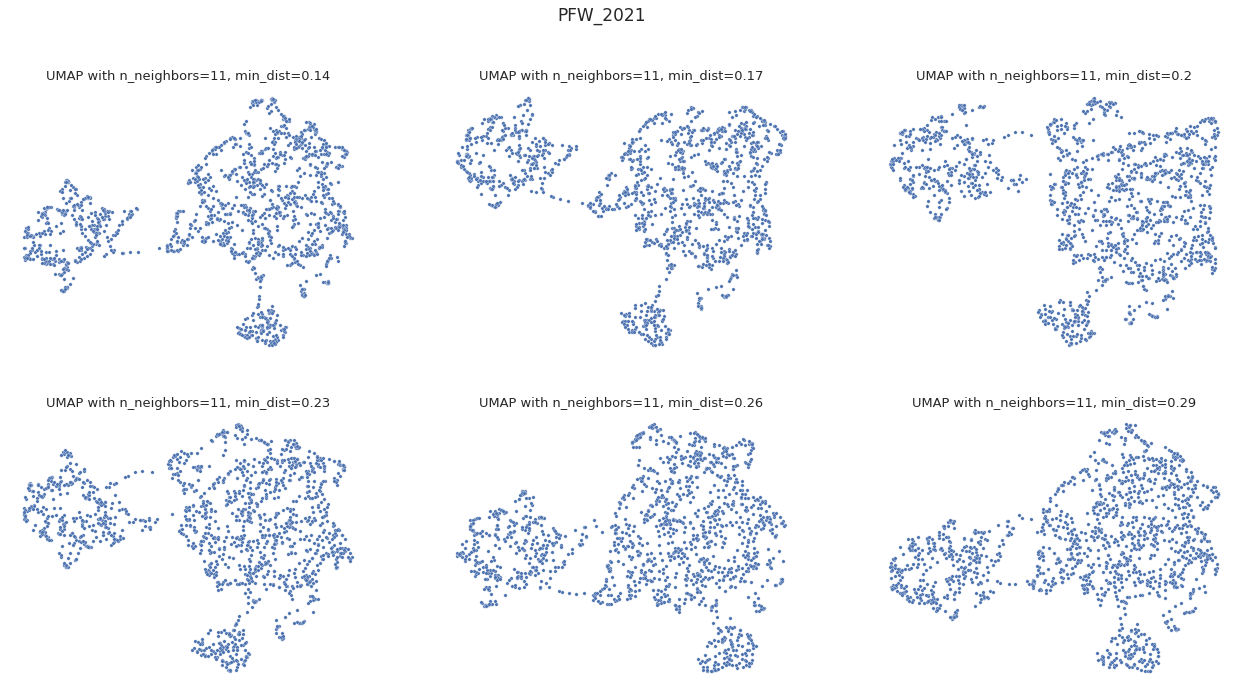

In [ ]:
num_neigh = 11
min_dist_vals = [0.14, 0.17, 0.20, 0.23, 0.26, 0.29]

font_s = 13

plt.figure(figsize = (22,11))
plt.suptitle(period, fontsize=font_s+4)

for idx, val in enumerate(min_dist_vals):
  umap_results = umap.UMAP(n_neighbors=num_neigh, min_dist=val, metric='correlation').fit_transform(X_unsup_std)
  umap_df = pd.DataFrame(umap_results, columns=['umap_0', 'umap_1'])
  
  plt.subplot(2, 3, idx+1)
  sns.scatterplot(data=umap_df, x="umap_0", y="umap_1", s=12)
  plt.title("UMAP with n_neighbors={}, min_dist={}".format(num_neigh, val), size=font_s)
  plt.xticks([])
  plt.yticks([])
  plt.axis('off')

The minimum distance of 0.17 appears to identify at least 3 significantly sized clusters.

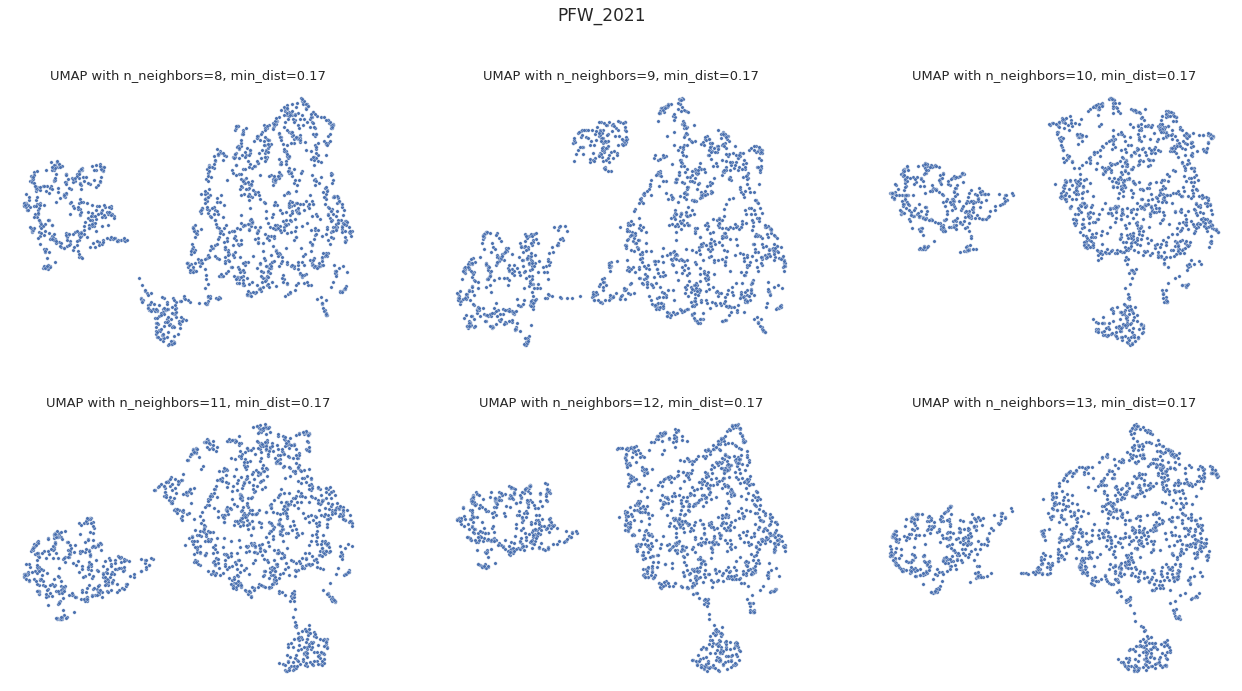

In [ ]:
n_neighbors_vals = [8, 9, 10, 11, 12, 13]
min_d = 0.17

font_s = 13

plt.figure(figsize = (22,11))
plt.suptitle(period, fontsize=font_s+4)

for idx, val in enumerate(n_neighbors_vals):
  umap_results = umap.UMAP(n_neighbors=val, min_dist=min_d, metric='correlation').fit_transform(X_unsup_std)
  umap_df = pd.DataFrame(umap_results, columns=['umap_0', 'umap_1'])
  
  plt.subplot(2, 3, idx+1)
  sns.scatterplot(data=umap_df, x="umap_0", y="umap_1", s=12)
  plt.title("UMAP with n_neighbors={}, min_dist={}".format(val, min_d), size=font_s)
  plt.xticks([])
  plt.xticks([])
  plt.yticks([])
  plt.axis('off')

Proceed with n_neighbors=11 and min_dist=0.17 since that representation seems to have separation between clusters, while keeping the clusters compact.

Create the UMAP dataframe for the final parameters.

In [ ]:
num_neigh = 11
min_d = 0.17

umap_df = pd.DataFrame(umap.UMAP(n_neighbors=num_neigh, min_dist=min_d, metric='correlation').fit_transform(X_unsup_std), columns=['umap_0', 'umap_1'])

###Agglomerative Clustering

Apply agglomerative clustering to group similar records, and evaluate model performance.  Evaluate with the three linkage methods: complete, average, and ward.

In [ ]:
linkages = ['complete', 'average', 'ward']

First, compare dendograms for the three linkage methods.

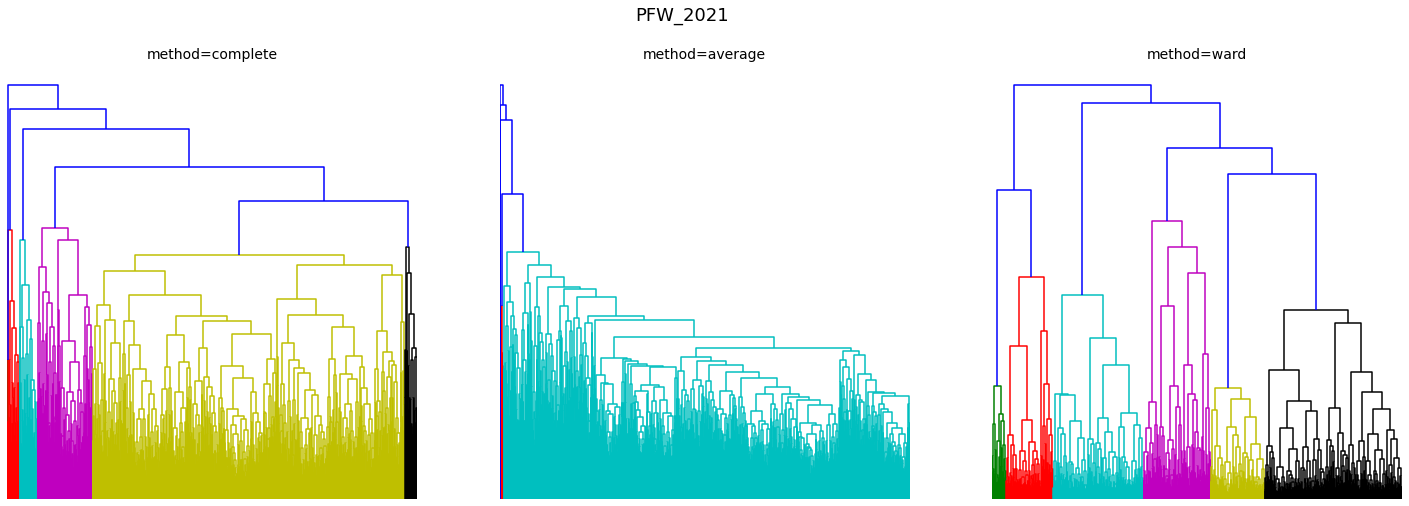

In [ ]:
font_s = 14

plt.figure(figsize = (25,8))
plt.suptitle(period, fontsize=font_s+4)

for idx, link in enumerate(linkages):
  plt.subplot(1, 3, idx+1)
  dendrogram(linkage(X_unsup_std, method=link))
  plt.title("method={}".format(link), size=font_s)
  plt.xticks([])
  plt.yticks([])
  plt.axis('off')

plt.show()

According to the dendograms, the linkage method, ward, identifies distinct clusters.

Proceed with ward for the agglomerative clustering model.

In [ ]:
method = 'agglomerative_clustering'
linkages = ['ward']
n_clus = [2, 3, 4, 5]

cols = ['proj_period_id', 'method', 'n_clusters', 'silhouette_score', 'params']

umap_preds_df_dict = {}    # Temporary dictionary containing a df of cluster values with UMAP for all param values for a single period.
results_df_list = []    # A list of dfs with key results for all params and periods.
agg_clus_preds_dict = {}    # Dict of dict of dfs containing all cluster values and UMAPs for all params and periods.  Top-level keys are the periods.

for nc in n_clus:

    for link in linkages:

        if link == 'ward':
            aff = 'euclidean'
        else:
            aff = 'cosine'

        params = {'linkage' : link, 'affinity' : aff, 'n_clusters' : nc}

        fit_df = pd.DataFrame(AgglomerativeClustering(**params).fit_predict(X_unsup_std), columns=['y_pred']).reset_index()
        umap_df = umap_df
        concat_df = pd.concat([fit_df, umap_df], axis=1)
        umap_preds_df_dict[str(link)+"n_clus_"+str(nc)] = concat_df

        results_df = pd.DataFrame(columns=cols)

        peri = period

        sil_score = round(metrics.silhouette_score(X_unsup_std, concat_df['y_pred'], metric='euclidean'),4)
        results_list = [peri, method, nc, sil_score, str(params)]

        for ii, val in enumerate(results_list):
            
            results_df.loc[0, cols[ii]] = val

        results_df_list.append(results_df)

agg_clus_preds_dict[peri] = umap_preds_df_dict

umap_preds_df_dict = {}

agg_clus_results_df = pd.concat(results_df_list, ignore_index=True)

Write the agglomerative clustering umaps and clusters to a file.

In [ ]:
with open(fdir + "models/agg_clus_preds.pickle", "wb") as handle:
    pickle.dump(agg_clus_preds_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(fdir + "models/agg_clus_preds.pickle", "rb") as handle:
    agg_clus_preds_dict = pickle.load(handle)

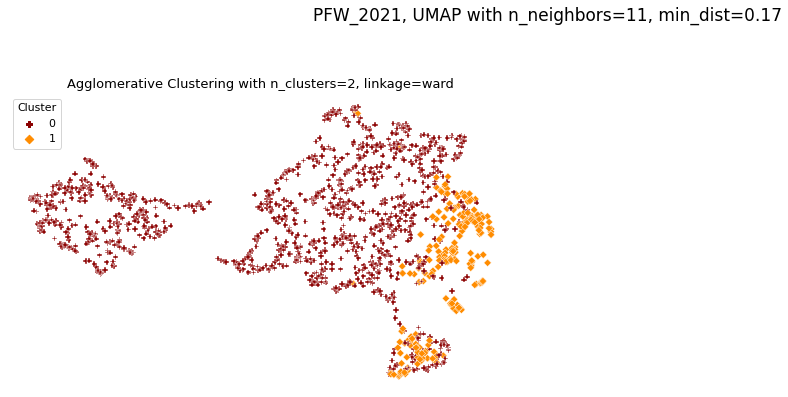

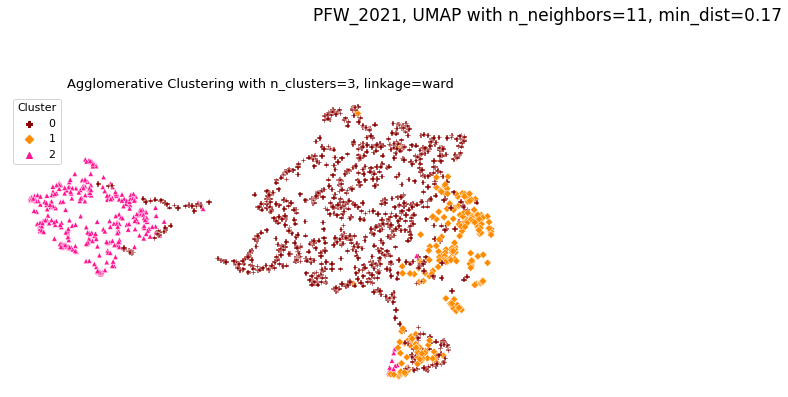

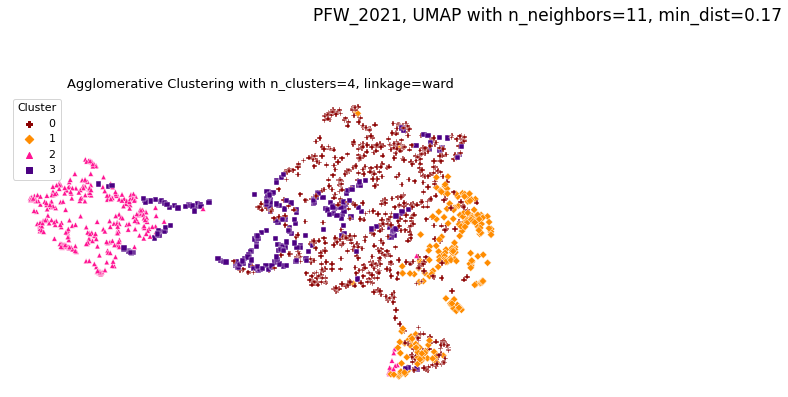

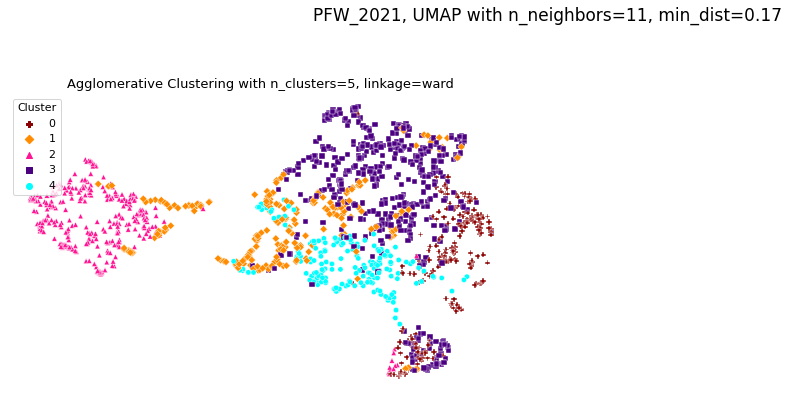

In [ ]:
peri = period

pal={0:'darkred', 1:'darkorange', 2:'deeppink', 3:'indigo', 4:'cyan'}
mark={0:'P', 1:'D', 2:'^', 3:'s', 4:'o'}

font_s = 11

for nc in n_clus:

    plt.figure(figsize = (20,12))
    plt.suptitle(peri + ", UMAP with n_neighbors={}, min_dist={}".format(num_neigh, min_d), fontsize=font_s+6)

    for idx, link in enumerate(linkages):
        plt.subplot(2, 2, idx+1)
        ax = sns.scatterplot(data=agg_clus_preds_dict[peri][str(link)+"n_clus_"+str(nc)], x="umap_0", y="umap_1", hue="y_pred", hue_order=list(np.arange(0, nc)),
                            style="y_pred", s=28, palette=dict((c, pal[c]) for c in list(np.arange(0, nc)) if c in pal),
                            markers=dict((m, mark[m]) for m in list(np.arange(0, nc)) if m in mark))
        legend_labels, _= ax.get_legend_handles_labels()
        lg = ax.legend(legend_labels, list(np.arange(0, nc)), loc='upper left', title='Cluster', fontsize=font_s)
        lg_title = lg.get_title()
        lg_title.set_fontsize(font_s)
        plt.title("Agglomerative Clustering with n_clusters={}, linkage={}".format(nc, link), size=font_s+2)
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')

    plt.show()
    print('\n')

In [ ]:
agg_clus_results_df.sort_values('silhouette_score', ascending=False)

proj_period_id                    method n_clusters silhouette_score  \
0       PFW_2021  agglomerative_clustering          2           0.1836   
2       PFW_2021  agglomerative_clustering          4           0.1198   
1       PFW_2021  agglomerative_clustering          3           0.1118   
3       PFW_2021  agglomerative_clustering          5           0.0837   

                                              params  
0  {'linkage': 'ward', 'affinity': 'euclidean', '...  
2  {'linkage': 'ward', 'affinity': 'euclidean', '...  
1  {'linkage': 'ward', 'affinity': 'euclidean', '...  
3  {'linkage': 'ward', 'affinity': 'euclidean', '...

The next section will compare the 2, 3, and 4 cluster results, since they were the top three in terms of silhouette score.  The 4-cluster model appears to have scored better than the 3-cluster model because, as shown in the UMAP, it captured a group of points residing mostly between groups 0 and 2.  Each solution has intermingling between clusters to some degree.

Write the agglomerative clustering results to a csv.

In [ ]:
agg_clus_results_df.to_csv(fdir + "models/agg_clus_results.csv")

In [ ]:
agg_clus_results_df = pd.read_csv(fdir + "models/agg_clus_results.csv")
agg_clus_results_df = agg_clus_results_df.drop(columns = 'Unnamed: 0')

###Comparison of Unsupervised Learning Models

In [ ]:
pd.set_option("display.precision", 3)

In [ ]:
# Function to get the means of the clusters and return as a df.

def clus_means(dictio, n_clus, type_link):

    top_preds = pd.concat([pfdata_unsup, dictio[period][type_link + 'n_clus_' + str(n_clus)]['y_pred']], axis=1)

    means = []

    for clus in np.arange(0, n_clus, 1):

        mean = top_preds[top_preds['y_pred'] == clus][unsup_feat].describe().loc[['mean']]
        mean['cluster'] = clus
        mean['count'] = top_preds[top_preds['y_pred'] == clus][unsup_feat].describe().loc[['count']].mode(axis=1)[0][0]
        means.append(mean)

    df = pd.concat(means).sort_values('easblu_gr').set_index('cluster')
    df.insert(0, 'count', df.pop('count'))

    return df

Load the dictionaries containing all cluster values and UMAPs for all parameters.

In [ ]:
with open(fdir + "models/agg_clus_preds.pickle", "rb") as handle:
    agg_clus_preds_dict = pickle.load(handle)

agg_clus_results_df = pd.read_csv(fdir + "models/agg_clus_results.csv")
agg_clus_results_df = agg_clus_results_df.drop(columns = 'Unnamed: 0')

results_df = agg_clus_results_df.sort_values('silhouette_score', ascending=False, ignore_index=True)
results_df

proj_period_id                    method  n_clusters  silhouette_score  \
0       PFW_2021  agglomerative_clustering           2             0.184   
1       PFW_2021  agglomerative_clustering           4             0.120   
2       PFW_2021  agglomerative_clustering           3             0.112   
3       PFW_2021  agglomerative_clustering           5             0.084   

                                              params  
0  {'linkage': 'ward', 'affinity': 'euclidean', '...  
1  {'linkage': 'ward', 'affinity': 'euclidean', '...  
2  {'linkage': 'ward', 'affinity': 'euclidean', '...  
3  {'linkage': 'ward', 'affinity': 'euclidean', '...

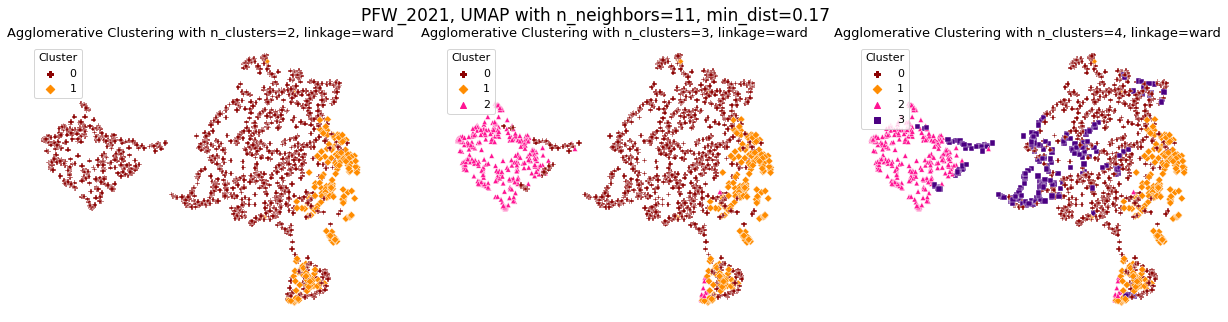

In [ ]:
peri = period
link = 'ward'

pal={0:'darkred', 1:'darkorange', 2:'deeppink', 3:'indigo', 4:'cyan'}
mark={0:'P', 1:'D', 2:'^', 3:'s', 4:'o'}

font_s = 11

plt.figure(figsize = (21,5))
plt.suptitle(peri + ", UMAP with n_neighbors={}, min_dist={}".format(num_neigh, min_d), fontsize=font_s+6)

for idx, nc in enumerate([2, 3, 4]):

    plt.subplot(1, 3, idx+1)
    ax = sns.scatterplot(data=agg_clus_preds_dict[peri][str(link)+"n_clus_"+str(nc)], x="umap_0", y="umap_1", hue="y_pred", hue_order=list(np.arange(0, nc)),
                        style="y_pred", s=28, palette=dict((c, pal[c]) for c in list(np.arange(0, nc)) if c in pal),
                        markers=dict((m, mark[m]) for m in list(np.arange(0, nc)) if m in mark))
    legend_labels, _= ax.get_legend_handles_labels()
    lg = ax.legend(legend_labels, list(np.arange(0, nc)), loc='upper left', title='Cluster', fontsize=font_s)
    lg_title = lg.get_title()
    lg_title.set_fontsize(font_s)
    plt.title("Agglomerative Clustering with n_clusters={}, linkage={}".format(nc, link), size=font_s+2)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

The following three dataframes present the means of each feature for each of the 3 solutions.

In [ ]:
print("2-Cluster Solution, linkage=ward")
clus_means(agg_clus_preds_dict, 2, 'ward')

2-Cluster Solution, linkage=ward


count    tmin    tmax  water_area  pop_dens  numfeeders  houfin  \
cluster                                                                     
1         213.0  30.723  53.333     823.933   293.832       6.047   1.770   
0        1214.0  29.163  52.429     118.591    76.287       4.879   1.727   

         amegfi  daejun  houspa  easblu_gr  
cluster                                     
1         2.972   2.413   2.455      0.146  
0         4.311   4.119   1.799      0.301

In [ ]:
print("3-Cluster Solution, linkage=ward")
clus_means(agg_clus_preds_dict, 3, 'ward')

3-Cluster Solution, linkage=ward


count    tmin    tmax  water_area  pop_dens  numfeeders  houfin  \
cluster                                                                    
0        900.0  28.959  52.247     120.065    69.170       5.076   1.760   
1        213.0  30.723  53.333     823.933   293.832       6.047   1.770   
2        314.0  29.748  52.952     114.364    96.684       4.315   1.631   

         amegfi  daejun  houspa  easblu_gr  
cluster                                     
0         4.583   4.334   1.971      0.058  
1         2.972   2.413   2.455      0.146  
2         3.532   3.503   1.306      1.000

In [ ]:
print("4-Cluster Solution, linkage=ward")
clus_means(agg_clus_preds_dict, 4, 'ward')

4-Cluster Solution, linkage=ward


count    tmin    tmax  water_area  pop_dens  numfeeders  houfin  \
cluster                                                                    
0        665.0  28.850  52.020     137.709    70.094       3.823   1.546   
1        213.0  30.723  53.333     823.933   293.832       6.047   1.770   
3        235.0  29.268  52.889      70.137    66.555       8.621   2.366   
2        314.0  29.748  52.952     114.364    96.684       4.315   1.631   

         amegfi  daejun  houspa  easblu_gr  
cluster                                     
0         2.740   3.472   1.319      0.000  
1         2.972   2.413   2.455      0.146  
3         9.800   6.774   3.817      0.221  
2         3.532   3.503   1.306      1.000

Examining the 2, 3, and 4 cluster solutions versus the heat map below, the only strong conclusion can be made with the 2-cluster model, which has the highest silhouette score.  It follows the heat map and the general notion that house sparrows are more populous in highly developed areas (high population density), and the likelihood of an eastern bluebird observation drops in highly developed areas with house sparrows, which take over nesting cavities.

The other models do not follow this common notion, but they also have lower scores.

Note that water_area and pop_dens are at the county level, and tmin and tmax are from gridded data.  Additional data with more features about the observation sites at a more granular detail would be beneficial in further exploring local influences on bluebird presence/absence.  Perhaps with additional detail, an accurate 3 or 4 cluster model could be obtained to more clearly identify reasons for shifts between presence and absence.



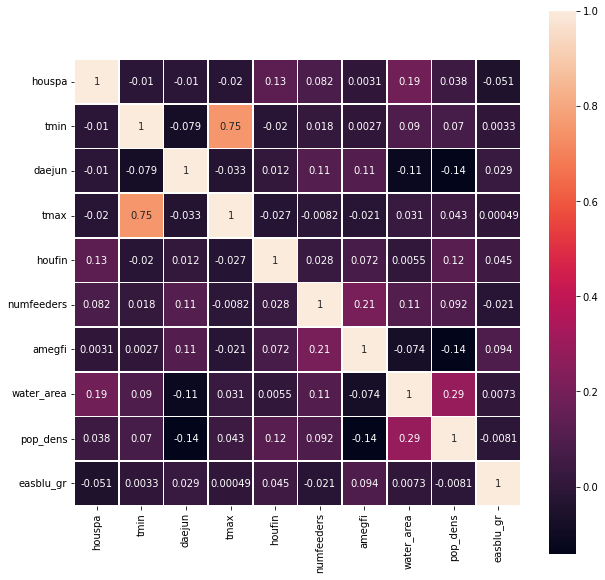

In [ ]:
plt.figure(figsize=(10, 10))

sns.heatmap(X_unsup.corr(), square=True, annot=True, linewidth = 0.5)

plt.show()

##Conclusions and Next Steps

In [ ]:
bb_corr = pfdata[X.columns.tolist() + ['easblu_gr']].corr()['easblu_gr'][:].sort_values(ascending=False)
bb_corr

easblu_gr             1.000
carwre                0.239
yerwar                0.214
normoc                0.172
carchi                0.169
tmax                  0.158
day_in_period         0.140
tmin                  0.135
norfli                0.123
rebwoo                0.115
proj_period           0.103
evgr_shrbs_atleast    0.099
houfin                0.089
whtspa                0.084
amerob                0.078
amecro                0.059
amegfi                0.054
effort_hrs_atleast    0.049
dowwoo                0.047
norcar                0.041
pop_dens              0.040
numfeeders            0.029
eursta                0.027
tuftit                0.012
pcpn                  0.010
whbnut                0.005
daejun               -0.010
moudov               -0.052
longitude            -0.061
water_area           -0.074
blujay               -0.079
houspa               -0.123
ruc_2013             -0.142
bkcchi               -0.164
latitude             -0.273
Name: easblu_gr, dty

In [ ]:
hs_corr = pfdata[X.columns.tolist() + ['easblu_gr']].corr()['houspa'][:].sort_values(ascending=False)
hs_corr

houspa                1.000
latitude              0.156
blujay                0.116
norcar                0.115
eursta                0.114
pop_dens              0.101
moudov                0.091
houfin                0.086
numfeeders            0.078
dowwoo                0.077
effort_hrs_atleast    0.052
water_area            0.041
rebwoo                0.040
whbnut                0.030
bkcchi                0.030
amerob                0.021
daejun                0.017
amegfi                0.012
norfli                0.006
amecro                0.002
pcpn                 -0.009
normoc               -0.013
whtspa               -0.022
ruc_2013             -0.025
proj_period          -0.043
evgr_shrbs_atleast   -0.061
tuftit               -0.064
yerwar               -0.067
carwre               -0.068
tmin                 -0.072
carchi               -0.073
day_in_period        -0.088
longitude            -0.090
tmax                 -0.110
easblu_gr            -0.123
Name: houspa, dtype:

In [ ]:
gb_results[['mean_fit_time', 'mean_test_accuracy_score', 'std_test_accuracy_score', 'mean_test_precision_score', 'mean_test_recall_score']].head(1)

mean_fit_time  mean_test_accuracy_score  std_test_accuracy_score  \
4       1579.514                     0.875                3.974e-04   

   mean_test_precision_score  mean_test_recall_score  
4                      0.828                   0.678

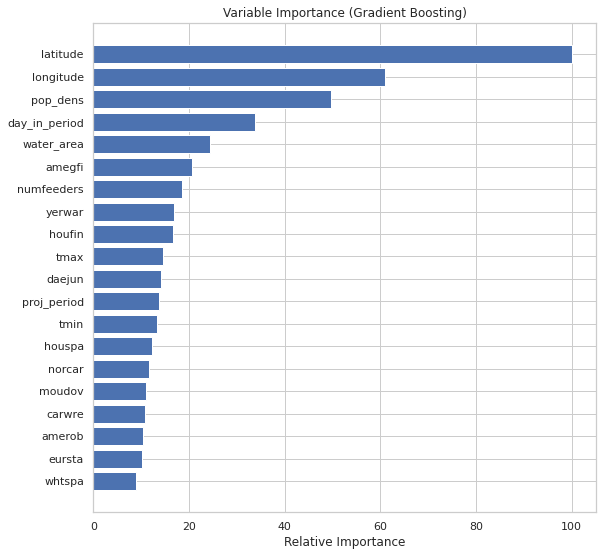

In [ ]:
plt.figure(figsize = (9,9))

plot_feat_imp(gbg.best_estimator_, 'Gradient Boosting', 20, X)

plt.show()

In [ ]:
print("2-Cluster Solution, linkage=ward")
clus_means(agg_clus_preds_dict, 2, 'ward')

2-Cluster Solution, linkage=ward


count    tmin    tmax  water_area  pop_dens  numfeeders  houfin  \
cluster                                                                     
1         213.0  30.723  53.333     823.933   293.832       6.047   1.770   
0        1214.0  29.163  52.429     118.591    76.287       4.879   1.727   

         amegfi  daejun  houspa  easblu_gr  
cluster                                     
1         2.972   2.413   2.455      0.146  
0         4.311   4.119   1.799      0.301

Conclusions:
*  Among the classification models evaluated for predicting eastern bluebird presence/absence, the gradient boosting model is the best performer with a test accuracy score of 0.875, a precision score of 0.828, and a reasonable recall score of 0.678.  Moreover, it proves to be generalizable, as the cross-validation resulted in consistent scores.
* With the combination of the GBM model with resulting feature importance and the unsupervised learning, interactions between variables could be identified, such as the negative interaction between the eastern bluebird and the house sparrow.
*  On the other hand, some bird species, such as the american goldfinch, have high feature importance, positively influencing the presence of eastern bluebirds.
*  Aside from latitude, longitude, and time variables with high feature importance, population density and water area proved to be important even though those variables are at the county level.


Potential next steps:
*  Integrate gridded land cover data from the National Land Cover Database (NLCD).  This would provide an additional dimension to more clearly explore local habitat influences, especially through unsupervised learning.

*  Aggregate with additional bird observation sources, such as the Audubon Christmas Bird Count.
* Look into other ways to improve the spatial and temporal distribution of the data, and to improve the data balance of bluebird presence/absence without doing it artificially.

For the use case of this model, consider the current conservation efforts as well as existing technology used by birders.  There are some birding organizations specifically dedicated to the conservation and resurgence of the eastern bluebird.  One common conservation method is to install nest boxes that are resistant to invasive birds.  Cornell Lab and other organizations have bird identification apps.  This classification model could be used as an enhancement to an app to give information on expected bluebird presence.  Furthermore, an improved unsupervised learning model could help identify areas where nest boxes would be beneficial to target bluebird decline.